In [243]:
import numpy as np
import pandas as pd
import scipy
import SolveLinSys
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from numba import njit
import os
import sys
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.autolayout'] = True


solu = pickle.load(open('../data/solution/solu_dynamicdmg_21*101_0302_13:46', 'rb'))

In [248]:
@njit
def upwind_2d(LHS, A, B1, B2, C1, C2, i, j, dx, dy, ϵ):
    """
    Compute the coefficient of the equation at v(i, j).
    Parameters
    ----------
    LHS : (I*J, I*J) ndarray
        LHS matrix of the linear system.
    A, B1, B2, C1, C2 : (I, J) ndarrays
    i, j : ints
    dx, dy : floats
    ϵ : float
        False transient step size.
    Returns
    -------
    LHS : (I*J, I*J) ndarray
        Updated LHS matrix of the linear system.
    """
    I, J = A.shape
    loc_eq = i*J + j
    loc_xy = loc_eq
    loc_xp1y = (i+1)*J + j
    loc_xp2y = (i+2)*J + j
    loc_xm1y = (i-1)*J + j
    loc_xm2y = (i-2)*J + j
    loc_xyp1 = i*J + j+1
    loc_xyp2 = i*J + j+2
    loc_xym1 = i*J + j-1
    loc_xym2 = i*J + j-2
    LHS[loc_xy, loc_xy] += A[i, j] - 1./ϵ
    if i == 0:
        LHS[loc_eq, loc_xy] += B1[i, j] * (-1./dx) + C1[i, j] * (1./dx**2)
        LHS[loc_eq, loc_xp1y] += B1[i, j] * (1./dx) + C1[i, j] * (-2./dx**2)
        LHS[loc_eq, loc_xp2y] += C1[i, j] * (1./dx**2)
    elif i == I-1:
        LHS[loc_eq, loc_xy] += B1[i, j] * (1./dx) + C1[i, j] * (1./dx**2)
        LHS[loc_eq, loc_xm1y] += B1[i, j] * (-1./dx) + C1[i, j] * (-2./dx**2)
        LHS[loc_eq, loc_xm2y] += C1[i, j] * (1./dx**2)
    else:
        LHS[loc_eq, loc_xy] += B1[i, j] * ((-1./dx) * (B1[i, j]>0) + (1./dx) * (B1[i, j]<=0))\
                    + C1[i, j] * (-2./dx**2)
        LHS[loc_eq, loc_xm1y] += B1[i, j] * (-1./dx) * (B1[i, j]<=0) + C1[i, j] * (1./dx**2)
        LHS[loc_eq, loc_xp1y] += B1[i, j] * (1./dx) * (B1[i, j]>0) + C1[i, j] * (1./dx**2)
    if j == 0:
        LHS[loc_eq, loc_xy] += B2[i, j] * (-1./dy) + C2[i, j] * (1./dy**2)
        LHS[loc_eq, loc_xyp1] += B2[i, j] * (1./dy) + C2[i, j] * (-2./dy**2)
        LHS[loc_eq, loc_xyp2] += C2[i, j] * (1./dy**2)
    elif j == J-1:
        LHS[loc_eq, loc_xy] += B2[i, j] * (1./dy) + C2[i, j] * (1./dy**2)
        LHS[loc_eq, loc_xym1] += B2[i, j] * (-1./dy) + C2[i, j] * (-2./dy**2)
        LHS[loc_eq, loc_xym2] += C2[i, j] * (1./dy**2)
    else:
        LHS[loc_eq, loc_xy] += B2[i, j] * ((-1./dy) * (B2[i, j]>0) + (1./dy) * (B2[i, j]<=0))\
                    + C2[i, j] * (-2./dy**2)
        LHS[loc_eq, loc_xym1] += B2[i, j] * (-1./dy) * (B2[i, j]<=0) + C2[i, j] * (1./dy**2)
        LHS[loc_eq, loc_xyp1] += B2[i, j] * (1./dy) * (B2[i, j]>0) + C2[i, j] * (1./dy**2)
    return LHS


@njit
def construct_matrix_2d(A, B1, B2, C1, C2, D, v0, ϵ, dx, dy, bc, impose_bc):
    """
    Construct coefficient matrix of the linear system.
    
    Parameters
    ----------
    A, B1, B2, C1, C2, D : (I, J) ndarrays
    v0 : (I, J) ndarray
        Value function from last iteration.
    ϵ : False transient step size
    dx, dy : floats    
    bc : tuple of ndarrays
        Impose v=bc[k] at boundaries.
        Order: lower boundary of x, upper boundary of x,
               lower boundary of y, upper boundary of y.
    impose_bc : tuple of bools
        Order: lower boundary of x, upper boundary of x,
               lower boundary of y, upper boundary of y.
    Returns
    -------
    LHS : (I*J, I*J) ndarray
        LHS of the linear system.
    RHS : (I*J) ndarray
        RHS of the linear system.
    """
    I, J = A.shape
    LHS = np.zeros((I*J, I*J))
    RHS = - D.reshape(-1) - 1./ϵ*v0.reshape(-1)
    for i in range(I):
        for j in range(J):
            loc_eq = i*J + j
            if i == 0 and impose_bc[0]:
                LHS[loc_eq, loc_eq] = 1.
                RHS[loc_eq] = bc[0][j]
            elif i == I-1 and impose_bc[1]:
                LHS[loc_eq, loc_eq] = 1.
                RHS[loc_eq] = bc[1][j]
            elif j == 0 and impose_bc[2]:
                LHS[loc_eq, loc_eq] = 1.
                RHS[loc_eq] = bc[2][i]
            elif j == J-1 and impose_bc[3]:
                LHS[loc_eq, loc_eq] = 1.
                RHS[loc_eq] = bc[3][i]
            else:
                LHS = upwind_2d(LHS, A, B1, B2, C1, C2, i, j, dx, dy, ϵ)
    return LHS, RHS


def false_transient_one_iteration_python(A, B1, B2, C1, C2, D, v0, ϵ, dx, dy, bc, impose_bc):
    I, J = A.shape
    LHS, RHS = construct_matrix_2d(A, B1, B2, C1, C2, D, v0, ϵ, dx, dy, bc, impose_bc)
    v, exit_code = bicg(csc_matrix(LHS), RHS)
    return v.reshape((I, J))


def false_transient_one_iteration_cpp(stateSpace, A, B1, B2, C1, C2, D, v0, ε):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B1.reshape(-1, 1, order='F'), B2.reshape(-1, 1, order='F')])
    C = np.hstack([C1.reshape(-1, 1, order='F'), C2.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0.reshape(-1, 1, order='F'), ε, -10)
    return out[2].reshape(v0.shape, order = "F")

In [249]:
def compute_derivatives_2d(data, dim, order, dlt):
    res = np.zeros_like(data)
    if order == 1:                    # first order derivatives
        if dim == 0:                  # to first dimension
            res[1:-1,:] = (1 / (2 * dlt)) * (data[2:,:] - data[:-2,:])
            res[-1,:] = (1 / dlt) * (data[-1,:] - data[-2,:])
            res[0,:] = (1 / dlt) * (data[1,:] - data[0,:])
        elif dim == 1:                # to second dimension
            res[:,1:-1] = (1 / (2 * dlt)) * (data[:,2:] - data[:,:-2])
            res[:,-1] = (1 / dlt) * (data[:,-1] - data[:,-2])
            res[:,0] = (1 / dlt) * (data[:,1] - data[:,0])        
    elif order == 2:
        if dim == 0:                  # to first dimension
            res[1:-1,:] = (1 / dlt ** 2) * (data[2:,:] + data[:-2,:] - 2 * data[1:-1,:])
            res[-1,:] = (1 / dlt ** 2) * (data[-1,:] + data[-3,:] - 2 * data[-2,:])
            res[0,:] = (1 / dlt ** 2) * (data[2,:] + data[0,:] - 2 * data[1,:])
        elif dim == 1:                # to second dimension
            res[:,1:-1] = (1 / dlt ** 2) * (data[:,2:] + data[:,:-2] - 2 * data[:,1:-1])
            res[:,-1] = (1 / dlt ** 2) * (data[:,-1] + data[:,-3] - 2 * data[:,-2])
            res[:,0] = (1 / dlt ** 2) * (data[:,2] + data[:,0] - 2 * data[:,1])    
    return res



def hjb_modified(z_grid, y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000,
                                 use_python=False, bc=None, impose_bc=None):
    η, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p = model_paras
    Δ_z = z_grid[1] - z_grid[0]
    Δ_y = y_grid[1] - y_grid[0]
    (z_mat, y_mat) = np.meshgrid(z_grid, y_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])
    if v0 is None:
        v0 = -δ*η*y_mat
    
    d_Λ = λ_1 + λ_2*y_mat + λ_2p*(y_mat>λ_bar)*(y_mat-λ_bar)
    d_Λ_z = d_Λ * z_mat

    mean = - ρ*(z_mat-μ_2)
    std = np.sqrt(z_mat)*σ_2
    var = std**2/2.
    e = - δ*η / ((η-1)*d_Λ_z)
    e_old = e.copy()

    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives_2d(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives_2d(v0, 0, 2, Δ_z)
        v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)

        e_new = - δ*η / (v0_dy*z_mat + (η-1)*d_Λ_z)
        e_new[e_new<=0] = 1e-12
        e = e_new * 0.5 + e_old * 0.5
        e_old = e.copy()

        A = np.ones_like(z_mat)*(-δ)
        B_z = mean
        B_y = z_mat*e
        C_zz = var
        C_yy = np.zeros_like(z_mat)
        D = δ*η*np.log(e) + (η-1)*d_Λ_z*e
        if use_python:
            v0 = false_transient_one_iteration_python(A, B_z, B_y, C_zz, C_yy, D, v0, ε, Δ_z, Δ_y, bc, impose_bc)
        else:
            v0 = false_transient_one_iteration_cpp(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ε)

        rhs_error = A*v0 + B_z*v0_dz + B_y*v0_dy + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    return v0, e

In [250]:
η = .032
δ = .01
# Z process
μ_2 = 1.86/1000.
ρ = 0.9
σ_2 = np.sqrt(2*ρ/10416.29)
# Damage setting
λ_1 = 1.7675/10000
λ_2 = 0.0022*2
λ_bar = 2.
# Three damages
# λ_2p_state = np.array([0., 0.0197*2, 0.3853*2])
# λ_2p_prior = np.array([0.4875, 0.4875, 0.025])
# Two damages
λ_2p_state = np.array([0., 0.0197*2])

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

In [251]:
n_z = 50
z_min = np.max([μ_2 - 3*np.sqrt(σ_2**2*μ_2/(2*ρ)), 1e-9])
z_max = μ_2 + 3*np.sqrt(σ_2**2*μ_2/(2*ρ))
z_grid = np.linspace(z_min, z_max, n_z)

n_y = 50
y_min = 1e-10
y_max = 10
y_grid = np.linspace(y_min, y_max, n_y)

# Solve for each damage function
ϕ_state = []
for λ_2p in λ_2p_state:
    pde_paras = (η, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p)
    ϕ, _ = hjb_modified(z_grid, y_grid, model_paras=pde_paras, v0=None,
                           ϵ=.5, tol=1e-8, max_iter=10_000, use_python=False)
    ϕ_state.append(ϕ)

Iteration 1: LHS Error: 0.0014451636931549635; RHS Error 0.0018258099200731185
Iteration 2: LHS Error: 0.0013259298265649209; RHS Error 0.0015870481258874083
Iteration 3: LHS Error: 0.0012489890928941943; RHS Error 0.0014341936562414616
Iteration 4: LHS Error: 0.0011924643904215274; RHS Error 0.0013256548324169116
Iteration 5: LHS Error: 0.0011464755682885977; RHS Error 0.0012433684624314108
Iteration 6: LHS Error: 0.0011067084717271735; RHS Error 0.0011782676056142274
Iteration 7: LHS Error: 0.0010714123281512257; RHS Error 0.001125323000374886
Iteration 8: LHS Error: 0.0010398559227960246; RHS Error 0.0010814396887144214
Iteration 9: LHS Error: 0.001011608054127408; RHS Error 0.0010445063040953764
Iteration 10: LHS Error: 0.0009862799201139985; RHS Error 0.0010129711800735076
Iteration 11: LHS Error: 0.0009634783799504117; RHS Error 0.0009856532271039168
Iteration 12: LHS Error: 0.0009428251127549005; RHS Error 0.0009616462935178519
Iteration 13: LHS Error: 0.0009239798291460488; RHS

Iteration 105: LHS Error: 0.00037935203330254075; RHS Error 0.00038030243206446705
Iteration 106: LHS Error: 0.00037653659247045834; RHS Error 0.00037747369996681706
Iteration 107: LHS Error: 0.0003737479973479896; RHS Error 0.00037467208092009934
Iteration 108: LHS Error: 0.00037098585966582887; RHS Error 0.000371897178967379
Iteration 109: LHS Error: 0.00036824979994438956; RHS Error 0.0003691486087893577
Iteration 110: LHS Error: 0.00036553944717604425; RHS Error 0.0003664259916756729
Iteration 111: LHS Error: 0.00036285443920003324; RHS Error 0.00036372895796557266
Iteration 112: LHS Error: 0.00036019442203479024; RHS Error 0.00036105714727832714
Iteration 113: LHS Error: 0.00035755904877711464; RHS Error 0.0003584102081410036
Iteration 114: LHS Error: 0.0003549479828492269; RHS Error 0.0003557877953398944
Iteration 115: LHS Error: 0.0003523608888504476; RHS Error 0.0003531895720587279
Iteration 116: LHS Error: 0.00034979744665218637; RHS Error 0.00035061520559325865
Iteration 117:

Iteration 206: LHS Error: 0.00018840067642135472; RHS Error 0.00018870327115657855
Iteration 207: LHS Error: 0.00018716563612547477; RHS Error 0.00018746534594539347
Iteration 208: LHS Error: 0.00018593956698320646; RHS Error 0.00018623642830594355
Iteration 209: LHS Error: 0.00018472239124761591; RHS Error 0.0001850164363315477
Iteration 210: LHS Error: 0.0001835140320425449; RHS Error 0.00018380529411960876
Iteration 211: LHS Error: 0.0001823144134433241; RHS Error 0.00018260292225295968
Iteration 212: LHS Error: 0.000181123460208793; RHS Error 0.00018140925306099794
Iteration 213: LHS Error: 0.0001799410981453281; RHS Error 0.00018022420105491175
Iteration 214: LHS Error: 0.0001787672537159335; RHS Error 0.00017904770389848507
Iteration 215: LHS Error: 0.00017760185420831465; RHS Error 0.00017787968118832822
Iteration 216: LHS Error: 0.00017644482777416648; RHS Error 0.00017672005693218358
Iteration 217: LHS Error: 0.00017529610338394563; RHS Error 0.0001755687691597285
Iteration 21

Iteration 308: LHS Error: 9.817284481805633e-05; RHS Error 9.829689853420624e-05
Iteration 309: LHS Error: 9.756209585340403e-05; RHS Error 9.768514334063474e-05
Iteration 310: LHS Error: 9.695535945329625e-05; RHS Error 9.707742377823775e-05
Iteration 311: LHS Error: 9.635262017408663e-05; RHS Error 9.647370100892118e-05
Iteration 312: LHS Error: 9.575384766320749e-05; RHS Error 9.587395238642028e-05
Iteration 313: LHS Error: 9.515901362207313e-05; RHS Error 9.527815790018183e-05
Iteration 314: LHS Error: 9.45680895743789e-05; RHS Error 9.468627890640055e-05
Iteration 315: LHS Error: 9.398104613311808e-05; RHS Error 9.40982896807047e-05
Iteration 316: LHS Error: 9.339785565519454e-05; RHS Error 9.351415957331436e-05
Iteration 317: LHS Error: 9.281849033128398e-05; RHS Error 9.293386466094702e-05
Iteration 318: LHS Error: 9.224292372539411e-05; RHS Error 9.235737950928451e-05
Iteration 319: LHS Error: 9.167112744552786e-05; RHS Error 9.178466915929484e-05
Iteration 320: LHS Error: 9.11

Iteration 410: LHS Error: 5.2471188750902176e-05; RHS Error 5.2527696000028356e-05
Iteration 411: LHS Error: 5.2154363773829204e-05; RHS Error 5.221045473643711e-05
Iteration 412: LHS Error: 5.183952471335407e-05; RHS Error 5.189520339822962e-05
Iteration 413: LHS Error: 5.152665848903726e-05; RHS Error 5.1581928944684934e-05
Iteration 414: LHS Error: 5.121575231975539e-05; RHS Error 5.127061694064675e-05
Iteration 415: LHS Error: 5.090679249258878e-05; RHS Error 5.0961253704113574e-05
Iteration 416: LHS Error: 5.059976623847384e-05; RHS Error 5.0653830490487366e-05
Iteration 417: LHS Error: 5.029466493168544e-05; RHS Error 5.0348329801716725e-05
Iteration 418: LHS Error: 4.999146788038644e-05; RHS Error 5.004474359943394e-05
Iteration 419: LHS Error: 4.969016662714765e-05; RHS Error 4.974305226460225e-05
Iteration 420: LHS Error: 4.9390751619207696e-05; RHS Error 4.9443246577815384e-05
Iteration 421: LHS Error: 4.909320499998926e-05; RHS Error 4.914532191972081e-05
Iteration 422: LHS 

Iteration 512: LHS Error: 2.8471518591852152e-05; RHS Error 2.8498878021215152e-05
Iteration 513: LHS Error: 2.8302968001228668e-05; RHS Error 2.8330139744633205e-05
Iteration 514: LHS Error: 2.813544219396058e-05; RHS Error 2.8162426752598082e-05
Iteration 515: LHS Error: 2.7968934752514718e-05; RHS Error 2.7995730088298688e-05
Iteration 516: LHS Error: 2.7803439300908006e-05; RHS Error 2.783005027505545e-05
Iteration 517: LHS Error: 2.7638949402400415e-05; RHS Error 2.766537611854176e-05
Iteration 518: LHS Error: 2.7475458706002764e-05; RHS Error 2.750170282593892e-05
Iteration 519: LHS Error: 2.7312960949460452e-05; RHS Error 2.7339023289035336e-05
Iteration 520: LHS Error: 2.7151449859610932e-05; RHS Error 2.717733378823986e-05
Iteration 521: LHS Error: 2.6990919184510798e-05; RHS Error 2.701662414191148e-05
Iteration 522: LHS Error: 2.683136704648148e-05; RHS Error 2.6856890920085984e-05
Iteration 523: LHS Error: 2.6672773105140823e-05; RHS Error 2.669812886554792e-05
Iteration 52

Iteration 617: LHS Error: 1.5335576474803658e-05; RHS Error 1.5349007305208852e-05
Iteration 618: LHS Error: 1.524610029732254e-05; RHS Error 1.525944211221283e-05
Iteration 619: LHS Error: 1.5157156715836506e-05; RHS Error 1.5170409648894239e-05
Iteration 620: LHS Error: 1.5068742470564223e-05; RHS Error 1.5081907784730321e-05
Iteration 621: LHS Error: 1.4980854320029158e-05; RHS Error 1.4993932296567458e-05
Iteration 622: LHS Error: 1.489348903781218e-05; RHS Error 1.4906481396469531e-05
Iteration 623: LHS Error: 1.4806643411802156e-05; RHS Error 1.4819549360170644e-05
Iteration 624: LHS Error: 1.472031428235987e-05; RHS Error 1.4733134902187033e-05
Iteration 625: LHS Error: 1.4634498493690251e-05; RHS Error 1.4647233419016114e-05
Iteration 626: LHS Error: 1.4549192915269682e-05; RHS Error 1.456184425569179e-05
Iteration 627: LHS Error: 1.446439440656866e-05; RHS Error 1.4476962089137444e-05
Iteration 628: LHS Error: 1.438009987116129e-05; RHS Error 1.4392584947186507e-05
Iteration 6

Iteration 722: LHS Error: 8.324530183456691e-06; RHS Error 8.331289200217036e-06
Iteration 723: LHS Error: 8.276484631586367e-06; RHS Error 8.283198438216043e-06
Iteration 724: LHS Error: 8.228720682901258e-06; RHS Error 8.235392556130605e-06
Iteration 725: LHS Error: 8.181236641591205e-06; RHS Error 8.187864653316714e-06
Iteration 726: LHS Error: 8.134030839365702e-06; RHS Error 8.14061756540627e-06
Iteration 727: LHS Error: 8.087101583842404e-06; RHS Error 8.093645680153148e-06
Iteration 728: LHS Error: 8.0404472602158e-06; RHS Error 8.046948015820953e-06
Iteration 729: LHS Error: 7.994066227950958e-06; RHS Error 8.000526558857258e-06
Iteration 730: LHS Error: 7.94795681199889e-06; RHS Error 7.954376389787514e-06
Iteration 731: LHS Error: 7.902117456451418e-06; RHS Error 7.908495431129328e-06
Iteration 732: LHS Error: 7.85654661261681e-06; RHS Error 7.862885025048229e-06
Iteration 733: LHS Error: 7.811242414057507e-06; RHS Error 7.817539494746101e-06
Iteration 734: LHS Error: 7.76620

Iteration 827: LHS Error: 4.5451422560072174e-06; RHS Error 5.836308745650089e-06
Iteration 828: LHS Error: 4.5191278796319345e-06; RHS Error 5.861969293559496e-06
Iteration 829: LHS Error: 4.493264661203922e-06; RHS Error 5.88747597556386e-06
Iteration 830: LHS Error: 4.467551214679122e-06; RHS Error 5.91283842924493e-06
Iteration 831: LHS Error: 4.441986519373997e-06; RHS Error 5.93805449942671e-06
Iteration 832: LHS Error: 4.416569810442028e-06; RHS Error 5.963123615470396e-06
Iteration 833: LHS Error: 4.3913002714945915e-06; RHS Error 5.988047931654045e-06
Iteration 834: LHS Error: 4.366177056250309e-06; RHS Error 6.012829432452309e-06
Iteration 835: LHS Error: 4.341199331237e-06; RHS Error 6.0374665890427625e-06
Iteration 836: LHS Error: 4.316366240042502e-06; RHS Error 6.061960154258531e-06
Iteration 837: LHS Error: 4.291676753323537e-06; RHS Error 6.086314906312814e-06
Iteration 838: LHS Error: 4.267130330956603e-06; RHS Error 6.110524772158597e-06
Iteration 839: LHS Error: 4.24

Iteration 932: LHS Error: 2.4928563564091677e-06; RHS Error 7.86110023416717e-06
Iteration 933: LHS Error: 2.4786766418677386e-06; RHS Error 7.875097188170775e-06
Iteration 934: LHS Error: 2.4645787650989792e-06; RHS Error 7.889010983406098e-06
Iteration 935: LHS Error: 2.4505618959475006e-06; RHS Error 7.902844895322711e-06
Iteration 936: LHS Error: 2.4366256358154814e-06; RHS Error 7.916599341384204e-06
Iteration 937: LHS Error: 2.4227695292478035e-06; RHS Error 7.930274683070303e-06
Iteration 938: LHS Error: 2.408993116084779e-06; RHS Error 7.943871372973615e-06
Iteration 939: LHS Error: 2.395295943369291e-06; RHS Error 7.957389887050005e-06
Iteration 940: LHS Error: 2.381677557672379e-06; RHS Error 7.970830682869218e-06
Iteration 941: LHS Error: 2.3681375069251054e-06; RHS Error 7.984194221781395e-06
Iteration 942: LHS Error: 2.3546753391279207e-06; RHS Error 7.997480963967043e-06
Iteration 943: LHS Error: 2.3412906062642014e-06; RHS Error 8.010691373073076e-06
Iteration 944: LHS E

Iteration 1039: LHS Error: 1.3565078300220579e-06; RHS Error 8.98295037550013e-06
Iteration 1040: LHS Error: 1.3488354935337066e-06; RHS Error 8.99052768946521e-06
Iteration 1041: LHS Error: 1.3412068849277814e-06; RHS Error 8.998061410768043e-06
Iteration 1042: LHS Error: 1.3336217421777707e-06; RHS Error 9.005552270995509e-06
Iteration 1043: LHS Error: 1.3260798405051455e-06; RHS Error 9.013000483774252e-06
Iteration 1044: LHS Error: 1.31858082305647e-06; RHS Error 9.020405647223702e-06
Iteration 1045: LHS Error: 1.3111246183472591e-06; RHS Error 9.027769088255531e-06
Iteration 1046: LHS Error: 1.3037109131974756e-06; RHS Error 9.035090747762072e-06
Iteration 1047: LHS Error: 1.2963394512982562e-06; RHS Error 9.042370758836514e-06
Iteration 1048: LHS Error: 1.289009987401335e-06; RHS Error 9.049609334596791e-06
Iteration 1049: LHS Error: 1.2817220063632284e-06; RHS Error 9.05680670407259e-06
Iteration 1050: LHS Error: 1.2744756377608413e-06; RHS Error 9.063962605503897e-06
Iteration 

Iteration 1141: LHS Error: 7.615123356202735e-07; RHS Error 9.570662799042624e-06
Iteration 1142: LHS Error: 7.572226135427185e-07; RHS Error 9.574901257454775e-06
Iteration 1143: LHS Error: 7.529566636299556e-07; RHS Error 9.579115856810701e-06
Iteration 1144: LHS Error: 7.487150912588447e-07; RHS Error 9.583306565137065e-06
Iteration 1145: LHS Error: 7.444975662490583e-07; RHS Error 9.587473259433082e-06
Iteration 1146: LHS Error: 7.40304011245807e-07; RHS Error 9.591616333961498e-06
Iteration 1147: LHS Error: 7.361342016926065e-07; RHS Error 9.595736052038159e-06
Iteration 1148: LHS Error: 7.319880256373423e-07; RHS Error 9.599832475353735e-06
Iteration 1149: LHS Error: 7.278653143399927e-07; RHS Error 9.603905784416611e-06
Iteration 1150: LHS Error: 7.237659850056755e-07; RHS Error 9.607955902016414e-06
Iteration 1151: LHS Error: 7.196898825639897e-07; RHS Error 9.611983114153318e-06
Iteration 1152: LHS Error: 7.156368814487113e-07; RHS Error 9.61598755256244e-06
Iteration 1153: LH

Iteration 1250: LHS Error: 4.1181072764351345e-07; RHS Error 9.916220661992589e-06
Iteration 1251: LHS Error: 4.0949813216728526e-07; RHS Error 9.918506147709068e-06
Iteration 1252: LHS Error: 4.0719860112947703e-07; RHS Error 9.920778782787024e-06
Iteration 1253: LHS Error: 4.049120490012825e-07; RHS Error 9.92303859045831e-06
Iteration 1254: LHS Error: 4.02638419452761e-07; RHS Error 9.925285649509293e-06
Iteration 1255: LHS Error: 4.003775963823397e-07; RHS Error 9.927519948830154e-06
Iteration 1256: LHS Error: 3.9812955245077664e-07; RHS Error 9.929741772812329e-06
Iteration 1257: LHS Error: 3.9589419253971414e-07; RHS Error 9.931951005295479e-06
Iteration 1258: LHS Error: 3.936714586122436e-07; RHS Error 9.934147784140465e-06
Iteration 1259: LHS Error: 3.914612479727353e-07; RHS Error 9.936332108251593e-06
Iteration 1260: LHS Error: 3.8926351965395956e-07; RHS Error 9.938504197699134e-06
Iteration 1261: LHS Error: 3.870781913467569e-07; RHS Error 9.940664018447815e-06
Iteration 12

Iteration 1351: LHS Error: 2.3335112095401733e-07; RHS Error 1.009259943632432e-05
Iteration 1352: LHS Error: 2.3204397493759021e-07; RHS Error 1.009389213429252e-05
Iteration 1353: LHS Error: 2.3074405948453336e-07; RHS Error 1.0095177713684593e-05
Iteration 1354: LHS Error: 2.2945133909546556e-07; RHS Error 1.0096456189079587e-05
Iteration 1355: LHS Error: 2.2816578185147485e-07; RHS Error 1.009772758414e-05
Iteration 1356: LHS Error: 2.2688735300258056e-07; RHS Error 1.0098991926388301e-05
Iteration 1357: LHS Error: 2.2561601910331408e-07; RHS Error 1.0100249239684746e-05
Iteration 1358: LHS Error: 2.2435174626411758e-07; RHS Error 1.0101499561873412e-05
Iteration 1359: LHS Error: 2.230944998321549e-07; RHS Error 1.0102742900728028e-05
Iteration 1360: LHS Error: 2.2184424482152298e-07; RHS Error 1.0103979310744932e-05
Iteration 1361: LHS Error: 2.2060095146436698e-07; RHS Error 1.0105208810837164e-05
Iteration 1362: LHS Error: 2.193645845804948e-07; RHS Error 1.010643143160221e-05
I

Iteration 1459: LHS Error: 1.2722788218788583e-07; RHS Error 1.0197529513378007e-05
Iteration 1460: LHS Error: 1.2651586570044948e-07; RHS Error 1.019823350314076e-05
Iteration 1461: LHS Error: 1.2580818209428912e-07; RHS Error 1.0198933629923046e-05
Iteration 1462: LHS Error: 1.251038065502863e-07; RHS Error 1.019963029727771e-05
Iteration 1463: LHS Error: 1.2440392335721917e-07; RHS Error 1.02003221765898e-05
Iteration 1464: LHS Error: 1.2370749359613686e-07; RHS Error 1.0201010948811132e-05
Iteration 1465: LHS Error: 1.2301513774293227e-07; RHS Error 1.020169559147032e-05
Iteration 1466: LHS Error: 1.223267245276105e-07; RHS Error 1.0202376300444752e-05
Iteration 1467: LHS Error: 1.2164215551502267e-07; RHS Error 1.0203053144736737e-05
Iteration 1468: LHS Error: 1.2096143761630707e-07; RHS Error 1.0203726241223487e-05
Iteration 1469: LHS Error: 1.202845316822243e-07; RHS Error 1.0204395546311619e-05
Iteration 1470: LHS Error: 1.1961141346827908e-07; RHS Error 1.0205061094671532e-05


Iteration 1567: LHS Error: 6.938982342885591e-08; RHS Error 1.0254752951988641e-05
Iteration 1568: LHS Error: 6.900170228252289e-08; RHS Error 1.0255136593765191e-05
Iteration 1569: LHS Error: 6.861574415595317e-08; RHS Error 1.02555180902695e-05
Iteration 1570: LHS Error: 6.823193819671669e-08; RHS Error 1.0255897463839168e-05
Iteration 1571: LHS Error: 6.785027052702564e-08; RHS Error 1.0256274720251476e-05
Iteration 1572: LHS Error: 6.747073166835094e-08; RHS Error 1.0256649883929811e-05
Iteration 1573: LHS Error: 6.709330831189408e-08; RHS Error 1.0257022941489915e-05
Iteration 1574: LHS Error: 6.671798952195829e-08; RHS Error 1.0257393920221156e-05
Iteration 1575: LHS Error: 6.634476361344621e-08; RHS Error 1.0257762826423617e-05
Iteration 1576: LHS Error: 6.597361891513831e-08; RHS Error 1.0258129676385267e-05
Iteration 1577: LHS Error: 6.560454374193725e-08; RHS Error 1.0258494484975504e-05
Iteration 1578: LHS Error: 6.523752721365739e-08; RHS Error 1.0258857253970253e-05
Iterat

Iteration 1668: LHS Error: 3.93671767545678e-08; RHS Error 1.028452088786512e-05
Iteration 1669: LHS Error: 3.914803836657654e-08; RHS Error 1.0284737374564564e-05
Iteration 1670: LHS Error: 3.893007578803509e-08; RHS Error 1.0284952655720313e-05
Iteration 1671: LHS Error: 3.8713240058108056e-08; RHS Error 1.0285166869964096e-05
Iteration 1672: LHS Error: 3.849752516771332e-08; RHS Error 1.02853799483567e-05
Iteration 1673: LHS Error: 3.8282977066206314e-08; RHS Error 1.0285591806022659e-05
Iteration 1674: LHS Error: 3.806955359286768e-08; RHS Error 1.0285802572740973e-05
Iteration 1675: LHS Error: 3.785725007088292e-08; RHS Error 1.0286012233876648e-05
Iteration 1676: LHS Error: 3.764608116907375e-08; RHS Error 1.0286220754336444e-05
Iteration 1677: LHS Error: 3.743601197092605e-08; RHS Error 1.0286428189912756e-05
Iteration 1678: LHS Error: 3.722707841991024e-08; RHS Error 1.0286634454728747e-05
Iteration 1679: LHS Error: 3.7019255355597025e-08; RHS Error 1.0286839619409347e-05
Itera

Iteration 1778: LHS Error: 2.121737142923852e-08; RHS Error 1.030243561979849e-05
Iteration 1779: LHS Error: 2.1097932220714988e-08; RHS Error 1.0302552596487243e-05
Iteration 1780: LHS Error: 2.097969396819277e-08; RHS Error 1.0302671771677792e-05
Iteration 1781: LHS Error: 2.0861906757652093e-08; RHS Error 1.0302788177170893e-05
Iteration 1782: LHS Error: 2.074544704078196e-08; RHS Error 1.0302903933526565e-05
Iteration 1783: LHS Error: 2.062903158017715e-08; RHS Error 1.0303017462749047e-05
Iteration 1784: LHS Error: 2.05141355014149e-08; RHS Error 1.0303129795134194e-05
Iteration 1785: LHS Error: 2.0398511935137975e-08; RHS Error 1.0303246769781393e-05
Iteration 1786: LHS Error: 2.0284610532939062e-08; RHS Error 1.0303361806743554e-05
Iteration 1787: LHS Error: 2.0170090792026585e-08; RHS Error 1.0303471611949715e-05
Iteration 1788: LHS Error: 2.0056144467428538e-08; RHS Error 1.0303581827321266e-05
Iteration 1789: LHS Error: 1.994485103462562e-08; RHS Error 1.0303693547501465e-05


Iteration 1893: LHS Error: 1.1090565812943431e-08; RHS Error 1.0312387103963202e-05
Iteration 1894: LHS Error: 1.1028490606856955e-08; RHS Error 1.03124481699449e-05
Iteration 1895: LHS Error: 1.0966705363268936e-08; RHS Error 1.0312509132709901e-05
Iteration 1896: LHS Error: 1.0905209249512104e-08; RHS Error 1.0312569863807786e-05
Iteration 1897: LHS Error: 1.084403893070185e-08; RHS Error 1.0312630326250564e-05
Iteration 1898: LHS Error: 1.0783177906148467e-08; RHS Error 1.0312690475293429e-05
Iteration 1899: LHS Error: 1.0722621568426405e-08; RHS Error 1.0312750308789443e-05
Iteration 1900: LHS Error: 1.0662378452375165e-08; RHS Error 1.0312809813734468e-05
Iteration 1901: LHS Error: 1.0602451736008156e-08; RHS Error 1.0312869005319044e-05
Iteration 1902: LHS Error: 1.0542843667527002e-08; RHS Error 1.0312927868427009e-05
Iteration 1903: LHS Error: 1.0483554496731884e-08; RHS Error 1.0312986406512412e-05
Iteration 1904: LHS Error: 1.0424585764057248e-08; RHS Error 1.031304462341333e

Iteration 84: LHS Error: 0.00042851589588303873; RHS Error 0.0004303531628723197
Iteration 85: LHS Error: 0.0004245908185968872; RHS Error 0.0004264089752377718
Iteration 86: LHS Error: 0.00042070365364144796; RHS Error 0.00042250300212961925
Iteration 87: LHS Error: 0.0004168539289885892; RHS Error 0.0004186347617695832
Iteration 88: LHS Error: 0.00041304119709045795; RHS Error 0.0004148037851257057
Iteration 89: LHS Error: 0.0004092649983525945; RHS Error 0.00041100961310516337
Iteration 90: LHS Error: 0.0004055249090475152; RHS Error 0.0004072518237508
Iteration 91: LHS Error: 0.0004018205080544013; RHS Error 0.0004035299699451213
Iteration 92: LHS Error: 0.0003981513849393159; RHS Error 0.000399843632178064
Iteration 93: LHS Error: 0.0003945171387453525; RHS Error 0.0003961924038432939
Iteration 94: LHS Error: 0.00039091737664946613; RHS Error 0.00039257588557755436
Iteration 95: LHS Error: 0.00038735171611278124; RHS Error 0.0003889936862093732
Iteration 96: LHS Error: 0.000383819

Iteration 190: LHS Error: 0.0001969024296013533; RHS Error 0.00020235050100161542
Iteration 191: LHS Error: 0.000195929102303663; RHS Error 0.00020137720620717789
Iteration 192: LHS Error: 0.000194960585071971; RHS Error 0.0002004087197435892
Iteration 193: LHS Error: 0.00019399685413225287; RHS Error 0.00019944502033970415
Iteration 194: LHS Error: 0.0001930378875324712; RHS Error 0.00019848608572500096
Iteration 195: LHS Error: 0.00019208366004604127; RHS Error 0.00019753188841265315
Iteration 196: LHS Error: 0.0001911341488353424; RHS Error 0.00019658240841232482
Iteration 197: LHS Error: 0.000190189330233001; RHS Error 0.00019563762105638297
Iteration 198: LHS Error: 0.0001892491834580845; RHS Error 0.00019469750302909724
Iteration 199: LHS Error: 0.0001883136850037992; RHS Error 0.0001937620143475754
Iteration 200: LHS Error: 0.00018738280504715377; RHS Error 0.00019283116705397465
Iteration 201: LHS Error: 0.00018645652637123977; RHS Error 0.00019190493027436704
Iteration 202: LH

Iteration 295: LHS Error: 0.00011702258065564297; RHS Error 0.00012247323787427296
Iteration 296: LHS Error: 0.00011644407532682144; RHS Error 0.00012189474903607093
Iteration 297: LHS Error: 0.00011586842907214401; RHS Error 0.00012131912001010414
Iteration 298: LHS Error: 0.00011529562789283632; RHS Error 0.00012074633643670675
Iteration 299: LHS Error: 0.00011472565785876354; RHS Error 0.00012017638440239183
Iteration 300: LHS Error: 0.00011415850498994184; RHS Error 0.00011960924948382828
Iteration 301: LHS Error: 0.00011359415547609886; RHS Error 0.00011904491831506269
Iteration 302: LHS Error: 0.00011303259541195487; RHS Error 0.000118483376458597
Iteration 303: LHS Error: 0.00011247381108604737; RHS Error 0.00011792461030833274
Iteration 304: LHS Error: 0.00011191778881197711; RHS Error 0.00011736860629403396
Iteration 305: LHS Error: 0.00011136451484004828; RHS Error 0.0001168153504826896
Iteration 306: LHS Error: 0.00011081397570364415; RHS Error 0.0001162648294087043
Iteratio

Iteration 399: LHS Error: 6.989168257952316e-05; RHS Error 7.534386208174056e-05
Iteration 400: LHS Error: 6.954614787031688e-05; RHS Error 7.499833863622394e-05
Iteration 401: LHS Error: 6.920232123112935e-05; RHS Error 7.465452333054034e-05
Iteration 402: LHS Error: 6.886019428396783e-05; RHS Error 7.431240735943692e-05
Iteration 403: LHS Error: 6.851975867455673e-05; RHS Error 7.397198305694421e-05
Iteration 404: LHS Error: 6.818100543819205e-05; RHS Error 7.363324073792724e-05
Iteration 405: LHS Error: 6.784392927000615e-05; RHS Error 7.329617372710707e-05
Iteration 406: LHS Error: 6.75085070565018e-05; RHS Error 7.296077845294512e-05
Iteration 407: LHS Error: 6.71747541793194e-05; RHS Error 7.262703099687433e-05
Iteration 408: LHS Error: 6.684269540173371e-05; RHS Error 7.229493289535207e-05
Iteration 409: LHS Error: 6.651218694063432e-05; RHS Error 7.196447273997094e-05
Iteration 410: LHS Error: 6.618335381666784e-05; RHS Error 7.163566316891083e-05
Iteration 411: LHS Error: 6.58

Iteration 502: LHS Error: 4.1949010147673826e-05; RHS Error 4.7401929114561576e-05
Iteration 503: LHS Error: 4.174148250592202e-05; RHS Error 4.7194538024434e-05
Iteration 504: LHS Error: 4.153508210293089e-05; RHS Error 4.698816852925585e-05
Iteration 505: LHS Error: 4.1329924361843684e-05; RHS Error 4.6782817162578476e-05
Iteration 506: LHS Error: 4.11254028475222e-05; RHS Error 4.657848817449017e-05
Iteration 507: LHS Error: 4.0922211191785074e-05; RHS Error 4.6375165507881925e-05
Iteration 508: LHS Error: 4.071974788935617e-05; RHS Error 4.617284949549178e-05
Iteration 509: LHS Error: 4.051840095471715e-05; RHS Error 4.597152898778577e-05
Iteration 510: LHS Error: 4.0318061897443025e-05; RHS Error 4.577120147071788e-05
Iteration 511: LHS Error: 4.011894079546108e-05; RHS Error 4.557186681984187e-05
Iteration 512: LHS Error: 3.992039268527203e-05; RHS Error 4.537352515786148e-05
Iteration 513: LHS Error: 3.9723000271121855e-05; RHS Error 4.517615884915246e-05
Iteration 514: LHS Erro

Iteration 604: LHS Error: 2.5301903488400557e-05; RHS Error 3.075538585453868e-05
Iteration 605: LHS Error: 2.5176802063028858e-05; RHS Error 3.0630288651807666e-05
Iteration 606: LHS Error: 2.5052319107807253e-05; RHS Error 3.0505809804395748e-05
Iteration 607: LHS Error: 2.4928451618999592e-05; RHS Error 3.038194629774758e-05
Iteration 608: LHS Error: 2.480519649623869e-05; RHS Error 3.0258695337846188e-05
Iteration 609: LHS Error: 2.468255076214232e-05; RHS Error 3.013605351448852e-05
Iteration 610: LHS Error: 2.456051140160842e-05; RHS Error 3.0014018137268137e-05
Iteration 611: LHS Error: 2.4439075352891693e-05; RHS Error 2.9892586110033938e-05
Iteration 612: LHS Error: 2.4318239683115972e-05; RHS Error 2.9771754336500487e-05
Iteration 613: LHS Error: 2.4198001476918862e-05; RHS Error 2.9651520033512107e-05
Iteration 614: LHS Error: 2.407835767306854e-05; RHS Error 2.9531880234838292e-05
Iteration 615: LHS Error: 2.3959305387108443e-05; RHS Error 2.9412831973390824e-05
Iteration 6

Iteration 711: LHS Error: 1.4887177825093079e-05; RHS Error 2.0341098872628293e-05
Iteration 712: LHS Error: 1.481357236703118e-05; RHS Error 2.026748132411067e-05
Iteration 713: LHS Error: 1.4740329745854819e-05; RHS Error 2.0194242712407806e-05
Iteration 714: LHS Error: 1.4667447421790047e-05; RHS Error 2.0121364552816136e-05
Iteration 715: LHS Error: 1.4594923992500286e-05; RHS Error 2.0048844330548886e-05
Iteration 716: LHS Error: 1.4522758055163232e-05; RHS Error 1.9976681442161108e-05
Iteration 717: LHS Error: 1.4450948113989281e-05; RHS Error 1.99048749085015e-05
Iteration 718: LHS Error: 1.4379492631125257e-05; RHS Error 1.9833423316061456e-05
Iteration 719: LHS Error: 1.4308388950029505e-05; RHS Error 1.9762325036146888e-05
Iteration 720: LHS Error: 1.4237637841210682e-05; RHS Error 1.9691581882693354e-05
Iteration 721: LHS Error: 1.416723630011385e-05; RHS Error 1.9621185060734932e-05
Iteration 722: LHS Error: 1.409718255747372e-05; RHS Error 1.9551136222270256e-05
Iteration 

Iteration 818: LHS Error: 8.759029204608026e-06; RHS Error 1.6392276911479588e-05
Iteration 819: LHS Error: 8.715715283838521e-06; RHS Error 1.6386059394161425e-05
Iteration 820: LHS Error: 8.67261541828701e-06; RHS Error 1.6379852128020015e-05
Iteration 821: LHS Error: 8.629728599024444e-06; RHS Error 1.637365518869613e-05
Iteration 822: LHS Error: 8.587053797651234e-06; RHS Error 1.6367468640778623e-05
Iteration 823: LHS Error: 8.544589984782469e-06; RHS Error 1.636129256617127e-05
Iteration 824: LHS Error: 8.502336124968646e-06; RHS Error 1.6355127029672495e-05
Iteration 825: LHS Error: 8.460291187062374e-06; RHS Error 1.6348972116634925e-05
Iteration 826: LHS Error: 8.418454141997933e-06; RHS Error 1.6342827899337763e-05
Iteration 827: LHS Error: 8.37682396384598e-06; RHS Error 1.633669444361149e-05
Iteration 828: LHS Error: 8.335399631562157e-06; RHS Error 1.6330571829745503e-05
Iteration 829: LHS Error: 8.294180129375661e-06; RHS Error 1.6324460120038385e-05
Iteration 830: LHS Er

Iteration 928: LHS Error: 5.077229112124271e-06; RHS Error 1.5780977763993863e-05
Iteration 929: LHS Error: 5.05212083194706e-06; RHS Error 1.5776152858007725e-05
Iteration 930: LHS Error: 5.027136701987733e-06; RHS Error 1.5771341560308935e-05
Iteration 931: LHS Error: 5.002276123766691e-06; RHS Error 1.5766543865048982e-05
Iteration 932: LHS Error: 4.9775356071452e-06; RHS Error 1.576175976293311e-05
Iteration 933: LHS Error: 4.9529179784735256e-06; RHS Error 1.5756984958386678e-05
Iteration 934: LHS Error: 4.9284249409031755e-06; RHS Error 1.5752226167786276e-05
Iteration 935: LHS Error: 4.904052702911499e-06; RHS Error 1.5747482366142997e-05
Iteration 936: LHS Error: 4.879800842128024e-06; RHS Error 1.5742752487686107e-05
Iteration 937: LHS Error: 4.855668845615835e-06; RHS Error 1.5738036277867812e-05
Iteration 938: LHS Error: 4.8316561667288704e-06; RHS Error 1.5733333665945005e-05
Iteration 939: LHS Error: 4.807762219366518e-06; RHS Error 1.5728644626711286e-05
Iteration 940: LH

Iteration 1033: LHS Error: 3.0168248297962608e-06; RHS Error 1.534649475839903e-05
Iteration 1034: LHS Error: 3.0019052052188133e-06; RHS Error 1.5343024569521133e-05
Iteration 1035: LHS Error: 2.987059358625088e-06; RHS Error 1.5339566179777713e-05
Iteration 1036: LHS Error: 2.972286922295342e-06; RHS Error 1.533611956601661e-05
Iteration 1037: LHS Error: 2.9575875420129183e-06; RHS Error 1.533268469953769e-05
Iteration 1038: LHS Error: 2.9429608561643006e-06; RHS Error 1.5329261556309287e-05
Iteration 1039: LHS Error: 2.9284064961415668e-06; RHS Error 1.5325850110268482e-05
Iteration 1040: LHS Error: 2.9139241116693526e-06; RHS Error 1.532245033456685e-05
Iteration 1041: LHS Error: 2.8995133416337415e-06; RHS Error 1.5319062201325654e-05
Iteration 1042: LHS Error: 2.8851738378549152e-06; RHS Error 1.5315685690009016e-05
Iteration 1043: LHS Error: 2.870905242632893e-06; RHS Error 1.5312320771609543e-05
Iteration 1044: LHS Error: 2.85670720952258e-06; RHS Error 1.5308967417526197e-05
I

Iteration 1132: LHS Error: 1.8466148007934002e-06; RHS Error 1.505597164253253e-05
Iteration 1133: LHS Error: 1.8374822850913963e-06; RHS Error 1.5053537615258524e-05
Iteration 1134: LHS Error: 1.8283949210773365e-06; RHS Error 1.5051113320481012e-05
Iteration 1135: LHS Error: 1.8193524820575568e-06; RHS Error 1.5048698232493019e-05
Iteration 1136: LHS Error: 1.8103547392706032e-06; RHS Error 1.5046292220812006e-05
Iteration 1137: LHS Error: 1.8014014818712454e-06; RHS Error 1.5043895227633084e-05
Iteration 1138: LHS Error: 1.79249249006308e-06; RHS Error 1.5041507236474103e-05
Iteration 1139: LHS Error: 1.7836275541388558e-06; RHS Error 1.5039128200958532e-05
Iteration 1140: LHS Error: 1.7748064520400897e-06; RHS Error 1.5036758086454027e-05
Iteration 1141: LHS Error: 1.7660289708537613e-06; RHS Error 1.503439689617633e-05
Iteration 1142: LHS Error: 1.7572948950855816e-06; RHS Error 1.503204457465419e-05
Iteration 1143: LHS Error: 1.7486040160274996e-06; RHS Error 1.5029701099332298e-

Iteration 1231: LHS Error: 1.1303432692622017e-06; RHS Error 1.4928709980012054e-05
Iteration 1232: LHS Error: 1.1247529503044529e-06; RHS Error 1.4930190714899298e-05
Iteration 1233: LHS Error: 1.1191902826723776e-06; RHS Error 1.4931665943524754e-05
Iteration 1234: LHS Error: 1.1136551193585698e-06; RHS Error 1.4933135653144927e-05
Iteration 1235: LHS Error: 1.1081473343943493e-06; RHS Error 1.493459987638899e-05
Iteration 1236: LHS Error: 1.1026667838948123e-06; RHS Error 1.4936058613588383e-05
Iteration 1237: LHS Error: 1.0972133405451334e-06; RHS Error 1.493751189884224e-05
Iteration 1238: LHS Error: 1.091786866719291e-06; RHS Error 1.4938959739288081e-05
Iteration 1239: LHS Error: 1.0863872290239884e-06; RHS Error 1.4940402154482095e-05
Iteration 1240: LHS Error: 1.0810142961198421e-06; RHS Error 1.49418391528404e-05
Iteration 1241: LHS Error: 1.0756679343359998e-06; RHS Error 1.4943270762808234e-05
Iteration 1242: LHS Error: 1.0703480152196576e-06; RHS Error 1.4944696990866414e-

Iteration 1330: LHS Error: 6.918952165507752e-07; RHS Error 1.5050993803952394e-05
Iteration 1331: LHS Error: 6.884732863254861e-07; RHS Error 1.5052004343959645e-05
Iteration 1332: LHS Error: 6.850683572368066e-07; RHS Error 1.5053010779060051e-05
Iteration 1333: LHS Error: 6.816801472186995e-07; RHS Error 1.505401321326449e-05
Iteration 1334: LHS Error: 6.783086710648867e-07; RHS Error 1.5055011761236445e-05
Iteration 1335: LHS Error: 6.74953970117298e-07; RHS Error 1.5056006332152196e-05
Iteration 1336: LHS Error: 6.716157423120039e-07; RHS Error 1.5056996888871527e-05
Iteration 1337: LHS Error: 6.68294177941231e-07; RHS Error 1.505798359650542e-05
Iteration 1338: LHS Error: 6.649888408399862e-07; RHS Error 1.5058966274614444e-05
Iteration 1339: LHS Error: 6.617000534309136e-07; RHS Error 1.5059945187776997e-05
Iteration 1340: LHS Error: 6.584274398896417e-07; RHS Error 1.5060920051036776e-05
Iteration 1341: LHS Error: 6.551709016838769e-07; RHS Error 1.506189112900915e-05
Iteration

Iteration 1432: LHS Error: 4.172051901174534e-07; RHS Error 1.513570242668192e-05
Iteration 1433: LHS Error: 4.1514196183478624e-07; RHS Error 1.5136370026786893e-05
Iteration 1434: LHS Error: 4.1308894066505175e-07; RHS Error 1.5137034868048906e-05
Iteration 1435: LHS Error: 4.1104607921560454e-07; RHS Error 1.5137696966583e-05
Iteration 1436: LHS Error: 4.09013316507445e-07; RHS Error 1.5138356307286887e-05
Iteration 1437: LHS Error: 4.0699060646631757e-07; RHS Error 1.5139012923865922e-05
Iteration 1438: LHS Error: 4.049779020742772e-07; RHS Error 1.5139666825941312e-05
Iteration 1439: LHS Error: 4.029751497630629e-07; RHS Error 1.5140318017584564e-05
Iteration 1440: LHS Error: 4.009823078438002e-07; RHS Error 1.5140966513557523e-05
Iteration 1441: LHS Error: 3.989993177522244e-07; RHS Error 1.5141612319702845e-05
Iteration 1442: LHS Error: 3.9702613517655916e-07; RHS Error 1.5142255454744379e-05
Iteration 1443: LHS Error: 3.9506271944100835e-07; RHS Error 1.5142895916427307e-05
Ite

Iteration 1544: LHS Error: 2.394520997595073e-07; RHS Error 1.5195507765092958e-05
Iteration 1545: LHS Error: 2.383869991823273e-07; RHS Error 1.5195924362061903e-05
Iteration 1546: LHS Error: 2.371957739527586e-07; RHS Error 1.5196330115554014e-05
Iteration 1547: LHS Error: 2.3601677255624676e-07; RHS Error 1.5196736684980469e-05
Iteration 1548: LHS Error: 2.3484655696515144e-07; RHS Error 1.5197142945299691e-05
Iteration 1549: LHS Error: 2.3368357983388766e-07; RHS Error 1.5197549313973428e-05
Iteration 1550: LHS Error: 2.326745519171114e-07; RHS Error 1.5197955370064306e-05
Iteration 1551: LHS Error: 2.3138690610768897e-07; RHS Error 1.5198369958262388e-05
Iteration 1552: LHS Error: 2.302365595674427e-07; RHS Error 1.5198771325537633e-05
Iteration 1553: LHS Error: 2.2909494719336454e-07; RHS Error 1.5199174841570829e-05
Iteration 1554: LHS Error: 2.2796046687811877e-07; RHS Error 1.5199574303138169e-05
Iteration 1555: LHS Error: 2.2698271240351175e-07; RHS Error 1.5199972240154515e-

Iteration 1656: LHS Error: 1.3749622855552257e-07; RHS Error 1.5232563508067254e-05
Iteration 1657: LHS Error: 1.3681610963600654e-07; RHS Error 1.5232820188011698e-05
Iteration 1658: LHS Error: 1.3613935366529883e-07; RHS Error 1.523307574264872e-05
Iteration 1659: LHS Error: 1.3546594367086495e-07; RHS Error 1.5233330181461187e-05
Iteration 1660: LHS Error: 1.347958610981026e-07; RHS Error 1.523358350638993e-05
Iteration 1661: LHS Error: 1.341290944284479e-07; RHS Error 1.5233835722987471e-05
Iteration 1662: LHS Error: 1.3346562949267948e-07; RHS Error 1.5234086833629842e-05
Iteration 1663: LHS Error: 1.3280543736948758e-07; RHS Error 1.5234336846523151e-05
Iteration 1664: LHS Error: 1.3214851414533602e-07; RHS Error 1.5234585765397813e-05
Iteration 1665: LHS Error: 1.314948402247884e-07; RHS Error 1.5234833592474057e-05
Iteration 1666: LHS Error: 1.30844395318519e-07; RHS Error 1.5235080333605815e-05
Iteration 1667: LHS Error: 1.3019716825490857e-07; RHS Error 1.5235325994217242e-05

Iteration 1756: LHS Error: 8.373743889955598e-08; RHS Error 1.5253367197352397e-05
Iteration 1757: LHS Error: 8.33231914021404e-08; RHS Error 1.525353214281485e-05
Iteration 1758: LHS Error: 8.291098567425603e-08; RHS Error 1.5253696350583218e-05
Iteration 1759: LHS Error: 8.250081444394208e-08; RHS Error 1.5253859821650196e-05
Iteration 1760: LHS Error: 8.209267028658207e-08; RHS Error 1.5254022561617532e-05
Iteration 1761: LHS Error: 8.168654584694846e-08; RHS Error 1.5254184574394532e-05
Iteration 1762: LHS Error: 8.12824238610732e-08; RHS Error 1.5254345862594234e-05
Iteration 1763: LHS Error: 8.088029840314093e-08; RHS Error 1.5254506432195902e-05
Iteration 1764: LHS Error: 8.048016564288218e-08; RHS Error 1.5254666285017203e-05
Iteration 1765: LHS Error: 8.008200695630574e-08; RHS Error 1.5254825426535418e-05
Iteration 1766: LHS Error: 7.968582092787724e-08; RHS Error 1.5254983858126073e-05
Iteration 1767: LHS Error: 7.929159517860995e-08; RHS Error 1.5255141583963888e-05
Iterati

Iteration 1871: LHS Error: 4.734118540239418e-08; RHS Error 1.526822103349113e-05
Iteration 1872: LHS Error: 4.7106927067441795e-08; RHS Error 1.5268319420915638e-05
Iteration 1873: LHS Error: 4.6873827638793664e-08; RHS Error 1.5268417364259178e-05
Iteration 1874: LHS Error: 4.6641884798859223e-08; RHS Error 1.5268514865582165e-05
Iteration 1875: LHS Error: 4.6411082393893466e-08; RHS Error 1.5268611927339343e-05
Iteration 1876: LHS Error: 4.618647274357013e-08; RHS Error 1.5268708551036234e-05
Iteration 1877: LHS Error: 4.595426142395276e-08; RHS Error 1.5268793458934546e-05
Iteration 1878: LHS Error: 4.5727947747820075e-08; RHS Error 1.5268898180665074e-05
Iteration 1879: LHS Error: 4.5500715598056907e-08; RHS Error 1.526898612125131e-05
Iteration 1880: LHS Error: 4.5276066909516466e-08; RHS Error 1.5269089039015465e-05
Iteration 1881: LHS Error: 4.5051571001542e-08; RHS Error 1.526917613944921e-05
Iteration 1882: LHS Error: 4.4829099488108426e-08; RHS Error 1.5269277768712917e-05
I

Iteration 1977: LHS Error: 2.798673481851921e-08; RHS Error 1.5276528897023665e-05
Iteration 1978: LHS Error: 2.78482075455333e-08; RHS Error 1.5276597251529423e-05
Iteration 1979: LHS Error: 2.7710364225441708e-08; RHS Error 1.5276649432189064e-05
Iteration 1980: LHS Error: 2.7573217653564797e-08; RHS Error 1.527671810601383e-05
Iteration 1981: LHS Error: 2.743672841698519e-08; RHS Error 1.527676913567577e-05
Iteration 1982: LHS Error: 2.7300924396178594e-08; RHS Error 1.5276837300191577e-05
Iteration 1983: LHS Error: 2.716577393591102e-08; RHS Error 1.5276887903097015e-05
Iteration 1984: LHS Error: 2.703130125292219e-08; RHS Error 1.527695505908254e-05
Iteration 1985: LHS Error: 2.6897498658917662e-08; RHS Error 1.527700572772565e-05
Iteration 1986: LHS Error: 2.6764354801867007e-08; RHS Error 1.5277072491408773e-05
Iteration 1987: LHS Error: 2.663189466178828e-08; RHS Error 1.5277122978816105e-05
Iteration 1988: LHS Error: 2.6500064351231423e-08; RHS Error 1.5277189485320294e-05
Ite

Iteration 2086: LHS Error: 1.632041483901059e-08; RHS Error 1.5281747766900068e-05
Iteration 2087: LHS Error: 1.6257842155864566e-08; RHS Error 1.528177426610123e-05
Iteration 2088: LHS Error: 1.616387043656964e-08; RHS Error 1.528181570610457e-05
Iteration 2089: LHS Error: 1.6097162366945916e-08; RHS Error 1.5281849927070257e-05
Iteration 2090: LHS Error: 1.600627838604929e-08; RHS Error 1.5281892481052296e-05
Iteration 2091: LHS Error: 1.5938298555950858e-08; RHS Error 1.528191996953731e-05
Iteration 2092: LHS Error: 1.5848970288945274e-08; RHS Error 1.528196159578045e-05
Iteration 2093: LHS Error: 1.5780850043389805e-08; RHS Error 1.528199471026914e-05
Iteration 2094: LHS Error: 1.5692860996785463e-08; RHS Error 1.528203633248751e-05
Iteration 2095: LHS Error: 1.5625080229675348e-08; RHS Error 1.5282062356713035e-05
Iteration 2096: LHS Error: 1.553798655018479e-08; RHS Error 1.5282101693836763e-05
Iteration 2097: LHS Error: 1.547054576112039e-08; RHS Error 1.5282137464956336e-05
Ite

Iteration 2185: LHS Error: 9.991910146500693e-09; RHS Error 1.528465979841714e-05


In [252]:
# Compute boundary condition
ϕ_mean = np.average(np.array(ϕ_state), axis=0, weights=[0.5, 0.5])
ϕ_bc = np.zeros_like(z_grid)
for i in range(len(z_grid)):
    ϕ_bc[i] = np.interp(λ_bar, y_grid, ϕ_mean[i])
bc_5 = (np.zeros(1), np.zeros(1), np.zeros(1), ϕ_bc)
impose_bc_5 = (False, False, False, True)

# Change grid setting
n_y = 50
y_min = 1e-10
y_max = 2
y_grid = np.linspace(y_min, y_max, n_y)

pde_paras = (η, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, 0.)

# ϕ_grid, e_grid = hjb_modified(z_grid, y_grid, model_paras=pde_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=1000,
#                               use_python=True, bc=bc, impose_bc=impose_bc)
ϕ_grid_5, e_grid_5 = hjb_modified(z_grid, y_grid, model_paras=pde_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=1000,
                              use_python=True, bc=bc_5, impose_bc=impose_bc_5)

Iteration 1: LHS Error: 0.06816048639873694; RHS Error 0.0018256701246611405
Iteration 2: LHS Error: 0.008992479547687414; RHS Error 0.010535060514501338
Iteration 3: LHS Error: 0.004098664235988654; RHS Error 0.004252204977151964
Iteration 4: LHS Error: 0.0018960570923717002; RHS Error 0.0017690147505851467
Iteration 5: LHS Error: 0.0011340192055499972; RHS Error 0.001238256457584602
Iteration 6: LHS Error: 0.0010925638691905767; RHS Error 0.0011696041955247612
Iteration 7: LHS Error: 0.0010568053584882262; RHS Error 0.0011142191045363024
Iteration 8: LHS Error: 0.0010254607353129535; RHS Error 0.001068889722975053
Iteration 9: LHS Error: 0.0009978090291802473; RHS Error 0.0010994769734401619
Iteration 10: LHS Error: 0.0016898716348618843; RHS Error 0.0013471608187023295
Iteration 11: LHS Error: 0.0013966447157960915; RHS Error 0.001582198106900338
Iteration 12: LHS Error: 0.0016169051322598715; RHS Error 0.0018108222041919018
Iteration 13: LHS Error: 0.0018328584327402808; RHS Error 

Iteration 109: LHS Error: 0.005929737184416806; RHS Error 0.009530693001521356
Iteration 110: LHS Error: 0.005900247848045881; RHS Error 0.009530693001526518
Iteration 111: LHS Error: 0.005870873273215893; RHS Error 0.009530693001519052
Iteration 112: LHS Error: 0.0058417075425486464; RHS Error 0.00953069300152571
Iteration 113: LHS Error: 0.005812508854218357; RHS Error 0.009530693001522594
Iteration 114: LHS Error: 0.0057842080112133765; RHS Error 0.009530693001330448
Iteration 115: LHS Error: 0.005754523013305146; RHS Error 0.00953069300115254
Iteration 116: LHS Error: 0.005725587783808717; RHS Error 0.009530693001329133
Iteration 117: LHS Error: 0.005698686273884035; RHS Error 0.009530693001525427
Iteration 118: LHS Error: 0.005671875349382183; RHS Error 0.009530693001584689
Iteration 119: LHS Error: 0.00564246190933837; RHS Error 0.009530693001598492
Iteration 120: LHS Error: 0.005612019886686248; RHS Error 0.00953069300139627
Iteration 121: LHS Error: 0.005586772631609449; RHS Er

Iteration 213: LHS Error: 0.0035298120319824378; RHS Error 0.009530692999959074
Iteration 214: LHS Error: 0.0035126237810467753; RHS Error 0.009530692999592975
Iteration 215: LHS Error: 0.0034964537555168818; RHS Error 0.009530692997173221
Iteration 216: LHS Error: 0.003477316524614027; RHS Error 0.009530692997037921
Iteration 217: LHS Error: 0.003459441387961837; RHS Error 0.00953069300084731
Iteration 218: LHS Error: 0.0034418544965328923; RHS Error 0.009530693000593404
Iteration 219: LHS Error: 0.0034251297246554735; RHS Error 0.009530693000637726
Iteration 220: LHS Error: 0.0034078892390958515; RHS Error 0.009530693000353058
Iteration 221: LHS Error: 0.0033908380471265875; RHS Error 0.009530693000877255
Iteration 222: LHS Error: 0.0033741187612115198; RHS Error 0.009530693000859488
Iteration 223: LHS Error: 0.003357246948067605; RHS Error 0.00953069300079245
Iteration 224: LHS Error: 0.003340848615029035; RHS Error 0.009530693000495529
Iteration 225: LHS Error: 0.003323922496592857

Iteration 317: LHS Error: 0.0021032838109080743; RHS Error 0.00953069299591996
Iteration 318: LHS Error: 0.002090884355820277; RHS Error 0.009530692995112063
Iteration 319: LHS Error: 0.0020809516293558428; RHS Error 0.009530692999177042
Iteration 320: LHS Error: 0.0020710777414922887; RHS Error 0.009530692996692392
Iteration 321: LHS Error: 0.002059603270518906; RHS Error 0.009530692998425492
Iteration 322: LHS Error: 0.002051015753017138; RHS Error 0.009530692997314624
Iteration 323: LHS Error: 0.002038721340715588; RHS Error 0.00953069299816383
Iteration 324: LHS Error: 0.0020288446348080136; RHS Error 0.009530693003363927
Iteration 325: LHS Error: 0.0020188411634376457; RHS Error 0.009530693002473318
Iteration 326: LHS Error: 0.0020097053422272193; RHS Error 0.00953069299976677
Iteration 327: LHS Error: 0.001998639855799622; RHS Error 0.009530693000072
Iteration 328: LHS Error: 0.0019908817976028725; RHS Error 0.00953069299724281
Iteration 329: LHS Error: 0.0019791066074172914; RHS

Iteration 421: LHS Error: 0.0012521606699922305; RHS Error 0.009530692976360852
Iteration 422: LHS Error: 0.0012444264983606512; RHS Error 0.009530692976271736
Iteration 423: LHS Error: 0.001238816628745587; RHS Error 0.00953069300157694
Iteration 424: LHS Error: 0.0012320207615539314; RHS Error 0.009530693001787731
Iteration 425: LHS Error: 0.0012268326698516852; RHS Error 0.009530693000633281
Iteration 426: LHS Error: 0.0012201514710632466; RHS Error 0.009530692998904378
Iteration 427: LHS Error: 0.001214387374385728; RHS Error 0.009530693000227916
Iteration 428: LHS Error: 0.0012080985366746955; RHS Error 0.009530692999895741
Iteration 429: LHS Error: 0.0012028429225683368; RHS Error 0.009530692999477418
Iteration 430: LHS Error: 0.0011958831503671163; RHS Error 0.009530693000412638
Iteration 431: LHS Error: 0.0011905226658197599; RHS Error 0.009530693000522434
Iteration 432: LHS Error: 0.0011850575344050096; RHS Error 0.009530692995709456
Iteration 433: LHS Error: 0.001178267953884

Iteration 525: LHS Error: 0.0007450298811402245; RHS Error 0.00953069297101367
Iteration 526: LHS Error: 0.0007410931267248788; RHS Error 0.009530692970661017
Iteration 527: LHS Error: 0.0007373821933271962; RHS Error 0.009530693002238114
Iteration 528: LHS Error: 0.0007336280696306208; RHS Error 0.009530693001937193
Iteration 529: LHS Error: 0.0007304628247295497; RHS Error 0.009530692998832399
Iteration 530: LHS Error: 0.0007270548486324468; RHS Error 0.009530692993153504
Iteration 531: LHS Error: 0.0007227493731443158; RHS Error 0.009530692996611072
Iteration 532: LHS Error: 0.0007195663553303255; RHS Error 0.009530692999127907
Iteration 533: LHS Error: 0.0007156294289207832; RHS Error 0.009530692998531737
Iteration 534: LHS Error: 0.0007120587243321097; RHS Error 0.009530693001531209
Iteration 535: LHS Error: 0.0007084635889271773; RHS Error 0.009530693002059821
Iteration 536: LHS Error: 0.0007049834880836769; RHS Error 0.0095306930023262
Iteration 537: LHS Error: 0.000701885690457

Iteration 629: LHS Error: 0.0004433847025395732; RHS Error 0.009530693001453198
Iteration 630: LHS Error: 0.0004412797417208125; RHS Error 0.009530692999987937
Iteration 631: LHS Error: 0.0004389949688907713; RHS Error 0.009530692999693263
Iteration 632: LHS Error: 0.000436919825585802; RHS Error 0.009530692999417948
Iteration 633: LHS Error: 0.00043463350450623217; RHS Error 0.009530692999389617
Iteration 634: LHS Error: 0.0004326012323523365; RHS Error 0.00953069299916161
Iteration 635: LHS Error: 0.0004303321694543172; RHS Error 0.009530692998793574
Iteration 636: LHS Error: 0.0004282428612512046; RHS Error 0.009530693000146827
Iteration 637: LHS Error: 0.0004260981090178362; RHS Error 0.009530692999382452
Iteration 638: LHS Error: 0.0004238985818039165; RHS Error 0.009530693001229752
Iteration 639: LHS Error: 0.0004219569317356342; RHS Error 0.009530692999602517
Iteration 640: LHS Error: 0.00041978103888329343; RHS Error 0.009530692997630097
Iteration 641: LHS Error: 0.000417661611

Iteration 733: LHS Error: 0.00026401255209118624; RHS Error 0.009530692946459541
Iteration 734: LHS Error: 0.00026269901233555437; RHS Error 0.009530692945859185
Iteration 735: LHS Error: 0.00026138936885855557; RHS Error 0.00953069294810435
Iteration 736: LHS Error: 0.00026008353691731045; RHS Error 0.009530692959779449
Iteration 737: LHS Error: 0.0002587898269694744; RHS Error 0.00953069296915176
Iteration 738: LHS Error: 0.0002575030680433965; RHS Error 0.00953069296899445
Iteration 739: LHS Error: 0.000256204178648467; RHS Error 0.00953069298726739
Iteration 740: LHS Error: 0.0002549185165969803; RHS Error 0.009530693003827698
Iteration 741: LHS Error: 0.0002536435612603416; RHS Error 0.009530692999107603
Iteration 742: LHS Error: 0.0002523911608283136; RHS Error 0.009530692999429961
Iteration 743: LHS Error: 0.0002511310074693185; RHS Error 0.009530693000289168
Iteration 744: LHS Error: 0.0002498907838026643; RHS Error 0.009530693001086098
Iteration 745: LHS Error: 0.0002486265709

Iteration 837: LHS Error: 0.00015717164594031274; RHS Error 0.009530692982894806
Iteration 838: LHS Error: 0.00015640267515015793; RHS Error 0.009530692965924105
Iteration 839: LHS Error: 0.00015548922478125782; RHS Error 0.0095306929521357
Iteration 840: LHS Error: 0.0001548267899240674; RHS Error 0.009530692967404714
Iteration 841: LHS Error: 0.00015396473373430197; RHS Error 0.009530692998963435
Iteration 842: LHS Error: 0.0001533980460697304; RHS Error 0.00953069299096942
Iteration 843: LHS Error: 0.0001524457572794624; RHS Error 0.009530692990899894
Iteration 844: LHS Error: 0.0001517497795113787; RHS Error 0.009530692978383262
Iteration 845: LHS Error: 0.00015108744989711376; RHS Error 0.009530692981057359
Iteration 846: LHS Error: 0.00015026747354540682; RHS Error 0.009530692984974696
Iteration 847: LHS Error: 0.0001495097079711183; RHS Error 0.009530692961982331
Iteration 848: LHS Error: 0.00014878787886529743; RHS Error 0.009530692980203887
Iteration 849: LHS Error: 0.00014801

Iteration 941: LHS Error: 9.356243568703349e-05; RHS Error 0.00953069297266666
Iteration 942: LHS Error: 9.300593160754822e-05; RHS Error 0.009530692978993489
Iteration 943: LHS Error: 9.258642174936327e-05; RHS Error 0.009530692957207787
Iteration 944: LHS Error: 9.207198259142402e-05; RHS Error 0.009530692955830877
Iteration 945: LHS Error: 9.170314303164062e-05; RHS Error 0.009530692958262948
Iteration 946: LHS Error: 9.14440914225878e-05; RHS Error 0.009530692975786351
Iteration 947: LHS Error: 9.076152782139246e-05; RHS Error 0.009530692975357464
Iteration 948: LHS Error: 9.046057478956371e-05; RHS Error 0.00953069296998935
Iteration 949: LHS Error: 8.966634367268966e-05; RHS Error 0.009530692959293652
Iteration 950: LHS Error: 8.932108143899775e-05; RHS Error 0.009530692966394937
Iteration 951: LHS Error: 8.888487908831344e-05; RHS Error 0.009530692996546901
Iteration 952: LHS Error: 8.841561997141589e-05; RHS Error 0.009530692996998748
Iteration 953: LHS Error: 8.825126858935661

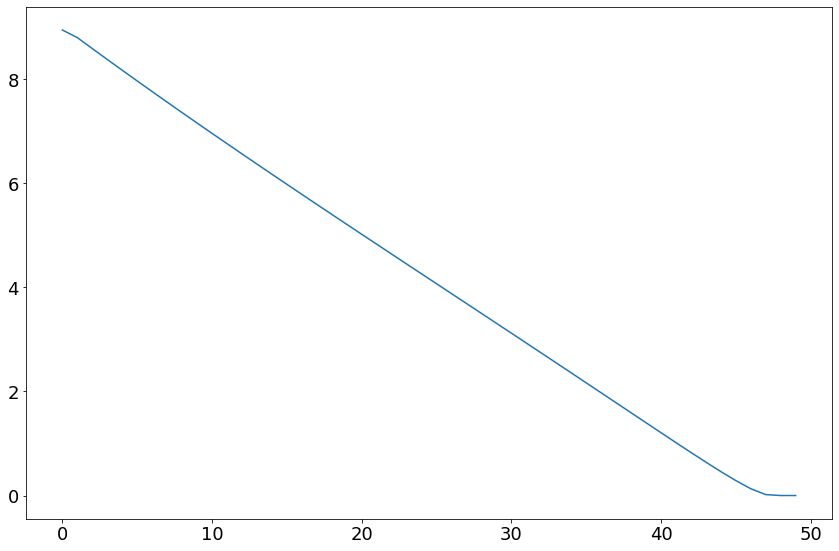

In [255]:
plt.plot(e_grid_5[25])

# Consider model ambiguity

In [211]:
def hjb_modified_ambiguity(z_grid, y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000,
                                 use_python=False, bc=None, impose_bc=None):
    η, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o = model_paras
    
    Δ_z = z_grid[1] - z_grid[0]
    Δ_y = y_grid[1] - y_grid[0]
    (z_mat, y_mat) = np.meshgrid(z_grid, y_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])
    if v0 is None:
        v0 = -δ*η*y_mat*z_mat
    
    d_Λ =  λ_1 + λ_2*y_mat + λ_2p*(y_mat>λ_bar)*(y_mat-λ_bar)
    d_Λ_z = d_Λ * z_mat

    π = np.ones((len(μ_2), z_mat.shape[0], z_mat.shape[1]))
    μ_2_new = np.ones_like(π)
    for i in range(π.shape[0]):
        π[i] = π_o[i]
        μ_2_new[i] = μ_2[i]
    π_o = π.copy()
    μ_2 = μ_2_new

    mean = - ρ*(z_mat-μ_2)
    std = np.sqrt(z_mat)*σ_2
    var = std**2/2.
    e = - δ*η / ((η-1)*d_Λ_z)
    e_old = e.copy()

    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives_2d(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives_2d(v0, 0, 2, Δ_z)
        v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)
        
        log_π_ratio = -(v0_dz*ρ*μ_2)/ξ_a
        π_ratio = log_π_ratio - np.max(log_π_ratio, axis=0)
        π = np.exp(π_ratio) * π_o
        π = π/np.sum(π, axis=0)
        π[π<=0] = 1e-12

        e_new = - δ*η / (v0_dy*z_mat + (η-1)*d_Λ_z)
        e_new[e_new<=0] = 1e-12
        e = e_new * 0.5 + e_old * 0.5
        e_old = e.copy()

        A = np.ones_like(z_mat)*(-δ)
        B_z = np.sum(π*mean, axis=0)
        B_y = z_mat*e
        C_zz = var
        C_yy = np.zeros_like(z_mat)
        D = δ*η*np.log(e) + (η-1)*d_Λ_z*e \
            + ξ_a*np.sum(π*(np.log(π)-np.log(π_o)), axis=0)
        if use_python:
            v0 = false_transient_one_iteration_python(A, B_z, B_y, C_zz, C_yy, D, v0, ε, Δ_z, Δ_y, bc, impose_bc)
        else:
            v0 = false_transient_one_iteration_cpp(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ε)

        rhs_error = A*v0 + B_z*v0_dz + B_y*v0_dy + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    return v0, e, π

In [212]:
def compute_prob(μ_2_state, λ_2p_state, λ_2p_prior):
    λ_2p = np.zeros(λ_2p_state.shape[0]*μ_2_state.shape[0])
    μ_2 = np.zeros_like(λ_2p)
    π_o = np.zeros_like(λ_2p)
    for i in range(λ_2p_state.shape[0]):
        for j in range(μ_2_state.shape[0]):
            idx = i*μ_2_state.shape[0] + j
            λ_2p[idx] = λ_2p_state[i]
            μ_2[idx] = μ_2_state[j]
            π_o[idx] = 1./len(μ_2_state)
    return μ_2, λ_2p, π_o

In [213]:
def compute_prob_climate(μ_2_state):
    μ_2 = np.zeros(μ_2_state.shape[0])
    π_o = np.zeros(μ_2_state.shape[0])
    for j in range(μ_2_state.shape[0]):
        μ_2[j] = μ_2_state[j]
        π_o[j] = 1./len(μ_2_state)
    return μ_2, π_o

In [256]:
σ_2 = np.sqrt(2*ρ/10416.29)
σ_2

0.013145579054341883

In [214]:
μ_2 = 1.86/1000
σ_2 = np.sqrt(2*ρ/10416.29)/3
ξ_a = 1000
n_z = 50
z_min = np.max([μ_2 - 3*np.sqrt(σ_2**2*μ_2/(2*ρ)), 1e-9])
z_max = μ_2 + 3*np.sqrt(σ_2**2*μ_2/(2*ρ))
z_grid = np.linspace(z_min, z_max, n_z)

n_y = 50
y_min = 1e-10
y_max = 10
y_grid = np.linspace(y_min, y_max, n_y)

# three damage
λ_2p_state = np.array([0., 0.0197*2, 0.3853*2])
λ_2p_prior = np.array([0.4875, 0.4875, 0.025])
μ_2_state = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.

μ_2, π_o = compute_prob_climate(μ_2_state)
pde_paras = (η, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o)
# Solve for each damage function

ϕ_state = []
e_state = []
π_state = []
for λ_2p in λ_2p_state:
    pde_paras = (η, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o)
    ϕ, e, π = hjb_modified_ambiguity(z_grid, y_grid, model_paras=pde_paras, v0=None,
                           ϵ=.5, tol=1e-8, max_iter=10_000, use_python=False)
    ϕ_state.append(ϕ)
    e_state.append(e)
    π_state.append(π)

Iteration 1: LHS Error: 0.0013843244190874177; RHS Error 0.0019669412560382885
Iteration 2: LHS Error: 0.001260747929405758; RHS Error 0.0015339366534440747
Iteration 3: LHS Error: 0.0012072930327589092; RHS Error 0.0014015826022085397
Iteration 4: LHS Error: 0.0011702902353600219; RHS Error 0.001315585042563881
Iteration 5: LHS Error: 0.0011382327255366675; RHS Error 0.0012469156270648136
Iteration 6: LHS Error: 0.0011076521983972593; RHS Error 0.0011890446240632499
Iteration 7: LHS Error: 0.0010778357190908139; RHS Error 0.00113935746847868
Iteration 8: LHS Error: 0.001049097069500994; RHS Error 0.0010963899663572966
Iteration 9: LHS Error: 0.0010219317071581517; RHS Error 0.0010590918127720323
Iteration 10: LHS Error: 0.0009966620967370669; RHS Error 0.0010265716932485961
Iteration 11: LHS Error: 0.0009733755941670301; RHS Error 0.0009980308747874938
Iteration 12: LHS Error: 0.0009519866588361195; RHS Error 0.0009727656025741392
Iteration 13: LHS Error: 0.0009323191515774251; RHS Er

Iteration 107: LHS Error: 0.0003690298438025208; RHS Error 0.0003699893938913861
Iteration 108: LHS Error: 0.0003662566899967912; RHS Error 0.0003672029966659959
Iteration 109: LHS Error: 0.0003635101265524743; RHS Error 0.00036444345212851886
Iteration 110: LHS Error: 0.0003607897714487107; RHS Error 0.0003617103734240546
Iteration 111: LHS Error: 0.0003580952501768542; RHS Error 0.0003590033770389155
Iteration 112: LHS Error: 0.00035542619829066757; RHS Error 0.000356322090753568
Iteration 113: LHS Error: 0.00035278225293840226; RHS Error 0.000353666152184881
Iteration 114: LHS Error: 0.00035016306927775076; RHS Error 0.0003510352005410785
Iteration 115: LHS Error: 0.00034756830572142683; RHS Error 0.00034842889321018444
Iteration 116: LHS Error: 0.00034499762614559337; RHS Error 0.00034584688791558917
Iteration 117: LHS Error: 0.00034245070421029533; RHS Error 0.00034328884978063494
Iteration 118: LHS Error: 0.0003399272190742486; RHS Error 0.00034075445535587526
Iteration 119: LHS 

Iteration 209: LHS Error: 0.00018029374630082473; RHS Error 0.00018060024391493225
Iteration 210: LHS Error: 0.00017909510105550142; RHS Error 0.00017939871601078223
Iteration 211: LHS Error: 0.00017790524753524828; RHS Error 0.0001782060108516105
Iteration 212: LHS Error: 0.0001767241093672961; RHS Error 0.0001770220544972497
Iteration 213: LHS Error: 0.0001755516107891375; RHS Error 0.0001758467705000545
Iteration 214: LHS Error: 0.00017438767714129944; RHS Error 0.00017468008356859549
Iteration 215: LHS Error: 0.0001732322344772247; RHS Error 0.00017352192075950157
Iteration 216: LHS Error: 0.0001720852096896014; RHS Error 0.0001723722046254138
Iteration 217: LHS Error: 0.00017094653045822417; RHS Error 0.00017123086577206566
Iteration 218: LHS Error: 0.00016981612532000756; RHS Error 0.00017009783096899806
Iteration 219: LHS Error: 0.000168693923592117; RHS Error 0.00016897303091798366
Iteration 220: LHS Error: 0.0001675798553202601; RHS Error 0.00016785639255638028
Iteration 221: 

Iteration 311: LHS Error: 9.302085759771428e-05; RHS Error 9.314782138363279e-05
Iteration 312: LHS Error: 9.243282013110532e-05; RHS Error 9.255877128240054e-05
Iteration 313: LHS Error: 9.184870592696126e-05; RHS Error 9.197365295532205e-05
Iteration 314: LHS Error: 9.126848647228458e-05; RHS Error 9.139243920319262e-05
Iteration 315: LHS Error: 9.069213709098078e-05; RHS Error 9.081510055218502e-05
Iteration 316: LHS Error: 9.01196230116974e-05; RHS Error 9.024160554382951e-05
Iteration 317: LHS Error: 8.955091820266048e-05; RHS Error 8.967193778322655e-05
Iteration 318: LHS Error: 8.898599630348392e-05; RHS Error 8.910606203653903e-05
Iteration 319: LHS Error: 8.842482977118593e-05; RHS Error 8.854394654090084e-05
Iteration 320: LHS Error: 8.786739118808728e-05; RHS Error 8.798556856522816e-05
Iteration 321: LHS Error: 8.731365378948641e-05; RHS Error 8.743089830378682e-05
Iteration 322: LHS Error: 8.676359031926928e-05; RHS Error 8.687990821978073e-05
Iteration 323: LHS Error: 8.6

Iteration 413: LHS Error: 4.9189875301614006e-05; RHS Error 4.924822982051906e-05
Iteration 414: LHS Error: 4.888756373014336e-05; RHS Error 4.894549404628251e-05
Iteration 415: LHS Error: 4.8587176104661345e-05; RHS Error 4.864468461562095e-05
Iteration 416: LHS Error: 4.828869831652316e-05; RHS Error 4.834578921422239e-05
Iteration 417: LHS Error: 4.799211621032973e-05; RHS Error 4.804879263991559e-05
Iteration 418: LHS Error: 4.76974199311031e-05; RHS Error 4.775368735504212e-05
Iteration 419: LHS Error: 4.740459539691322e-05; RHS Error 4.7460454718551695e-05
Iteration 420: LHS Error: 4.7113629616526986e-05; RHS Error 4.7169084023750206e-05
Iteration 421: LHS Error: 4.6824511045290285e-05; RHS Error 4.687956203069672e-05
Iteration 422: LHS Error: 4.6537227242390844e-05; RHS Error 4.659188170991733e-05
Iteration 423: LHS Error: 4.625176534675535e-05; RHS Error 4.630602183903576e-05
Iteration 424: LHS Error: 4.596811343286766e-05; RHS Error 4.602197920989561e-05
Iteration 425: LHS Err

Iteration 516: LHS Error: 2.622799303458878e-05; RHS Error 2.6256142796134618e-05
Iteration 517: LHS Error: 2.606971831664584e-05; RHS Error 2.6097675448135023e-05
Iteration 518: LHS Error: 2.5912421766416394e-05; RHS Error 2.5940188005623126e-05
Iteration 519: LHS Error: 2.5756096711446186e-05; RHS Error 2.5783672695914306e-05
Iteration 520: LHS Error: 2.5600737092401626e-05; RHS Error 2.5628123567037007e-05
Iteration 521: LHS Error: 2.5446336608128672e-05; RHS Error 2.5473535944449443e-05
Iteration 522: LHS Error: 2.5292889551470354e-05; RHS Error 2.531990283938918e-05
Iteration 523: LHS Error: 2.5140389512387507e-05; RHS Error 2.516721823364208e-05
Iteration 524: LHS Error: 2.4988830259559114e-05; RHS Error 2.5015475593956555e-05
Iteration 525: LHS Error: 2.4838205647789713e-05; RHS Error 2.48646685701414e-05
Iteration 526: LHS Error: 2.468850993657401e-05; RHS Error 2.4714792364516997e-05
Iteration 527: LHS Error: 2.4539737642326198e-05; RHS Error 2.456584084964712e-05
Iteration 52

Iteration 620: LHS Error: 1.4034349860678197e-05; RHS Error 1.4048352694658972e-05
Iteration 621: LHS Error: 1.3950724121525315e-05; RHS Error 1.3964636142842712e-05
Iteration 622: LHS Error: 1.3867605331618904e-05; RHS Error 1.388142568144277e-05
Iteration 623: LHS Error: 1.3784989710649564e-05; RHS Error 1.379871990387705e-05
Iteration 624: LHS Error: 1.370287480767507e-05; RHS Error 1.3716514588270638e-05
Iteration 625: LHS Error: 1.3621257847470924e-05; RHS Error 1.3634808315222588e-05
Iteration 626: LHS Error: 1.3540134298647977e-05; RHS Error 1.3553595074917318e-05
Iteration 627: LHS Error: 1.345950229807158e-05; RHS Error 1.3472874271192167e-05
Iteration 628: LHS Error: 1.337935798528811e-05; RHS Error 1.3392642188941764e-05
Iteration 629: LHS Error: 1.3299699478899751e-05; RHS Error 1.3312897661387412e-05
Iteration 630: LHS Error: 1.3220522917356536e-05; RHS Error 1.3233634918843819e-05
Iteration 631: LHS Error: 1.3141825154383557e-05; RHS Error 1.3154850129059844e-05
Iteration

Iteration 725: LHS Error: 7.5153860361887315e-06; RHS Error 7.522485976355986e-06
Iteration 726: LHS Error: 7.471008209566921e-06; RHS Error 7.478062746042952e-06
Iteration 727: LHS Error: 7.426895909420916e-06; RHS Error 7.433905142258178e-06
Iteration 728: LHS Error: 7.383046960421358e-06; RHS Error 7.390011392278094e-06
Iteration 729: LHS Error: 7.339460274091714e-06; RHS Error 7.3463798643566385e-06
Iteration 730: LHS Error: 7.2961343417082825e-06; RHS Error 7.303010766835185e-06
Iteration 731: LHS Error: 7.253067243029321e-06; RHS Error 7.259898892995431e-06
Iteration 732: LHS Error: 7.2102560511322356e-06; RHS Error 7.217044884727454e-06
Iteration 733: LHS Error: 7.167701722349262e-06; RHS Error 7.174447928088483e-06
Iteration 734: LHS Error: 7.125401379204366e-06; RHS Error 7.132105365440303e-06
Iteration 735: LHS Error: 7.083352999079362e-06; RHS Error 7.090013147343635e-06
Iteration 736: LHS Error: 7.041556317768927e-06; RHS Error 7.048174909431398e-06
Iteration 737: LHS Error

Iteration 831: LHS Error: 4.020128828940983e-06; RHS Error 4.023877611121821e-06
Iteration 832: LHS Error: 3.996544027454196e-06; RHS Error 4.000269686362098e-06
Iteration 833: LHS Error: 3.973097813428361e-06; RHS Error 3.976800268316611e-06
Iteration 834: LHS Error: 3.949791012897164e-06; RHS Error 3.953470511089299e-06
Iteration 835: LHS Error: 3.9266223856443405e-06; RHS Error 3.930279280267178e-06
Iteration 836: LHS Error: 3.903590226311815e-06; RHS Error 3.90722379770708e-06
Iteration 837: LHS Error: 3.880694700114651e-06; RHS Error 3.8843053888934324e-06
Iteration 838: LHS Error: 3.857934572290556e-06; RHS Error 3.8615234557328295e-06
Iteration 839: LHS Error: 3.8353091572906894e-06; RHS Error 3.838875289308521e-06
Iteration 840: LHS Error: 3.812817506804178e-06; RHS Error 3.816362358606464e-06
Iteration 841: LHS Error: 3.790459009805902e-06; RHS Error 3.7939813303081204e-06
Iteration 842: LHS Error: 3.768232773995739e-06; RHS Error 3.7717335717055113e-06
Iteration 843: LHS Erro

Iteration 935: LHS Error: 2.183287143742163e-06; RHS Error 2.9379120521680043e-06
Iteration 936: LHS Error: 2.170534649639788e-06; RHS Error 2.9504728822605207e-06
Iteration 937: LHS Error: 2.157857688353526e-06; RHS Error 2.9629466990222517e-06
Iteration 938: LHS Error: 2.1452555008655283e-06; RHS Error 2.975350137505257e-06
Iteration 939: LHS Error: 2.132727891748787e-06; RHS Error 2.987683820580866e-06
Iteration 940: LHS Error: 2.1202731935870966e-06; RHS Error 2.9999463526921228e-06
Iteration 941: LHS Error: 2.107892041344761e-06; RHS Error 3.0121372169679764e-06
Iteration 942: LHS Error: 2.095583685524094e-06; RHS Error 3.024256240758338e-06
Iteration 943: LHS Error: 2.083347602932495e-06; RHS Error 3.03630554323339e-06
Iteration 944: LHS Error: 2.0711835678477453e-06; RHS Error 3.0482826446317276e-06
Iteration 945: LHS Error: 2.0590908579448675e-06; RHS Error 3.0601904319419587e-06
Iteration 946: LHS Error: 2.0470687019935596e-06; RHS Error 3.072028022116759e-06
Iteration 947: LH

Iteration 1039: LHS Error: 1.1884137451761978e-06; RHS Error 3.9175689997190694e-06
Iteration 1040: LHS Error: 1.1814911612950674e-06; RHS Error 3.924391952076249e-06
Iteration 1041: LHS Error: 1.1746092572206823e-06; RHS Error 3.9311667167837025e-06
Iteration 1042: LHS Error: 1.1677672249466031e-06; RHS Error 3.937905523235035e-06
Iteration 1043: LHS Error: 1.1609655936745122e-06; RHS Error 3.94460762642994e-06
Iteration 1044: LHS Error: 1.1542040067175074e-06; RHS Error 3.951267706732951e-06
Iteration 1045: LHS Error: 1.1474812948858437e-06; RHS Error 3.957889474464856e-06
Iteration 1046: LHS Error: 1.1407990914286126e-06; RHS Error 3.9644719727492585e-06
Iteration 1047: LHS Error: 1.134155147172744e-06; RHS Error 3.9710120595031016e-06
Iteration 1048: LHS Error: 1.1275501377305819e-06; RHS Error 3.977517844956429e-06
Iteration 1049: LHS Error: 1.1209836586756339e-06; RHS Error 3.9839884116119354e-06
Iteration 1050: LHS Error: 1.1144565447429589e-06; RHS Error 3.990414685827825e-06
I

Iteration 1143: LHS Error: 6.477641504021303e-07; RHS Error 4.45016766776414e-06
Iteration 1144: LHS Error: 6.439986712375445e-07; RHS Error 4.453877779162581e-06
Iteration 1145: LHS Error: 6.402553146267476e-07; RHS Error 4.457563514789005e-06
Iteration 1146: LHS Error: 6.365329150298527e-07; RHS Error 4.461222431326596e-06
Iteration 1147: LHS Error: 6.32832728872379e-07; RHS Error 4.4648724252826545e-06
Iteration 1148: LHS Error: 6.291532188701376e-07; RHS Error 4.468500025833983e-06
Iteration 1149: LHS Error: 6.254970400243476e-07; RHS Error 4.472106863220794e-06
Iteration 1150: LHS Error: 6.218605558688806e-07; RHS Error 4.475678718435716e-06
Iteration 1151: LHS Error: 6.18245177358423e-07; RHS Error 4.4792396577163565e-06
Iteration 1152: LHS Error: 6.146519916511162e-07; RHS Error 4.482785174777289e-06
Iteration 1153: LHS Error: 6.110787471175216e-07; RHS Error 4.486311212336118e-06
Iteration 1154: LHS Error: 6.075268810107337e-07; RHS Error 4.489809074166595e-06
Iteration 1155: L

Iteration 1249: LHS Error: 3.4929252136495226e-07; RHS Error 4.7442699363286e-06
Iteration 1250: LHS Error: 3.4722719638446975e-07; RHS Error 4.746286713859277e-06
Iteration 1251: LHS Error: 3.451980421648182e-07; RHS Error 4.748283821112611e-06
Iteration 1252: LHS Error: 3.4318607784744604e-07; RHS Error 4.750264025105144e-06
Iteration 1253: LHS Error: 3.4118832144269806e-07; RHS Error 4.752230637422041e-06
Iteration 1254: LHS Error: 3.3920332329073766e-07; RHS Error 4.754186464451995e-06
Iteration 1255: LHS Error: 3.372313298610763e-07; RHS Error 4.75613012587044e-06
Iteration 1256: LHS Error: 3.352707822479317e-07; RHS Error 4.7580615546954745e-06
Iteration 1257: LHS Error: 3.3332184425083344e-07; RHS Error 4.759982904567104e-06
Iteration 1258: LHS Error: 3.3138436322799336e-07; RHS Error 4.761892993641209e-06
Iteration 1259: LHS Error: 3.294581667895313e-07; RHS Error 4.76379090000843e-06
Iteration 1260: LHS Error: 3.275430192628548e-07; RHS Error 4.7656776568560846e-06
Iteration 1

Iteration 1357: LHS Error: 1.8609054748541798e-07; RHS Error 4.905024702871403e-06
Iteration 1358: LHS Error: 1.8500658478803889e-07; RHS Error 4.9060931298315884e-06
Iteration 1359: LHS Error: 1.8392882754347806e-07; RHS Error 4.9071558032039555e-06
Iteration 1360: LHS Error: 1.8285722834521234e-07; RHS Error 4.908211729997007e-06
Iteration 1361: LHS Error: 1.817918182100975e-07; RHS Error 4.90926229855537e-06
Iteration 1362: LHS Error: 1.8073243306104825e-07; RHS Error 4.910306230133596e-06
Iteration 1363: LHS Error: 1.7967940091345724e-07; RHS Error 4.91134402936719e-06
Iteration 1364: LHS Error: 1.7863236678739014e-07; RHS Error 4.912375913516498e-06
Iteration 1365: LHS Error: 1.775914292845293e-07; RHS Error 4.913401202961097e-06
Iteration 1366: LHS Error: 1.765566443462374e-07; RHS Error 4.914421560461629e-06
Iteration 1367: LHS Error: 1.7552787180685758e-07; RHS Error 4.915433944388428e-06
Iteration 1368: LHS Error: 1.7450502083626862e-07; RHS Error 4.916442302499847e-06
Iterati

Iteration 1457: LHS Error: 1.0420283851064749e-07; RHS Error 4.986112693495712e-06
Iteration 1458: LHS Error: 1.0339178055374099e-07; RHS Error 4.986822382342573e-06
Iteration 1459: LHS Error: 1.0268566587312566e-07; RHS Error 4.9874610118592465e-06
Iteration 1460: LHS Error: 1.0203183668788807e-07; RHS Error 4.9880643907254316e-06
Iteration 1461: LHS Error: 1.0141072709357601e-07; RHS Error 4.988655025346938e-06
Iteration 1462: LHS Error: 1.0080451348648545e-07; RHS Error 4.989239083470309e-06
Iteration 1463: LHS Error: 1.0083562371199228e-07; RHS Error 4.989816950192231e-06
Iteration 1464: LHS Error: 9.96573840950088e-08; RHS Error 4.990521598498515e-06
Iteration 1465: LHS Error: 9.94859799680059e-08; RHS Error 4.990858546131396e-06
Iteration 1466: LHS Error: 9.850279880652124e-08; RHS Error 4.9916372071853255e-06
Iteration 1467: LHS Error: 9.827245397997508e-08; RHS Error 4.991995383228621e-06
Iteration 1468: LHS Error: 9.735398390220418e-08; RHS Error 4.992766498345042e-06
Iteratio

Iteration 1557: LHS Error: 5.774039038564105e-08; RHS Error 5.031539983268779e-06
Iteration 1558: LHS Error: 5.7402480074797424e-08; RHS Error 5.031871771288255e-06
Iteration 1559: LHS Error: 5.7068219927458586e-08; RHS Error 5.032201874959866e-06
Iteration 1560: LHS Error: 5.673519523630155e-08; RHS Error 5.032529647786325e-06
Iteration 1561: LHS Error: 5.640359748704249e-08; RHS Error 5.0328586601567325e-06
Iteration 1562: LHS Error: 5.607443306909765e-08; RHS Error 5.033180218361167e-06
Iteration 1563: LHS Error: 5.574727240942323e-08; RHS Error 5.033504412026678e-06
Iteration 1564: LHS Error: 5.542170923578116e-08; RHS Error 5.033825250298101e-06
Iteration 1565: LHS Error: 5.509822395555197e-08; RHS Error 5.0341429013842e-06
Iteration 1566: LHS Error: 5.4776071845008545e-08; RHS Error 5.034460977162373e-06
Iteration 1567: LHS Error: 5.445603606935023e-08; RHS Error 5.034775436150085e-06
Iteration 1568: LHS Error: 5.413820232391675e-08; RHS Error 5.035088195686562e-06
Iteration 1569

Iteration 1665: LHS Error: 3.057933514738487e-08; RHS Error 5.0582640507243785e-06
Iteration 1666: LHS Error: 3.039989977804414e-08; RHS Error 5.058440314739915e-06
Iteration 1667: LHS Error: 3.022121558560187e-08; RHS Error 5.058616602075881e-06
Iteration 1668: LHS Error: 3.0322139285554606e-08; RHS Error 5.058791640096959e-06
Iteration 1669: LHS Error: 2.990739705888146e-08; RHS Error 5.05893327952566e-06
Iteration 1670: LHS Error: 2.986027829166016e-08; RHS Error 5.059170091662943e-06
Iteration 1671: LHS Error: 2.957438725859074e-08; RHS Error 5.059285815397791e-06
Iteration 1672: LHS Error: 2.9489667000004438e-08; RHS Error 5.059510989740938e-06
Iteration 1673: LHS Error: 2.9238361745620445e-08; RHS Error 5.059622258882517e-06
Iteration 1674: LHS Error: 2.9142288721084597e-08; RHS Error 5.059844770994226e-06
Iteration 1675: LHS Error: 2.8903116774947613e-08; RHS Error 5.059954480141158e-06
Iteration 1676: LHS Error: 2.880375712943639e-08; RHS Error 5.060175814243788e-06
Iteration 1

Iteration 1776: LHS Error: 1.576261043911842e-08; RHS Error 5.0726973674480305e-06
Iteration 1777: LHS Error: 1.5675933912051576e-08; RHS Error 5.072790752457933e-06
Iteration 1778: LHS Error: 1.558721682282105e-08; RHS Error 5.072879807248927e-06
Iteration 1779: LHS Error: 1.5504701494917228e-08; RHS Error 5.072969260687616e-06
Iteration 1780: LHS Error: 1.5417029278208538e-08; RHS Error 5.0730565973593645e-06
Iteration 1781: LHS Error: 1.5327719413149588e-08; RHS Error 5.073148303390588e-06
Iteration 1782: LHS Error: 1.5244522741375555e-08; RHS Error 5.073235925883834e-06
Iteration 1783: LHS Error: 1.5155510152409235e-08; RHS Error 5.073322806091831e-06
Iteration 1784: LHS Error: 1.5069198194828104e-08; RHS Error 5.073409812590517e-06
Iteration 1785: LHS Error: 1.4983276327984463e-08; RHS Error 5.073497066817364e-06
Iteration 1786: LHS Error: 1.4898029851440064e-08; RHS Error 5.073583656349024e-06
Iteration 1787: LHS Error: 1.4812432835853429e-08; RHS Error 5.073668082682678e-06
Iter

Iteration 23: LHS Error: 0.0007930761131139906; RHS Error 0.0008003671431854084
Iteration 24: LHS Error: 0.0007825480656261548; RHS Error 0.0007894392498924178
Iteration 25: LHS Error: 0.0007723958993913344; RHS Error 0.000778930685928189
Iteration 26: LHS Error: 0.0007625863085343881; RHS Error 0.0007688014786120762
Iteration 27: LHS Error: 0.0007530903989260429; RHS Error 0.0007590173749026352
Iteration 28: LHS Error: 0.0007438829340220936; RHS Error 0.0007495487833515961
Iteration 29: LHS Error: 0.0007349417235180018; RHS Error 0.0007403699537974769
Iteration 30: LHS Error: 0.0007262472036967706; RHS Error 0.0007314583320521437
Iteration 31: LHS Error: 0.0007177819458070306; RHS Error 0.0007227940341524761
Iteration 32: LHS Error: 0.0007095304150456852; RHS Error 0.0007143594294426855
Iteration 33: LHS Error: 0.0007014786835414996; RHS Error 0.0007061388145046774
Iteration 34: LHS Error: 0.0006936142150531441; RHS Error 0.0006981181333670147
Iteration 35: LHS Error: 0.00068592568173

Iteration 129: LHS Error: 0.0002874211624480233; RHS Error 0.0002876311510942959
Iteration 130: LHS Error: 0.0002860005355582104; RHS Error 0.0002862105726444095
Iteration 131: LHS Error: 0.00028458693010665476; RHS Error 0.00028479701368557166
Iteration 132: LHS Error: 0.0002831803165560323; RHS Error 0.00028339044116049904
Iteration 133: LHS Error: 0.00028178064498000227; RHS Error 0.0002819908220476129
Iteration 134: LHS Error: 0.00028038789414411985; RHS Error 0.0002805981119569914
Iteration 135: LHS Error: 0.0002790020252569844; RHS Error 0.0002792122938360947
Iteration 136: LHS Error: 0.00027762300548332675; RHS Error 0.00027783331658222697
Iteration 137: LHS Error: 0.000276250797140741; RHS Error 0.000276461161676987
Iteration 138: LHS Error: 0.000274885373315617; RHS Error 0.0002750957809119094
Iteration 139: LHS Error: 0.00027352669708607946; RHS Error 0.0002737371514164509
Iteration 140: LHS Error: 0.0002721747363398294; RHS Error 0.0002723852347418428
Iteration 141: LHS Erro

Iteration 231: LHS Error: 0.00017338728514064428; RHS Error 0.00017360106671664502
Iteration 232: LHS Error: 0.00017253022782311167; RHS Error 0.00017274403582270105
Iteration 233: LHS Error: 0.00017167740468858328; RHS Error 0.00017189124090851912
Iteration 234: LHS Error: 0.00017082879743278434; RHS Error 0.00017104266120221634
Iteration 235: LHS Error: 0.00016998446248908672; RHS Error 0.00017019827524406667
Iteration 236: LHS Error: 0.000169144210695249; RHS Error 0.00016935812410695907
Iteration 237: LHS Error: 0.00016830811954748892; RHS Error 0.00016852206537364616
Iteration 238: LHS Error: 0.0001674761596283797; RHS Error 0.00016769013627513795
Iteration 239: LHS Error: 0.0001666483120231349; RHS Error 0.00016686231501346463
Iteration 240: LHS Error: 0.00016582455603664226; RHS Error 0.00016603858662678445
Iteration 241: LHS Error: 0.00016500504973322727; RHS Error 0.00016521892909452664
Iteration 242: LHS Error: 0.00016418924817300506; RHS Error 0.00016440326447818429
Iteratio

Iteration 336: LHS Error: 0.00010304900861514421; RHS Error 0.00010326509554325165
Iteration 337: LHS Error: 0.00010253959793360412; RHS Error 0.00010275570220906222
Iteration 338: LHS Error: 0.00010203270653061369; RHS Error 0.00010224882654235077
Iteration 339: LHS Error: 0.00010152831958532005; RHS Error 0.00010174445653195907
Iteration 340: LHS Error: 0.00010102642701831366; RHS Error 0.00010124257923254374
Iteration 341: LHS Error: 0.00010052701307798617; RHS Error 0.0001007431826679053
Iteration 342: LHS Error: 0.00010003006865126618; RHS Error 0.00010024625535732005
Iteration 343: LHS Error: 9.953558087252845e-05; RHS Error 9.975178305057883e-05
Iteration 344: LHS Error: 9.904353630570129e-05; RHS Error 9.92597555056302e-05
Iteration 345: LHS Error: 9.855392515839556e-05; RHS Error 9.877015981995613e-05
Iteration 346: LHS Error: 9.806673218168416e-05; RHS Error 9.828298435469486e-05
Iteration 347: LHS Error: 9.758194919307073e-05; RHS Error 9.779821630728075e-05
Iteration 348: L

Iteration 441: LHS Error: 6.124284676528591e-05; RHS Error 6.146028487978317e-05
Iteration 442: LHS Error: 6.0940082381014116e-05; RHS Error 6.11575301373522e-05
Iteration 443: LHS Error: 6.063881276857641e-05; RHS Error 6.085627171069927e-05
Iteration 444: LHS Error: 6.033903259505813e-05; RHS Error 6.055650108742223e-05
Iteration 445: LHS Error: 6.004073422925804e-05; RHS Error 6.025821373776885e-05
Iteration 446: LHS Error: 5.9743905540865505e-05; RHS Error 5.9961399092707535e-05
Iteration 447: LHS Error: 5.944855561708373e-05; RHS Error 5.9666050668442364e-05
Iteration 448: LHS Error: 5.915465752936999e-05; RHS Error 5.9372166242503026e-05
Iteration 449: LHS Error: 5.8862213011920406e-05; RHS Error 5.907973215938181e-05
Iteration 450: LHS Error: 5.85712101254382e-05; RHS Error 5.878874242955744e-05
Iteration 451: LHS Error: 5.828165237230232e-05; RHS Error 5.8499189624169174e-05
Iteration 452: LHS Error: 5.799352491565879e-05; RHS Error 5.821107264614855e-05
Iteration 453: LHS Erro

Iteration 547: LHS Error: 3.6215892844512765e-05; RHS Error 3.6434125177764595e-05
Iteration 548: LHS Error: 3.603684170105925e-05; RHS Error 3.625508070676398e-05
Iteration 549: LHS Error: 3.5858676401698264e-05; RHS Error 3.6076921160728e-05
Iteration 550: LHS Error: 3.568139213303012e-05; RHS Error 3.589964185645578e-05
Iteration 551: LHS Error: 3.550498381944822e-05; RHS Error 3.57232389245069e-05
Iteration 552: LHS Error: 3.5329447665599645e-05; RHS Error 3.5547709230209965e-05
Iteration 553: LHS Error: 3.515477460797056e-05; RHS Error 3.537304577495436e-05
Iteration 554: LHS Error: 3.498097047330284e-05; RHS Error 3.519925049721485e-05
Iteration 555: LHS Error: 3.480802450568643e-05; RHS Error 3.50263051071699e-05
Iteration 556: LHS Error: 3.463593395933162e-05; RHS Error 3.4854217391914e-05
Iteration 557: LHS Error: 3.4464693920613354e-05; RHS Error 3.468298152084368e-05
Iteration 558: LHS Error: 3.429430041744508e-05; RHS Error 3.451259218187466e-05
Iteration 559: LHS Error: 3.

Iteration 651: LHS Error: 2.1628901082093588e-05; RHS Error 2.1847600022136438e-05
Iteration 652: LHS Error: 2.152196514189353e-05; RHS Error 2.174066543323658e-05
Iteration 653: LHS Error: 2.14155584780662e-05; RHS Error 2.1634258876583503e-05
Iteration 654: LHS Error: 2.13096756216391e-05; RHS Error 2.1528378694114954e-05
Iteration 655: LHS Error: 2.120431614267837e-05; RHS Error 2.1423023119455692e-05
Iteration 656: LHS Error: 2.1099479288397283e-05; RHS Error 2.1318186796816826e-05
Iteration 657: LHS Error: 2.0995159210904224e-05; RHS Error 2.1213873032113197e-05
Iteration 658: LHS Error: 2.089135510505158e-05; RHS Error 2.11100727294155e-05
Iteration 659: LHS Error: 2.0788063576734905e-05; RHS Error 2.100678615238132e-05
Iteration 660: LHS Error: 2.068528383923629e-05; RHS Error 2.090400994744318e-05
Iteration 661: LHS Error: 2.058301159447995e-05; RHS Error 2.080173976136396e-05
Iteration 662: LHS Error: 2.0481243864625687e-05; RHS Error 2.0699978503929412e-05
Iteration 663: LHS 

Iteration 754: LHS Error: 1.2981041858026177e-05; RHS Error 1.3200038584209716e-05
Iteration 755: LHS Error: 1.2916854531155875e-05; RHS Error 1.3135853282391036e-05
Iteration 756: LHS Error: 1.2852985251748938e-05; RHS Error 1.307198508599983e-05
Iteration 757: LHS Error: 1.2789431827045505e-05; RHS Error 1.3053040238729624e-05
Iteration 758: LHS Error: 1.2726192424497573e-05; RHS Error 1.305842671194728e-05
Iteration 759: LHS Error: 1.2663266771253956e-05; RHS Error 1.3063822315381593e-05
Iteration 760: LHS Error: 1.260065022978818e-05; RHS Error 1.3069230323903822e-05
Iteration 761: LHS Error: 1.2538345014009855e-05; RHS Error 1.3074640975977879e-05
Iteration 762: LHS Error: 1.247634632904615e-05; RHS Error 1.3080067618887544e-05
Iteration 763: LHS Error: 1.2414654994283292e-05; RHS Error 1.3085494969530234e-05
Iteration 764: LHS Error: 1.2353268733597544e-05; RHS Error 1.3090934146735658e-05
Iteration 765: LHS Error: 1.229218586033809e-05; RHS Error 1.3096380805290822e-05
Iteration

Iteration 858: LHS Error: 7.75207537781486e-06; RHS Error 1.3608066998457369e-05
Iteration 859: LHS Error: 7.71374251545831e-06; RHS Error 1.3613385811240587e-05
Iteration 860: LHS Error: 7.67559929924777e-06; RHS Error 1.361869585473545e-05
Iteration 861: LHS Error: 7.637644651725672e-06; RHS Error 1.3623999612246643e-05
Iteration 862: LHS Error: 7.599877145214595e-06; RHS Error 1.362929505952426e-05
Iteration 863: LHS Error: 7.56229700121791e-06; RHS Error 1.363458264718538e-05
Iteration 864: LHS Error: 7.524902468802885e-06; RHS Error 1.363986271172104e-05
Iteration 865: LHS Error: 7.487693177085641e-06; RHS Error 1.3645134905734217e-05
Iteration 866: LHS Error: 7.450667755079521e-06; RHS Error 1.3650398003489791e-05
Iteration 867: LHS Error: 7.413824850505124e-06; RHS Error 1.3655653550062488e-05
Iteration 868: LHS Error: 7.3771643238351725e-06; RHS Error 1.3660900047399432e-05
Iteration 869: LHS Error: 7.3406853080826284e-06; RHS Error 1.3666138855636585e-05
Iteration 870: LHS Err

Iteration 964: LHS Error: 4.583571036095857e-06; RHS Error 1.4118486822441601e-05
Iteration 965: LHS Error: 4.560905027858886e-06; RHS Error 1.4122723289025662e-05
Iteration 966: LHS Error: 4.538350386662504e-06; RHS Error 1.4126948535347537e-05
Iteration 967: LHS Error: 4.515908509181155e-06; RHS Error 1.4131161863494902e-05
Iteration 968: LHS Error: 4.4935773201304485e-06; RHS Error 1.4135363622872182e-05
Iteration 969: LHS Error: 4.471355597016058e-06; RHS Error 1.4139554125931048e-05
Iteration 970: LHS Error: 4.449245472035179e-06; RHS Error 1.4143733441608327e-05
Iteration 971: LHS Error: 4.427243013180315e-06; RHS Error 1.4147901603859874e-05
Iteration 972: LHS Error: 4.405350048197754e-06; RHS Error 1.4152057733443266e-05
Iteration 973: LHS Error: 4.383566148527529e-06; RHS Error 1.415620219413305e-05
Iteration 974: LHS Error: 4.361887966139455e-06; RHS Error 1.4160335227820641e-05
Iteration 975: LHS Error: 4.340318891613015e-06; RHS Error 1.4164457077233967e-05
Iteration 976: L

Iteration 1063: LHS Error: 2.8058186574281274e-06; RHS Error 1.4483119226203973e-05
Iteration 1064: LHS Error: 2.791943239335848e-06; RHS Error 1.4486255968012651e-05
Iteration 1065: LHS Error: 2.778135909889401e-06; RHS Error 1.448938225947382e-05
Iteration 1066: LHS Error: 2.7643976484303945e-06; RHS Error 1.4492497788084308e-05
Iteration 1067: LHS Error: 2.750727432623834e-06; RHS Error 1.4495604166084677e-05
Iteration 1068: LHS Error: 2.7371240258478036e-06; RHS Error 1.4498699790145206e-05
Iteration 1069: LHS Error: 2.7235881539799944e-06; RHS Error 1.4501784827098644e-05
Iteration 1070: LHS Error: 2.710119370114006e-06; RHS Error 1.4504859783812758e-05
Iteration 1071: LHS Error: 2.6967172132436046e-06; RHS Error 1.4507924232159096e-05
Iteration 1072: LHS Error: 2.683381794932327e-06; RHS Error 1.4510978385051275e-05
Iteration 1073: LHS Error: 2.670111699853983e-06; RHS Error 1.45140224325379e-05
Iteration 1074: LHS Error: 2.6569074784710267e-06; RHS Error 1.4517056628016699e-05
I

Iteration 1162: LHS Error: 1.7175361657628674e-06; RHS Error 1.474665834938797e-05
Iteration 1163: LHS Error: 1.7090429364902127e-06; RHS Error 1.4748873468471084e-05
Iteration 1164: LHS Error: 1.7005899069222341e-06; RHS Error 1.475108056166088e-05
Iteration 1165: LHS Error: 1.6921798030450352e-06; RHS Error 1.4753279082181734e-05
Iteration 1166: LHS Error: 1.683811389610601e-06; RHS Error 1.4755469579817823e-05
Iteration 1167: LHS Error: 1.6754848824324098e-06; RHS Error 1.4757651622670435e-05
Iteration 1168: LHS Error: 1.6671986093896862e-06; RHS Error 1.475982616112203e-05
Iteration 1169: LHS Error: 1.6589539065803294e-06; RHS Error 1.476199313345559e-05
Iteration 1170: LHS Error: 1.6507496499035268e-06; RHS Error 1.4764151120379837e-05
Iteration 1171: LHS Error: 1.6425856831092656e-06; RHS Error 1.4766301565459006e-05
Iteration 1172: LHS Error: 1.6344626292269515e-06; RHS Error 1.476844460087572e-05
Iteration 1173: LHS Error: 1.626379673519418e-06; RHS Error 1.4770578303160834e-05

Iteration 1261: LHS Error: 1.0513482232715754e-06; RHS Error 1.4929960269585967e-05
Iteration 1262: LHS Error: 1.0461484236945484e-06; RHS Error 1.4931477742565e-05
Iteration 1263: LHS Error: 1.0409745588857433e-06; RHS Error 1.4932988720562344e-05
Iteration 1264: LHS Error: 1.035826039580412e-06; RHS Error 1.4934495614449413e-05
Iteration 1265: LHS Error: 1.0307034784690083e-06; RHS Error 1.4935994829685635e-05
Iteration 1266: LHS Error: 1.0256063650571079e-06; RHS Error 1.4937489062099652e-05
Iteration 1267: LHS Error: 1.0205340322116951e-06; RHS Error 1.4938976811137603e-05
Iteration 1268: LHS Error: 1.0154872118611769e-06; RHS Error 1.494045782818483e-05
Iteration 1269: LHS Error: 1.0104646238628945e-06; RHS Error 1.494193397857241e-05
Iteration 1270: LHS Error: 1.0054671734927023e-06; RHS Error 1.4943404293589339e-05
Iteration 1271: LHS Error: 1.0004945046465652e-06; RHS Error 1.4944868507361377e-05
Iteration 1272: LHS Error: 9.955463513566798e-07; RHS Error 1.4946326859108033e-05

Iteration 1369: LHS Error: 6.154296545851645e-07; RHS Error 1.5063249217402413e-05
Iteration 1370: LHS Error: 6.12384957215939e-07; RHS Error 1.5064230238720413e-05
Iteration 1371: LHS Error: 6.093565451809058e-07; RHS Error 1.5065206703225695e-05
Iteration 1372: LHS Error: 6.063436018416413e-07; RHS Error 1.5066179494572628e-05
Iteration 1373: LHS Error: 6.033444568814827e-07; RHS Error 1.5067148203569978e-05
Iteration 1374: LHS Error: 6.00360040722836e-07; RHS Error 1.5068112596786304e-05
Iteration 1375: LHS Error: 5.973910529866178e-07; RHS Error 1.5069073685979777e-05
Iteration 1376: LHS Error: 5.944369134841532e-07; RHS Error 1.5070029733865059e-05
Iteration 1377: LHS Error: 5.914971482473552e-07; RHS Error 1.5070983339738036e-05
Iteration 1378: LHS Error: 5.885718112330629e-07; RHS Error 1.5071931296171113e-05
Iteration 1379: LHS Error: 5.856603252502035e-07; RHS Error 1.5072876920469921e-05
Iteration 1380: LHS Error: 5.827647632100641e-07; RHS Error 1.507381718358024e-05
Iterati

Iteration 1475: LHS Error: 3.638722188281651e-07; RHS Error 1.5147439121882271e-05
Iteration 1476: LHS Error: 3.620703158124794e-07; RHS Error 1.5148068215492918e-05
Iteration 1477: LHS Error: 3.602773828992323e-07; RHS Error 1.5148694306456063e-05
Iteration 1478: LHS Error: 3.584940045653351e-07; RHS Error 1.5149318087572016e-05
Iteration 1479: LHS Error: 3.56721059802112e-07; RHS Error 1.5149938767280058e-05
Iteration 1480: LHS Error: 3.549573931865835e-07; RHS Error 1.5150556711373197e-05
Iteration 1481: LHS Error: 3.5320276296768593e-07; RHS Error 1.5151171850466614e-05
Iteration 1482: LHS Error: 3.514565879159104e-07; RHS Error 1.5151784672380163e-05
Iteration 1483: LHS Error: 3.497179928979577e-07; RHS Error 1.515239413678684e-05
Iteration 1484: LHS Error: 3.479894134517103e-07; RHS Error 1.5153001724522823e-05
Iteration 1485: LHS Error: 3.462674492277218e-07; RHS Error 1.5153605986401963e-05
Iteration 1486: LHS Error: 3.445563721282685e-07; RHS Error 1.5154208055334e-05
Iteratio

Iteration 1582: LHS Error: 2.1408112174658989e-07; RHS Error 1.520142628246349e-05
Iteration 1583: LHS Error: 2.130234605240977e-07; RHS Error 1.5201822132985014e-05
Iteration 1584: LHS Error: 2.1196863658756726e-07; RHS Error 1.5202215951997896e-05
Iteration 1585: LHS Error: 2.1092042133685762e-07; RHS Error 1.5202607798899394e-05
Iteration 1586: LHS Error: 2.09876754531102e-07; RHS Error 1.5202999388250725e-05
Iteration 1587: LHS Error: 2.088397371285966e-07; RHS Error 1.520338820076557e-05
Iteration 1588: LHS Error: 2.0780603714187773e-07; RHS Error 1.52037751481465e-05
Iteration 1589: LHS Error: 2.0677928674883717e-07; RHS Error 1.5204160839777476e-05
Iteration 1590: LHS Error: 2.057562863283513e-07; RHS Error 1.5204544085003178e-05
Iteration 1591: LHS Error: 2.0473815991184363e-07; RHS Error 1.5204927188272447e-05
Iteration 1592: LHS Error: 2.0372530717960302e-07; RHS Error 1.5205307574645021e-05
Iteration 1593: LHS Error: 2.027180466962486e-07; RHS Error 1.5205686113609952e-05
It

Iteration 1681: LHS Error: 1.3103800325375836e-07; RHS Error 1.5233268921967724e-05
Iteration 1682: LHS Error: 1.3038934650044798e-07; RHS Error 1.5233524581990607e-05
Iteration 1683: LHS Error: 1.297446921705303e-07; RHS Error 1.5233778251108002e-05
Iteration 1684: LHS Error: 1.2910385324693685e-07; RHS Error 1.5234033337654723e-05
Iteration 1685: LHS Error: 1.2846439630120887e-07; RHS Error 1.5234285077179999e-05
Iteration 1686: LHS Error: 1.2782914401987533e-07; RHS Error 1.5234536612201434e-05
Iteration 1687: LHS Error: 1.2719689286566638e-07; RHS Error 1.523478586724187e-05
Iteration 1688: LHS Error: 1.265680401180136e-07; RHS Error 1.5235036087367414e-05
Iteration 1689: LHS Error: 1.2594184765901684e-07; RHS Error 1.5235282745317555e-05
Iteration 1690: LHS Error: 1.2531882956356988e-07; RHS Error 1.5235531135164115e-05
Iteration 1691: LHS Error: 1.246987201830585e-07; RHS Error 1.523577534265309e-05
Iteration 1692: LHS Error: 1.240830987125907e-07; RHS Error 1.5236019616538714e-0

Iteration 1780: LHS Error: 8.022810049634899e-08; RHS Error 1.5253741610570058e-05
Iteration 1781: LHS Error: 7.983086230956005e-08; RHS Error 1.52539051987364e-05
Iteration 1782: LHS Error: 7.943635788043579e-08; RHS Error 1.5254069238435758e-05
Iteration 1783: LHS Error: 7.904337812059126e-08; RHS Error 1.5254232074788775e-05
Iteration 1784: LHS Error: 7.865162916786961e-08; RHS Error 1.525439468793991e-05
Iteration 1785: LHS Error: 7.826341941186143e-08; RHS Error 1.525455613264116e-05
Iteration 1786: LHS Error: 7.787553241156431e-08; RHS Error 1.5254716802147396e-05
Iteration 1787: LHS Error: 7.74899658328998e-08; RHS Error 1.5254876530121299e-05
Iteration 1788: LHS Error: 7.71077618699767e-08; RHS Error 1.5255036926656762e-05
Iteration 1789: LHS Error: 7.672645284395596e-08; RHS Error 1.5255194897956107e-05
Iteration 1790: LHS Error: 7.634968197944847e-08; RHS Error 1.5255353948439394e-05
Iteration 1791: LHS Error: 7.597121517988192e-08; RHS Error 1.5255509894974593e-05
Iteration 

Iteration 1882: LHS Error: 4.839977438275689e-08; RHS Error 1.526726015863998e-05
Iteration 1883: LHS Error: 4.81607019264807e-08; RHS Error 1.5267362995518966e-05
Iteration 1884: LHS Error: 4.7922693910407155e-08; RHS Error 1.5267465668519168e-05
Iteration 1885: LHS Error: 4.768468743476806e-08; RHS Error 1.5267568906987073e-05
Iteration 1886: LHS Error: 4.74497759417325e-08; RHS Error 1.5267670515924916e-05
Iteration 1887: LHS Error: 4.7214700676923016e-08; RHS Error 1.5267772079142605e-05
Iteration 1888: LHS Error: 4.698084510312839e-08; RHS Error 1.5267873015897002e-05
Iteration 1889: LHS Error: 4.6747778342792756e-08; RHS Error 1.5267973918275794e-05
Iteration 1890: LHS Error: 4.651673726763228e-08; RHS Error 1.5268073682654626e-05
Iteration 1891: LHS Error: 4.628653331451016e-08; RHS Error 1.526817323699249e-05
Iteration 1892: LHS Error: 4.605807726876243e-08; RHS Error 1.5268272844161032e-05
Iteration 1893: LHS Error: 4.583027483906488e-08; RHS Error 1.526837184241182e-05
Iterat

Iteration 1990: LHS Error: 2.832547300879451e-08; RHS Error 1.527609475206605e-05
Iteration 1991: LHS Error: 2.8183429118255887e-08; RHS Error 1.5276156468553657e-05
Iteration 1992: LHS Error: 2.804291775182488e-08; RHS Error 1.5276221587122397e-05
Iteration 1993: LHS Error: 2.7903296895281926e-08; RHS Error 1.5276283382043465e-05
Iteration 1994: LHS Error: 2.7768818966489306e-08; RHS Error 1.5276344614691215e-05
Iteration 1995: LHS Error: 2.762916995191489e-08; RHS Error 1.5276406078774496e-05
Iteration 1996: LHS Error: 2.749179293937143e-08; RHS Error 1.5276470049572556e-05
Iteration 1997: LHS Error: 2.735801764297552e-08; RHS Error 1.52765299294953e-05
Iteration 1998: LHS Error: 2.7221361373341857e-08; RHS Error 1.527658980646229e-05
Iteration 1999: LHS Error: 2.708515713101267e-08; RHS Error 1.5276652613205603e-05
Iteration 2000: LHS Error: 2.6953784398875413e-08; RHS Error 1.5276712517712197e-05
Iteration 2001: LHS Error: 2.68185594287651e-08; RHS Error 1.5276771523887035e-05
Iter

Iteration 2100: LHS Error: 1.6407394970441302e-08; RHS Error 1.5281540037500522e-05
Iteration 2101: LHS Error: 1.6326029361746208e-08; RHS Error 1.5281579615733358e-05
Iteration 2102: LHS Error: 1.6245653655655445e-08; RHS Error 1.5281615307135448e-05
Iteration 2103: LHS Error: 1.6164730526346816e-08; RHS Error 1.5281653609434606e-05
Iteration 2104: LHS Error: 1.6085439494273324e-08; RHS Error 1.528169070475231e-05
Iteration 2105: LHS Error: 1.6005058806056738e-08; RHS Error 1.5281729452005003e-05
Iteration 2106: LHS Error: 1.5926033172797283e-08; RHS Error 1.5281764674409857e-05
Iteration 2107: LHS Error: 1.5846894976800918e-08; RHS Error 1.5281802806814317e-05
Iteration 2108: LHS Error: 1.5768213026956523e-08; RHS Error 1.5281838773635093e-05
Iteration 2109: LHS Error: 1.5691335772394233e-08; RHS Error 1.5281873700419757e-05
Iteration 2110: LHS Error: 1.561321145981953e-08; RHS Error 1.5281912744357653e-05
Iteration 2111: LHS Error: 1.5535049593951022e-08; RHS Error 1.528194785504978

Iteration 1: LHS Error: 0.0014947134613412137; RHS Error 0.001966941256209787
Iteration 2: LHS Error: 0.0014737645250115948; RHS Error 0.001533936634204148
Iteration 3: LHS Error: 0.0014569199133148804; RHS Error 0.001466479925796059
Iteration 4: LHS Error: 0.0014430112297342066; RHS Error 0.001449704856945429
Iteration 5: LHS Error: 0.0014311882652848521; RHS Error 0.0014358552864248441
Iteration 6: LHS Error: 0.0014208406856523245; RHS Error 0.0014240840609141235
Iteration 7: LHS Error: 0.0014115347671278516; RHS Error 0.0014137830107632168
Iteration 8: LHS Error: 0.0014029646463507538; RHS Error 0.001404519943564997
Iteration 9: LHS Error: 0.0013949158584175836; RHS Error 0.001395990065115355
Iteration 10: LHS Error: 0.0013872387045353231; RHS Error 0.001388008563901409
Iteration 11: LHS Error: 0.001379829026931954; RHS Error 0.001380398825727443
Iteration 12: LHS Error: 0.0013726145357661201; RHS Error 0.0013730462025227622
Iteration 13: LHS Error: 0.0013655451434121564; RHS Error 

Iteration 110: LHS Error: 0.0008415055270010741; RHS Error 0.0008417243141520082
Iteration 111: LHS Error: 0.0008373195472639594; RHS Error 0.000837538337300366
Iteration 112: LHS Error: 0.000833154405656733; RHS Error 0.000833373183444697
Iteration 113: LHS Error: 0.0008290099557189262; RHS Error 0.0008292287459374391
Iteration 114: LHS Error: 0.0008248861319024026; RHS Error 0.0008251049315955632
Iteration 115: LHS Error: 0.0008207828233980086; RHS Error 0.0008210016258968663
Iteration 116: LHS Error: 0.0008166999270488584; RHS Error 0.0008169187310025318
Iteration 117: LHS Error: 0.0008126373408850196; RHS Error 0.0008128561475336698
Iteration 118: LHS Error: 0.0008085949651755187; RHS Error 0.000808813773757487
Iteration 119: LHS Error: 0.0008045726956529831; RHS Error 0.000804791508934498
Iteration 120: LHS Error: 0.0008005704357878507; RHS Error 0.0008007892510810638
Iteration 121: LHS Error: 0.0007965880836970918; RHS Error 0.00079680690124776
Iteration 122: LHS Error: 0.0007926

Iteration 218: LHS Error: 0.0004910851367839475; RHS Error 0.0004913041741514459
Iteration 219: LHS Error: 0.0004886422865182094; RHS Error 0.0004888613231050111
Iteration 220: LHS Error: 0.0004862115880956974; RHS Error 0.0004864306267997877
Iteration 221: LHS Error: 0.0004837929806417174; RHS Error 0.0004840120199833505
Iteration 222: LHS Error: 0.00048138640539507893; RHS Error 0.00048160544338041807
Iteration 223: LHS Error: 0.0004789917964860002; RHS Error 0.00047921084382630114
Iteration 224: LHS Error: 0.0004766091046088661; RHS Error 0.0004768281505623873
Iteration 225: LHS Error: 0.0004742382626785613; RHS Error 0.00047445731097384483
Iteration 226: LHS Error: 0.0004718792156242768; RHS Error 0.0004720982630666027
Iteration 227: LHS Error: 0.00046953190212592477; RHS Error 0.0004697509530373503
Iteration 228: LHS Error: 0.0004671962661036144; RHS Error 0.0004674153168702658
Iteration 229: LHS Error: 0.00046487224712066233; RHS Error 0.00046509129911922564
Iteration 230: LHS Er

Iteration 320: LHS Error: 0.00029529154515420264; RHS Error 0.0002955107149444276
Iteration 321: LHS Error: 0.00029382264972782624; RHS Error 0.00029404182514170983
Iteration 322: LHS Error: 0.0002923610606135607; RHS Error 0.0002925802345065281
Iteration 323: LHS Error: 0.0002909067421830447; RHS Error 0.0002911259183034005
Iteration 324: LHS Error: 0.0002894596575828967; RHS Error 0.0002896788354014501
Iteration 325: LHS Error: 0.0002880197719557498; RHS Error 0.000288238949470351
Iteration 326: LHS Error: 0.00028658704942657875; RHS Error 0.00028680622703297046
Iteration 327: LHS Error: 0.0002851614528159019; RHS Error 0.0002853806332551712
Iteration 328: LHS Error: 0.0002837429477439424; RHS Error 0.0002839621291322613
Iteration 329: LHS Error: 0.0002823314992079773; RHS Error 0.0002825506815356969
Iteration 330: LHS Error: 0.0002809270715596057; RHS Error 0.0002811462549540504
Iteration 331: LHS Error: 0.000279529630901304; RHS Error 0.0002797488143964596
Iteration 332: LHS Error:

Iteration 427: LHS Error: 0.00017318748852057642; RHS Error 0.00017340676291687234
Iteration 428: LHS Error: 0.00017232598496008666; RHS Error 0.00017254525950723913
Iteration 429: LHS Error: 0.0001714687668656345; RHS Error 0.00017168804314879175
Iteration 430: LHS Error: 0.00017061581324101516; RHS Error 0.0001708350895483486
Iteration 431: LHS Error: 0.0001697671023296321; RHS Error 0.0001699863789760296
Iteration 432: LHS Error: 0.00016892261317497104; RHS Error 0.0001691418899191805
Iteration 433: LHS Error: 0.00016808232536669188; RHS Error 0.00016830160120699894
Iteration 434: LHS Error: 0.00016724621687103092; RHS Error 0.0001674654939458741
Iteration 435: LHS Error: 0.00016641426796143444; RHS Error 0.0001666335454655163
Iteration 436: LHS Error: 0.00016558645728764754; RHS Error 0.00016580573587265403
Iteration 437: LHS Error: 0.00016476276393256883; RHS Error 0.0001649820434549119
Iteration 438: LHS Error: 0.00016394316916662488; RHS Error 0.00016416244837203831
Iteration 43

Iteration 531: LHS Error: 0.00010310487463971452; RHS Error 0.00010332419790966426
Iteration 532: LHS Error: 0.00010259199081513737; RHS Error 0.00010281131332581751
Iteration 533: LHS Error: 0.00010208165816988357; RHS Error 0.00010230098045523918
Iteration 534: LHS Error: 0.00010157386346382191; RHS Error 0.00010179318870648466
Iteration 535: LHS Error: 0.00010106859527159173; RHS Error 0.00010128791707058899
Iteration 536: LHS Error: 0.00010056583999246138; RHS Error 0.00010078516669554316
Iteration 537: LHS Error: 0.00010006558561553858; RHS Error 0.00010028491114398813
Iteration 538: LHS Error: 9.956781969455708e-05; RHS Error 9.978714659228936e-05
Iteration 539: LHS Error: 9.907253067792388e-05; RHS Error 9.929186008494667e-05
Iteration 540: LHS Error: 9.857970541132799e-05; RHS Error 9.879902779056098e-05
Iteration 541: LHS Error: 9.808933071309145e-05; RHS Error 9.830865408729547e-05
Iteration 542: LHS Error: 9.760139587694505e-05; RHS Error 9.782072216998655e-05
Iteration 543:

Iteration 635: LHS Error: 6.138212978745727e-05; RHS Error 6.160148542423802e-05
Iteration 636: LHS Error: 6.107679090205931e-05; RHS Error 6.129614940705895e-05
Iteration 637: LHS Error: 6.077297076562127e-05; RHS Error 6.099232491779032e-05
Iteration 638: LHS Error: 6.0470662263223396e-05; RHS Error 6.0690017521613246e-05
Iteration 639: LHS Error: 6.016985757678617e-05; RHS Error 6.038921327796614e-05
Iteration 640: LHS Error: 5.987054850503659e-05; RHS Error 6.008990470102323e-05
Iteration 641: LHS Error: 5.957272879986153e-05; RHS Error 5.979208646466065e-05
Iteration 642: LHS Error: 5.927639120378858e-05; RHS Error 5.949574918264421e-05
Iteration 643: LHS Error: 5.898152726180328e-05; RHS Error 5.920088435220814e-05
Iteration 644: LHS Error: 5.8688129347672646e-05; RHS Error 5.8907487484345395e-05
Iteration 645: LHS Error: 5.839619169001331e-05; RHS Error 5.8615551435189104e-05
Iteration 646: LHS Error: 5.8105706078226405e-05; RHS Error 5.832506455699226e-05
Iteration 647: LHS Err

Iteration 739: LHS Error: 3.654304165584543e-05; RHS Error 3.7418659975143925e-05
Iteration 740: LHS Error: 3.63612619211362e-05; RHS Error 3.747678909597367e-05
Iteration 741: LHS Error: 3.6180386605189074e-05; RHS Error 3.753468198391431e-05
Iteration 742: LHS Error: 3.600041105850105e-05; RHS Error 3.7592336490842163e-05
Iteration 743: LHS Error: 3.5821331240137866e-05; RHS Error 3.764975905669202e-05
Iteration 744: LHS Error: 3.5643141728158856e-05; RHS Error 3.770694074284721e-05
Iteration 745: LHS Error: 3.5465838883863565e-05; RHS Error 3.776389680292414e-05
Iteration 746: LHS Error: 3.528941735947422e-05; RHS Error 3.782061212103012e-05
Iteration 747: LHS Error: 3.511387459742554e-05; RHS Error 3.787710302929616e-05
Iteration 748: LHS Error: 3.493920368996539e-05; RHS Error 3.7933361946741924e-05
Iteration 749: LHS Error: 3.476540243507742e-05; RHS Error 3.7989384781243914e-05
Iteration 750: LHS Error: 3.459246569437191e-05; RHS Error 3.804517899877463e-05
Iteration 751: LHS Er

Iteration 846: LHS Error: 2.1432367180329592e-05; RHS Error 4.244803154652304e-05
Iteration 847: LHS Error: 2.132575395230596e-05; RHS Error 4.248510271696805e-05
Iteration 848: LHS Error: 2.1219671327787903e-05; RHS Error 4.2522015177294016e-05
Iteration 849: LHS Error: 2.111411652089279e-05; RHS Error 4.255876798566063e-05
Iteration 850: LHS Error: 2.100908690866321e-05; RHS Error 4.259536348731689e-05
Iteration 851: LHS Error: 2.0904579482561303e-05; RHS Error 4.263180076114766e-05
Iteration 852: LHS Error: 2.0800591371161747e-05; RHS Error 4.26680812328632e-05
Iteration 853: LHS Error: 2.069712118646372e-05; RHS Error 4.2704205832302445e-05
Iteration 854: LHS Error: 2.0594165387577412e-05; RHS Error 4.274017433080027e-05
Iteration 855: LHS Error: 2.0491722111604105e-05; RHS Error 4.2775988628575485e-05
Iteration 856: LHS Error: 2.0389788011110355e-05; RHS Error 4.2811646966587204e-05
Iteration 857: LHS Error: 2.028836168571635e-05; RHS Error 4.284715302147916e-05
Iteration 858: LHS

Iteration 954: LHS Error: 1.2507481820522859e-05; RHS Error 4.564816075336249e-05
Iteration 955: LHS Error: 1.2445264536975476e-05; RHS Error 4.567124439503397e-05
Iteration 956: LHS Error: 1.2383356916945143e-05; RHS Error 4.569422616184808e-05
Iteration 957: LHS Error: 1.2321757134226008e-05; RHS Error 4.571710461701703e-05
Iteration 958: LHS Error: 1.2260463938151833e-05; RHS Error 4.573988107215007e-05
Iteration 959: LHS Error: 1.2199475873220234e-05; RHS Error 4.576255599390169e-05
Iteration 960: LHS Error: 1.2138790737248328e-05; RHS Error 4.578513019197475e-05
Iteration 961: LHS Error: 1.2078407445104133e-05; RHS Error 4.580760371856814e-05
Iteration 962: LHS Error: 1.2018324831941651e-05; RHS Error 4.582997787242241e-05
Iteration 963: LHS Error: 1.1958540731937806e-05; RHS Error 4.585225271091703e-05
Iteration 964: LHS Error: 1.1899054989439328e-05; RHS Error 4.587442790343331e-05
Iteration 965: LHS Error: 1.1839863650719984e-05; RHS Error 4.5896503475630946e-05
Iteration 966: 

Iteration 1062: LHS Error: 7.29910544694512e-06; RHS Error 4.762809040252775e-05
Iteration 1063: LHS Error: 7.26279669727159e-06; RHS Error 4.764227624688903e-05
Iteration 1064: LHS Error: 7.22666911923131e-06; RHS Error 4.765639735900695e-05
Iteration 1065: LHS Error: 7.190720467786793e-06; RHS Error 4.767045421378148e-05
Iteration 1066: LHS Error: 7.154950947552141e-06; RHS Error 4.768444710057099e-05
Iteration 1067: LHS Error: 7.119359427543159e-06; RHS Error 4.769837634077781e-05
Iteration 1068: LHS Error: 7.0839449033965884e-06; RHS Error 4.7712242581269355e-05
Iteration 1069: LHS Error: 7.048706618051348e-06; RHS Error 4.7726046082518034e-05
Iteration 1070: LHS Error: 7.013644169551192e-06; RHS Error 4.773978629811132e-05
Iteration 1071: LHS Error: 6.97875495020428e-06; RHS Error 4.775346449538976e-05
Iteration 1072: LHS Error: 6.944039919853928e-06; RHS Error 4.776707988996584e-05
Iteration 1073: LHS Error: 6.909497559826061e-06; RHS Error 4.778063319508548e-05
Iteration 1074: L

Iteration 1170: LHS Error: 4.259605599965521e-06; RHS Error 4.883948162330082e-05
Iteration 1171: LHS Error: 4.238416753510332e-06; RHS Error 4.884811958706141e-05
Iteration 1172: LHS Error: 4.217333229250553e-06; RHS Error 4.885671812845287e-05
Iteration 1173: LHS Error: 4.1963547540158075e-06; RHS Error 4.88652763330897e-05
Iteration 1174: LHS Error: 4.175480072310389e-06; RHS Error 4.887379557969284e-05
Iteration 1175: LHS Error: 4.15470963605058e-06; RHS Error 4.888227533237212e-05
Iteration 1176: LHS Error: 4.134043152248523e-06; RHS Error 4.889071606614491e-05
Iteration 1177: LHS Error: 4.113478077327759e-06; RHS Error 4.889911768738911e-05
Iteration 1178: LHS Error: 4.093016029604879e-06; RHS Error 4.890748134497654e-05
Iteration 1179: LHS Error: 4.072655997555685e-06; RHS Error 4.8915805484323814e-05
Iteration 1180: LHS Error: 4.052396792852964e-06; RHS Error 4.892409150829123e-05
Iteration 1181: LHS Error: 4.032238564932733e-06; RHS Error 4.893233917763681e-05
Iteration 1182: 

Iteration 1272: LHS Error: 2.561317451910128e-06; RHS Error 4.95429381761073e-05
Iteration 1273: LHS Error: 2.5485761737664703e-06; RHS Error 4.954831234797014e-05
Iteration 1274: LHS Error: 2.535898694644434e-06; RHS Error 4.955366098827879e-05
Iteration 1275: LHS Error: 2.5232851649237276e-06; RHS Error 4.955898497136223e-05
Iteration 1276: LHS Error: 2.5107321950379458e-06; RHS Error 4.956428429102555e-05
Iteration 1277: LHS Error: 2.4982430459341565e-06; RHS Error 4.9569557783103464e-05
Iteration 1278: LHS Error: 2.48581582551477e-06; RHS Error 4.957480891552184e-05
Iteration 1279: LHS Error: 2.473450410767075e-06; RHS Error 4.958003331627836e-05
Iteration 1280: LHS Error: 2.461146299870265e-06; RHS Error 4.958523495084962e-05
Iteration 1281: LHS Error: 2.448904211027614e-06; RHS Error 4.959041104462056e-05
Iteration 1282: LHS Error: 2.4367220996523997e-06; RHS Error 4.959556333666826e-05
Iteration 1283: LHS Error: 2.4246012372275416e-06; RHS Error 4.9600691349849615e-05
Iteration 

Iteration 1372: LHS Error: 1.5555689417134921e-06; RHS Error 4.9972925012437214e-05
Iteration 1373: LHS Error: 1.5478308403316099e-06; RHS Error 4.9976284749518314e-05
Iteration 1374: LHS Error: 1.5401315727747722e-06; RHS Error 4.99796280109183e-05
Iteration 1375: LHS Error: 1.5324700645136247e-06; RHS Error 4.9982956572147024e-05
Iteration 1376: LHS Error: 1.5248471187390145e-06; RHS Error 4.9986269568386946e-05
Iteration 1377: LHS Error: 1.5172617391367993e-06; RHS Error 4.9989566723122924e-05
Iteration 1378: LHS Error: 1.5097144992481937e-06; RHS Error 4.999284814852825e-05
Iteration 1379: LHS Error: 1.502204454384426e-06; RHS Error 4.999611440443798e-05
Iteration 1380: LHS Error: 1.4947320106650785e-06; RHS Error 4.9999364834640316e-05
Iteration 1381: LHS Error: 1.487296684532513e-06; RHS Error 5.0002599883297225e-05
Iteration 1382: LHS Error: 1.4798982656549775e-06; RHS Error 5.0005820268208385e-05
Iteration 1383: LHS Error: 1.4725364987921985e-06; RHS Error 5.0009025840939253e-0

Iteration 1475: LHS Error: 9.307152684101538e-07; RHS Error 5.0247620363971356e-05
Iteration 1476: LHS Error: 9.260855059478601e-07; RHS Error 5.0249684043903755e-05
Iteration 1477: LHS Error: 9.214791078515638e-07; RHS Error 5.025173724606646e-05
Iteration 1478: LHS Error: 9.168954984706268e-07; RHS Error 5.0253782036849444e-05
Iteration 1479: LHS Error: 9.123337073591031e-07; RHS Error 5.025581594353585e-05
Iteration 1480: LHS Error: 9.077958761927185e-07; RHS Error 5.0257840654846086e-05
Iteration 1481: LHS Error: 9.032801753794395e-07; RHS Error 5.0259856119390584e-05
Iteration 1482: LHS Error: 8.987869614673905e-07; RHS Error 5.026186178990025e-05
Iteration 1483: LHS Error: 8.943160190733046e-07; RHS Error 5.026385782213981e-05
Iteration 1484: LHS Error: 8.898670077472914e-07; RHS Error 5.026584379937496e-05
Iteration 1485: LHS Error: 8.854406019498384e-07; RHS Error 5.026782128079912e-05
Iteration 1486: LHS Error: 8.810362114863857e-07; RHS Error 5.026978911550528e-05
Iteration 1

Iteration 1585: LHS Error: 5.377570557185685e-07; RHS Error 5.042478458452943e-05
Iteration 1586: LHS Error: 5.35082275376908e-07; RHS Error 5.042600706341177e-05
Iteration 1587: LHS Error: 5.324203854462084e-07; RHS Error 5.0427223118515224e-05
Iteration 1588: LHS Error: 5.297722125430226e-07; RHS Error 5.0428434010390546e-05
Iteration 1589: LHS Error: 5.271373273441071e-07; RHS Error 5.042963905170186e-05
Iteration 1590: LHS Error: 5.245149318211517e-07; RHS Error 5.0430838154629485e-05
Iteration 1591: LHS Error: 5.219056379290876e-07; RHS Error 5.043203154191919e-05
Iteration 1592: LHS Error: 5.193094064215309e-07; RHS Error 5.0433219332382615e-05
Iteration 1593: LHS Error: 5.167258235183603e-07; RHS Error 5.043440120994306e-05
Iteration 1594: LHS Error: 5.141559879517921e-07; RHS Error 5.0435577808890185e-05
Iteration 1595: LHS Error: 5.115979014869154e-07; RHS Error 5.0436748705719604e-05
Iteration 1596: LHS Error: 5.090530539320071e-07; RHS Error 5.0437914245664924e-05
Iteration 

Iteration 1695: LHS Error: 3.1071582556885247e-07; RHS Error 5.0529443034706527e-05
Iteration 1696: LHS Error: 3.091694245616061e-07; RHS Error 5.0530130317220576e-05
Iteration 1697: LHS Error: 3.07630932339098e-07; RHS Error 5.053083730563939e-05
Iteration 1698: LHS Error: 3.061001019877274e-07; RHS Error 5.053154919725986e-05
Iteration 1699: LHS Error: 3.0457715310960864e-07; RHS Error 5.053226059225995e-05
Iteration 1700: LHS Error: 3.030629454059408e-07; RHS Error 5.0532970834438174e-05
Iteration 1701: LHS Error: 3.0155484026517243e-07; RHS Error 5.053367467125312e-05
Iteration 1702: LHS Error: 3.0005426593371354e-07; RHS Error 5.0534378097490736e-05
Iteration 1703: LHS Error: 2.9856248867643487e-07; RHS Error 5.053507783629225e-05
Iteration 1704: LHS Error: 2.9707733517625456e-07; RHS Error 5.053577329236503e-05
Iteration 1705: LHS Error: 2.9559887232410986e-07; RHS Error 5.053646783783884e-05
Iteration 1706: LHS Error: 2.9412907975867597e-07; RHS Error 5.0537157103231975e-05
Iter

Iteration 1801: LHS Error: 1.8314627564519625e-07; RHS Error 5.0589774166448476e-05
Iteration 1802: LHS Error: 1.8223605280365263e-07; RHS Error 5.059020762639252e-05
Iteration 1803: LHS Error: 1.8132900675427166e-07; RHS Error 5.059063849993976e-05
Iteration 1804: LHS Error: 1.804267671934312e-07; RHS Error 5.0591068938943425e-05
Iteration 1805: LHS Error: 1.7952972530821398e-07; RHS Error 5.05914977282055e-05
Iteration 1806: LHS Error: 1.7863638113180258e-07; RHS Error 5.0591921737503656e-05
Iteration 1807: LHS Error: 1.7774770977307952e-07; RHS Error 5.059234665194041e-05
Iteration 1808: LHS Error: 1.7686324144117194e-07; RHS Error 5.059276850073453e-05
Iteration 1809: LHS Error: 1.7598370333216096e-07; RHS Error 5.059318646364453e-05
Iteration 1810: LHS Error: 1.7510834726675029e-07; RHS Error 5.059360466111218e-05
Iteration 1811: LHS Error: 1.7423693349227776e-07; RHS Error 5.059402027961983e-05
Iteration 1812: LHS Error: 1.733708177575899e-07; RHS Error 5.0594433994193824e-05
Ite

Iteration 1909: LHS Error: 1.0687963170052939e-07; RHS Error 5.0626393934893074e-05
Iteration 1910: LHS Error: 1.063480380980586e-07; RHS Error 5.0626654628353925e-05
Iteration 1911: LHS Error: 1.0581882919913355e-07; RHS Error 5.062690831183738e-05
Iteration 1912: LHS Error: 1.0529292554517511e-07; RHS Error 5.0627165724560785e-05
Iteration 1913: LHS Error: 1.0476860845543001e-07; RHS Error 5.0627416956898345e-05
Iteration 1914: LHS Error: 1.0424745222614717e-07; RHS Error 5.0627672820555754e-05
Iteration 1915: LHS Error: 1.0372857189855367e-07; RHS Error 5.062792023871832e-05
Iteration 1916: LHS Error: 1.0321341920027649e-07; RHS Error 5.0628182819296205e-05
Iteration 1917: LHS Error: 1.026998079356467e-07; RHS Error 5.062842570263318e-05
Iteration 1918: LHS Error: 1.0218917667614846e-07; RHS Error 5.062867254068345e-05
Iteration 1919: LHS Error: 1.016800527109396e-07; RHS Error 5.0628929111990026e-05
Iteration 1920: LHS Error: 1.0117487858618546e-07; RHS Error 5.062916136262948e-05


Iteration 2019: LHS Error: 6.175304329003595e-08; RHS Error 5.064841361673801e-05
Iteration 2020: LHS Error: 6.1445658783299e-08; RHS Error 5.064856666970555e-05
Iteration 2021: LHS Error: 6.114006101398672e-08; RHS Error 5.064871568207039e-05
Iteration 2022: LHS Error: 6.083630926800865e-08; RHS Error 5.064886703310572e-05
Iteration 2023: LHS Error: 6.053332346489526e-08; RHS Error 5.064901422057778e-05
Iteration 2024: LHS Error: 6.023213394712457e-08; RHS Error 5.064916489659507e-05
Iteration 2025: LHS Error: 5.993278034965854e-08; RHS Error 5.064931013122408e-05
Iteration 2026: LHS Error: 5.963421179089323e-08; RHS Error 5.064946051508662e-05
Iteration 2027: LHS Error: 5.9337831370687155e-08; RHS Error 5.064960457319272e-05
Iteration 2028: LHS Error: 5.904305594439663e-08; RHS Error 5.06497514017808e-05
Iteration 2029: LHS Error: 5.874875519396028e-08; RHS Error 5.0649893966982684e-05
Iteration 2030: LHS Error: 5.845660855374746e-08; RHS Error 5.065004011140043e-05
Iteration 2031: L

Iteration 2123: LHS Error: 3.676340198932593e-08; RHS Error 5.066080444530779e-05
Iteration 2124: LHS Error: 3.658044345211664e-08; RHS Error 5.066089276382636e-05
Iteration 2125: LHS Error: 3.639837536928425e-08; RHS Error 5.066098720795265e-05
Iteration 2126: LHS Error: 3.62170706758036e-08; RHS Error 5.066107431463666e-05
Iteration 2127: LHS Error: 3.603690829079298e-08; RHS Error 5.0661167022194274e-05
Iteration 2128: LHS Error: 3.58579514969648e-08; RHS Error 5.066125363911722e-05
Iteration 2129: LHS Error: 3.5679154741785624e-08; RHS Error 5.066134425716197e-05
Iteration 2130: LHS Error: 3.5502069783976964e-08; RHS Error 5.0661431985563174e-05
Iteration 2131: LHS Error: 3.532511344550571e-08; RHS Error 5.0661521470282505e-05
Iteration 2132: LHS Error: 3.5149763211173024e-08; RHS Error 5.066160870984877e-05
Iteration 2133: LHS Error: 3.497448203271247e-08; RHS Error 5.066169841423733e-05
Iteration 2134: LHS Error: 3.4800834047832296e-08; RHS Error 5.066178273014548e-05
Iteration 2

Iteration 2227: LHS Error: 2.1888782009149566e-08; RHS Error 5.066826016835634e-05
Iteration 2228: LHS Error: 2.1778056524812683e-08; RHS Error 5.066832433178601e-05
Iteration 2229: LHS Error: 2.1669729621809353e-08; RHS Error 5.066836866966519e-05
Iteration 2230: LHS Error: 2.1561642193912434e-08; RHS Error 5.066842259277861e-05
Iteration 2231: LHS Error: 2.1454126475362045e-08; RHS Error 5.06684758655087e-05
Iteration 2232: LHS Error: 2.1348008305555055e-08; RHS Error 5.066853340152512e-05
Iteration 2233: LHS Error: 2.124509912437844e-08; RHS Error 5.066858666863199e-05
Iteration 2234: LHS Error: 2.1135909855640733e-08; RHS Error 5.066864914055112e-05
Iteration 2235: LHS Error: 2.1030853558645646e-08; RHS Error 5.066868497040865e-05
Iteration 2236: LHS Error: 2.0925958410522583e-08; RHS Error 5.0668746247777734e-05
Iteration 2237: LHS Error: 2.0821820934102675e-08; RHS Error 5.066880009566032e-05
Iteration 2238: LHS Error: 2.0718319893031634e-08; RHS Error 5.066885139785762e-05
Itera

Iteration 2331: LHS Error: 1.3034060719618878e-08; RHS Error 5.067286867176953e-05
Iteration 2332: LHS Error: 1.2992241726905718e-08; RHS Error 5.067292851453905e-05
Iteration 2333: LHS Error: 1.2904825430481992e-08; RHS Error 5.0672933431572087e-05
Iteration 2334: LHS Error: 1.2863673737317782e-08; RHS Error 5.067299489440967e-05
Iteration 2335: LHS Error: 1.2776692259741651e-08; RHS Error 5.067299972041781e-05
Iteration 2336: LHS Error: 1.2734792054214239e-08; RHS Error 5.06730572878021e-05
Iteration 2337: LHS Error: 1.2650155423177267e-08; RHS Error 5.067306017083906e-05
Iteration 2338: LHS Error: 1.2610728850059871e-08; RHS Error 5.0673123361552304e-05
Iteration 2339: LHS Error: 1.2524474291009113e-08; RHS Error 5.0673126944063166e-05
Iteration 2340: LHS Error: 1.2484407396762265e-08; RHS Error 5.067318397300067e-05
Iteration 2341: LHS Error: 1.240047398098909e-08; RHS Error 5.0673186842031695e-05
Iteration 2342: LHS Error: 1.2362782908503789e-08; RHS Error 5.067324950269682e-05
It

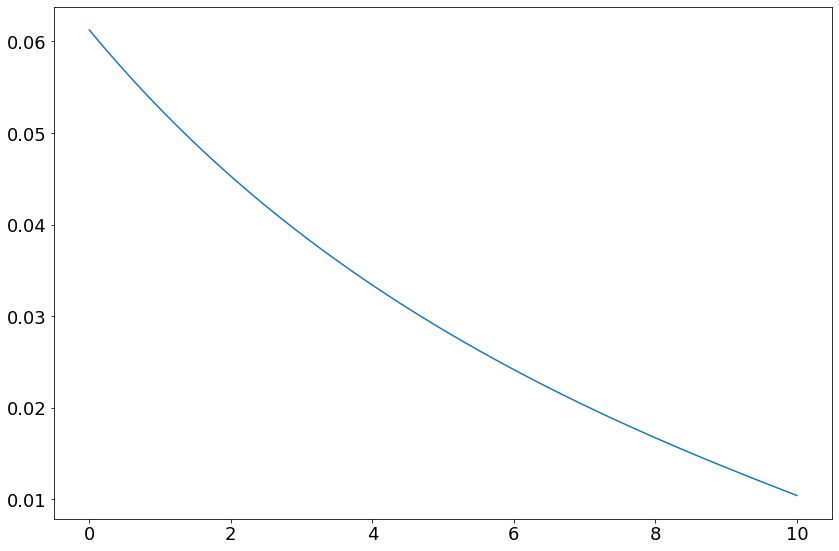

In [220]:
plt.plot(y_grid,ϕ_state[0][25])

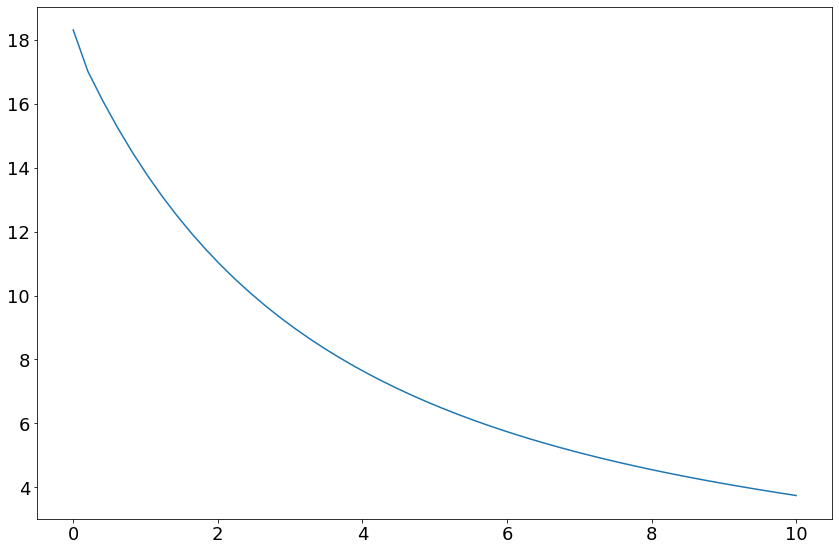

In [224]:
plt.plot(y_grid,e_state[0][25])

In [225]:
e_state[0][25]

array([18.31053476, 17.00837013, 16.09672381, 15.25893175, 14.4884605 ,
       13.7785767 , 13.12332338, 12.51741657, 11.95616203, 11.43538284,
       10.95135646, 10.50075994, 10.08062219,  9.68828246,  9.32135399,
        8.97769241,  8.65536795,  8.35264128,  8.06794216,  7.79985084,
        7.54708164,  7.30846847,  7.08295217,  6.86956922,  6.66744183,
        6.47576913,  6.29381938,  6.12092301,  5.9564665 ,  5.79988681,
        5.65066648,  5.50832925,  5.37243602,  5.24258132,  5.11839002,
        4.99951436,  4.88563116,  4.77643931,  4.67165727,  4.57102074,
        4.47428029,  4.38119895,  4.29154967,  4.20511249,  4.12167139,
        4.04101042,  3.96290917,  3.88713698,  3.81344553,  3.74155965])

array([-0.02210974, -0.02211344, -0.02211712, -0.02212077, -0.02212441,
       -0.02212803, -0.02213163, -0.02213521, -0.02213876, -0.0221423 ,
       -0.02214582, -0.02214933, -0.02215281, -0.02215628, -0.02215972,
       -0.02216315, -0.02216657, -0.02216996, -0.02217334, -0.0221767 ,
       -0.02218005, -0.02218337, -0.02218668, -0.02218998, -0.02219326,
       -0.02219652, -0.02219977, -0.022203  , -0.02220622, -0.02220942,
       -0.02221261, -0.02221578, -0.02221894, -0.02222208, -0.02222521,
       -0.02222833, -0.02223143, -0.02223452, -0.02223759, -0.02224066,
       -0.02224371, -0.02224674, -0.02224977, -0.02225278, -0.02225578,
       -0.02225876, -0.02226174, -0.0222647 , -0.02226765, -0.02227059])

In [233]:
# Compute boundary condition
ϕ_state_chosen = [ϕ_state[0], ϕ_state[1]]
ϕ_mean = np.average(np.array(ϕ_state_chosen), axis=0, weights=[0.5, 0.5])
ϕ_bc = np.zeros_like(z_grid)
for i in range(len(z_grid)):
    ϕ_bc[i] = np.interp(λ_bar, y_grid, ϕ_mean[i])
bc_5 = (np.zeros(1), np.zeros(1), np.zeros(1), ϕ_bc)
impose_bc_5 = (False, False, False, True)

# Change grid setting
n_y = 50
y_min = 1e-10
y_max = 2
y_grid = np.linspace(y_min, y_max, n_y)


pde_paras = (η, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, 0.,π_o)

# ϕ_grid, e_grid = hjb_modified(z_grid, y_grid, model_paras=pde_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=1000,
#                               use_python=True, bc=bc, impose_bc=impose_bc)
ϕ_grid_5, e_grid_5, π_5 = hjb_modified_ambiguity(z_grid, y_grid, model_paras=pde_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=1000,
                              use_python=True, bc=bc_5, impose_bc=impose_bc_5)

Iteration 1: LHS Error: 0.044538260513340935; RHS Error 0.0019668558743227934
Iteration 2: LHS Error: 0.005415063022983014; RHS Error 0.006340122453940818
Iteration 3: LHS Error: 0.0023866243679634726; RHS Error 0.0024294021923725244
Iteration 4: LHS Error: 0.0011643018559897539; RHS Error 0.0013178868983194309
Iteration 5: LHS Error: 0.0011267631104728013; RHS Error 0.0012440148970481939
Iteration 6: LHS Error: 0.0010930438907929751; RHS Error 0.0011817615068265128
Iteration 7: LHS Error: 0.001061902645759773; RHS Error 0.0011287497958828829
Iteration 8: LHS Error: 0.0010329981409416301; RHS Error 0.0010835503711898353
Iteration 9: LHS Error: 0.0010063282311752724; RHS Error 0.0010450317764714558
Iteration 10: LHS Error: 0.00098188504689092; RHS Error 0.0010121378359255716
Iteration 11: LHS Error: 0.0009596320322575232; RHS Error 0.0009838577024226264
Iteration 12: LHS Error: 0.000939299818714873; RHS Error 0.000959239920604836
Iteration 13: LHS Error: 0.0009207016876626156; RHS Error

Iteration 105: LHS Error: 0.00032712856631882115; RHS Error 0.000329345857306042
Iteration 106: LHS Error: 0.00032352858038836585; RHS Error 0.0003257196524566943
Iteration 107: LHS Error: 0.00031996346982909873; RHS Error 0.0003221367934833437
Iteration 108: LHS Error: 0.00031643597681020597; RHS Error 0.0003185839060046825
Iteration 109: LHS Error: 0.0003129413726696145; RHS Error 0.00031507619796240793
Iteration 110: LHS Error: 0.0003095310601121809; RHS Error 0.00031159527431488386
Iteration 111: LHS Error: 0.00030607076678486334; RHS Error 0.00030819768167822143
Iteration 112: LHS Error: 0.000302677025950146; RHS Error 0.00030475494837337296
Iteration 113: LHS Error: 0.00029931303071664694; RHS Error 0.0003013616649274708
Iteration 114: LHS Error: 0.00029598682649496777; RHS Error 0.0002980184840880617
Iteration 115: LHS Error: 0.0002927012092467235; RHS Error 0.00029471391319027876
Iteration 116: LHS Error: 0.0002894437258422339; RHS Error 0.0002914365288338314
Iteration 117: LHS

Iteration 205: LHS Error: 9.967097422027005e-05; RHS Error 0.0001005658882830806
Iteration 206: LHS Error: 9.831410265898066e-05; RHS Error 9.923496518532155e-05
Iteration 207: LHS Error: 9.704112021734213e-05; RHS Error 9.79034474709831e-05
Iteration 208: LHS Error: 9.606931583795719e-05; RHS Error 9.65898256397341e-05
Iteration 209: LHS Error: 9.454518789649147e-05; RHS Error 9.547149476044504e-05
Iteration 210: LHS Error: 9.318480104726634e-05; RHS Error 9.417348214033462e-05
Iteration 211: LHS Error: 9.203461111158273e-05; RHS Error 9.292481570925294e-05
Iteration 212: LHS Error: 9.099659071025445e-05; RHS Error 9.162442157385829e-05
Iteration 213: LHS Error: 8.966354171542623e-05; RHS Error 9.055126198747503e-05
Iteration 214: LHS Error: 8.838207698322331e-05; RHS Error 8.9232825103425e-05
Iteration 215: LHS Error: 8.741737686157602e-05; RHS Error 8.796207820454518e-05
Iteration 216: LHS Error: 8.603996413139581e-05; RHS Error 8.69596440380301e-05
Iteration 217: LHS Error: 8.47243

Iteration 309: LHS Error: 2.8886151818008354e-05; RHS Error 4.0523661851248765e-05
Iteration 310: LHS Error: 2.8789353423749886e-05; RHS Error 4.05308187573653e-05
Iteration 311: LHS Error: 2.8572066079105007e-05; RHS Error 4.050075230801233e-05
Iteration 312: LHS Error: 2.839910632478071e-05; RHS Error 4.051078080727129e-05
Iteration 313: LHS Error: 2.8264209206055324e-05; RHS Error 4.051366315528533e-05
Iteration 314: LHS Error: 2.8062374257252498e-05; RHS Error 4.0498514113129426e-05
Iteration 315: LHS Error: 2.7907298197162034e-05; RHS Error 4.049533700511025e-05
Iteration 316: LHS Error: 2.779189628506623e-05; RHS Error 4.0482921709868114e-05
Iteration 317: LHS Error: 2.7545779297595552e-05; RHS Error 4.052241578316579e-05
Iteration 318: LHS Error: 2.7410640634210892e-05; RHS Error 4.052421247449708e-05
Iteration 319: LHS Error: 2.7290080568120878e-05; RHS Error 4.052685685633403e-05
Iteration 320: LHS Error: 2.740798124414162e-05; RHS Error 4.05117505037989e-05
Iteration 321: LHS

Iteration 413: LHS Error: 1.6070699012937784e-05; RHS Error 4.060831192284726e-05
Iteration 414: LHS Error: 1.6066222455368706e-05; RHS Error 4.0610962804785835e-05
Iteration 415: LHS Error: 1.5970513962529354e-05; RHS Error 4.067939221377857e-05
Iteration 416: LHS Error: 1.5812909087878357e-05; RHS Error 4.0646761497275817e-05
Iteration 417: LHS Error: 1.570472498499398e-05; RHS Error 4.063737224320948e-05
Iteration 418: LHS Error: 1.5905353593331784e-05; RHS Error 4.063174069074194e-05
Iteration 419: LHS Error: 1.564797360092962e-05; RHS Error 4.062908808084485e-05
Iteration 420: LHS Error: 1.5515815475292127e-05; RHS Error 4.060454664160007e-05
Iteration 421: LHS Error: 1.5541214276368343e-05; RHS Error 4.058523923100156e-05
Iteration 422: LHS Error: 1.53471682307893e-05; RHS Error 4.0699163302390976e-05
Iteration 423: LHS Error: 1.526963791885494e-05; RHS Error 4.069981736973991e-05
Iteration 424: LHS Error: 1.5136525937764489e-05; RHS Error 4.068170935024232e-05
Iteration 425: LHS

Iteration 517: LHS Error: 8.547171994596758e-06; RHS Error 4.029226117311741e-05
Iteration 518: LHS Error: 8.44063114596727e-06; RHS Error 4.027878036610079e-05
Iteration 519: LHS Error: 8.364797109305933e-06; RHS Error 4.026919611851244e-05
Iteration 520: LHS Error: 8.24902293963814e-06; RHS Error 4.025073296664686e-05
Iteration 521: LHS Error: 8.26427393114948e-06; RHS Error 4.0250801462585896e-05
Iteration 522: LHS Error: 8.191793294323735e-06; RHS Error 4.027598282923473e-05
Iteration 523: LHS Error: 8.004875723818805e-06; RHS Error 4.036444107070462e-05
Iteration 524: LHS Error: 7.992906135428912e-06; RHS Error 4.040609496212974e-05
Iteration 525: LHS Error: 7.957802572816641e-06; RHS Error 4.038697952488523e-05
Iteration 526: LHS Error: 7.812531476344975e-06; RHS Error 4.0482741956780286e-05
Iteration 527: LHS Error: 7.644143628873779e-06; RHS Error 4.047351727631165e-05
Iteration 528: LHS Error: 7.89915487346693e-06; RHS Error 4.04994207610471e-05
Iteration 529: LHS Error: 7.628

Iteration 621: LHS Error: 1.5208600078475687e-06; RHS Error 4.03126125243131e-05
Iteration 622: LHS Error: 1.4994444027666143e-06; RHS Error 4.0301414947933645e-05
Iteration 623: LHS Error: 1.4524872710836023e-06; RHS Error 4.0298829526309716e-05
Iteration 624: LHS Error: 1.4228196922316805e-06; RHS Error 4.02878100156358e-05
Iteration 625: LHS Error: 1.4114282845673065e-06; RHS Error 4.027565048064099e-05
Iteration 626: LHS Error: 1.3727601660545874e-06; RHS Error 4.028131854200696e-05
Iteration 627: LHS Error: 1.346403286306419e-06; RHS Error 4.028711097812524e-05
Iteration 628: LHS Error: 1.30429082174921e-06; RHS Error 4.027215924768929e-05
Iteration 629: LHS Error: 3.0976280333723516e-06; RHS Error 4.027247833530646e-05
Iteration 630: LHS Error: 1.2539897196184313e-06; RHS Error 4.036440239222297e-05
Iteration 631: LHS Error: 1.2313894880988663e-06; RHS Error 4.03922660099722e-05
Iteration 632: LHS Error: 1.2412964547625638e-06; RHS Error 4.041150922729408e-05
Iteration 633: LHS E

Iteration 725: LHS Error: 4.832633064832947e-07; RHS Error 4.037481497267647e-05
Iteration 726: LHS Error: 2.2687398286425076e-07; RHS Error 4.035787803024974e-05
Iteration 727: LHS Error: 3.148265830671404e-07; RHS Error 4.036084643557357e-05
Iteration 728: LHS Error: 1.117508664411071e-06; RHS Error 4.0349812168328083e-05
Iteration 729: LHS Error: 1.5198518949245676e-06; RHS Error 4.03810746429238e-05
Iteration 730: LHS Error: 8.786833048841924e-07; RHS Error 4.042489487616986e-05
Iteration 731: LHS Error: 7.343301892219489e-07; RHS Error 4.045078970360749e-05
Iteration 732: LHS Error: 4.4146901818920004e-07; RHS Error 4.045345581277526e-05
Iteration 733: LHS Error: 5.359278581196225e-07; RHS Error 4.046894157819814e-05
Iteration 734: LHS Error: 3.111524653001685e-07; RHS Error 4.04501272906231e-05
Iteration 735: LHS Error: 4.1588333271960765e-07; RHS Error 4.043921957013284e-05
Iteration 736: LHS Error: 7.784575002910132e-07; RHS Error 4.042471809909161e-05
Iteration 737: LHS Error:

Iteration 829: LHS Error: 9.075079411210996e-08; RHS Error 4.024944592469197e-05
Iteration 830: LHS Error: 5.583481907031618e-07; RHS Error 4.024691335013031e-05
Iteration 831: LHS Error: 2.397103185391991e-07; RHS Error 4.0260249645880104e-05
Iteration 832: LHS Error: 2.257584729402351e-07; RHS Error 4.0251850861598394e-05
Iteration 833: LHS Error: 3.8883423037622267e-07; RHS Error 4.025551607629678e-05
Iteration 834: LHS Error: 2.0692534846017407e-07; RHS Error 4.024189303403626e-05
Iteration 835: LHS Error: 4.525962269477657e-07; RHS Error 4.0244907403452795e-05
Iteration 836: LHS Error: 1.0468963971103917e-06; RHS Error 4.022905088116008e-05
Iteration 837: LHS Error: 4.826982613649611e-07; RHS Error 4.025754765520773e-05
Iteration 838: LHS Error: 1.7245958840172992e-07; RHS Error 4.027000232596405e-05
Iteration 839: LHS Error: 4.981344674595545e-08; RHS Error 4.026395976544129e-05
Iteration 840: LHS Error: 4.4835630680362115e-08; RHS Error 4.0263233524895273e-05
Iteration 841: LHS 

Iteration 933: LHS Error: 3.503908935845179e-07; RHS Error 4.044181263804243e-05
Iteration 934: LHS Error: 1.9006510686148115e-07; RHS Error 4.0429504673226856e-05
Iteration 935: LHS Error: 1.6514934071676368e-07; RHS Error 4.042379945256478e-05
Iteration 936: LHS Error: 7.42378176446512e-07; RHS Error 4.042179610302516e-05
Iteration 937: LHS Error: 8.680721802073466e-07; RHS Error 4.039740483809752e-05
Iteration 938: LHS Error: 2.2305817298784447e-06; RHS Error 4.042785288746403e-05
Iteration 939: LHS Error: 8.385580328347519e-07; RHS Error 4.049357928182714e-05
Iteration 940: LHS Error: 9.91947867498566e-07; RHS Error 4.046837355880309e-05
Iteration 941: LHS Error: 8.906761303738298e-07; RHS Error 4.043790674428634e-05
Iteration 942: LHS Error: 1.0129900228708633e-07; RHS Error 4.040966679828276e-05
Iteration 943: LHS Error: 2.040874409331428e-07; RHS Error 4.0410414280446205e-05
Iteration 944: LHS Error: 2.210351874379346e-07; RHS Error 4.041498447384615e-05
Iteration 945: LHS Error

In [227]:
@njit
def simulation(y_grid, z_grid, e_grid, yoz_start=290, z_loc=25, T=100):
    Et = np.zeros(T+1)
    z = z_grid[z_loc]
    for i in range(T+1):
        Et[i] = np.interp(yoz_start*z, y_grid, e_grid[z_loc])
        yoz_start = yoz_start + Et[i]
        if yoz_start*z > 2:
            print('Warning')
    return Et


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

In [234]:
T = 100
Et_5 = simulation(y_grid, z_grid, e_grid_5, yoz_start=290, z_loc=25, T=T)

In [229]:
ϕ_mean = np.average(np.array(ϕ_state_chosen), axis=0, weights=[0.4, 0.6])
ϕ_bc = np.zeros_like(z_grid)
for i in range(len(z_grid)):
    ϕ_bc[i] = np.interp(λ_bar, y_grid, ϕ_mean[i])
bc_6 = (np.zeros(1), np.zeros(1), np.zeros(1), ϕ_bc)
impose_bc_6 = (False, False, False, True)

ϕ_mean = np.average(np.array(ϕ_state_chosen), axis=0, weights=[0.3, 0.7])
ϕ_bc = np.zeros_like(z_grid)
for i in range(len(z_grid)):
    ϕ_bc[i] = np.interp(λ_bar, y_grid, ϕ_mean[i])
bc_7 = (np.zeros(1), np.zeros(1), np.zeros(1), ϕ_bc)
impose_bc_7 = (False, False, False, True)

# Change grid setting

pde_paras = (η, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, 0., π_o)

# ϕ_grid, e_grid = hjb_modified(z_grid, y_grid, model_paras=pde_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=1000,
#                               use_python=True, bc=bc, impose_bc=impose_bc)
ϕ_grid_6, e_grid_6, π_6 = hjb_modified_ambiguity(z_grid, y_grid, model_paras=pde_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=1000,
                              use_python=True, bc=bc_6, impose_bc=impose_bc_6)
ϕ_grid_7, e_grid_7, π_7 = hjb_modified_ambiguity(z_grid, y_grid, model_paras=pde_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=1000,
                              use_python=True, bc=bc_7, impose_bc=impose_bc_7)

Iteration 1: LHS Error: 0.05759024241221034; RHS Error 0.001966855874334119
Iteration 2: LHS Error: 0.007068162545751648; RHS Error 0.008295504079473569
Iteration 3: LHS Error: 0.003116256404298974; RHS Error 0.0031920192846445743
Iteration 4: LHS Error: 0.0014991692126871542; RHS Error 0.0013555906141178963
Iteration 5: LHS Error: 0.0011267678858787496; RHS Error 0.0012440204219047778
Iteration 6: LHS Error: 0.0010930466139496258; RHS Error 0.0011817595422603461
Iteration 7: LHS Error: 0.00106190147981481; RHS Error 0.0011287400777003943
Iteration 8: LHS Error: 0.001032992308581242; RHS Error 0.0010835384628764386
Iteration 9: LHS Error: 0.0010063149172213938; RHS Error 0.0010450213233181528
Iteration 10: LHS Error: 0.000981876597901844; RHS Error 0.0010121196787424168
Iteration 11: LHS Error: 0.0009596573980414184; RHS Error 0.000983839122037446
Iteration 12: LHS Error: 0.0009392980346443411; RHS Error 0.000959235274875517
Iteration 13: LHS Error: 0.000920660220868872; RHS Error 0.00

Iteration 105: LHS Error: 0.0003259648549826105; RHS Error 0.00032815677503476057
Iteration 106: LHS Error: 0.00032236060635841557; RHS Error 0.0003245551001205021
Iteration 107: LHS Error: 0.00031879487745632706; RHS Error 0.0003209822273463203
Iteration 108: LHS Error: 0.00031528655546871065; RHS Error 0.0003174419435453585
Iteration 109: LHS Error: 0.00031178795825299865; RHS Error 0.0003139360988596571
Iteration 110: LHS Error: 0.0003083192792436573; RHS Error 0.0003104305673541808
Iteration 111: LHS Error: 0.00030489175640362187; RHS Error 0.00030699062365117534
Iteration 112: LHS Error: 0.0003014978628860243; RHS Error 0.00030356660014196424
Iteration 113: LHS Error: 0.0002981445715299208; RHS Error 0.00030020417252122093
Iteration 114: LHS Error: 0.0002948261142704106; RHS Error 0.0002968606592318611
Iteration 115: LHS Error: 0.00029154080230180124; RHS Error 0.0002935568663352309
Iteration 116: LHS Error: 0.0002882846130918687; RHS Error 0.00029028243746534997
Iteration 117: LH

Iteration 205: LHS Error: 9.871442196593416e-05; RHS Error 9.960965759016631e-05
Iteration 206: LHS Error: 9.739114818337058e-05; RHS Error 9.828009622018304e-05
Iteration 207: LHS Error: 9.632370917343758e-05; RHS Error 9.697016992259101e-05
Iteration 208: LHS Error: 9.486355544628677e-05; RHS Error 9.57957409567483e-05
Iteration 209: LHS Error: 9.356574744290302e-05; RHS Error 9.452865930831321e-05
Iteration 210: LHS Error: 9.237072084558595e-05; RHS Error 9.324883365821471e-05
Iteration 211: LHS Error: 9.108933868175184e-05; RHS Error 9.193656715378708e-05
Iteration 212: LHS Error: 8.981867480724326e-05; RHS Error 9.065333993805405e-05
Iteration 213: LHS Error: 8.856992188044366e-05; RHS Error 8.939868979334481e-05
Iteration 214: LHS Error: 8.74758528333075e-05; RHS Error 8.817066939803325e-05
Iteration 215: LHS Error: 8.61543759460015e-05; RHS Error 8.70265410722336e-05
Iteration 216: LHS Error: 8.496351285129655e-05; RHS Error 8.582772166302016e-05
Iteration 217: LHS Error: 8.3845

Iteration 309: LHS Error: 4.0200960454192525e-05; RHS Error 4.946400435770638e-05
Iteration 310: LHS Error: 3.976261213137905e-05; RHS Error 4.957528087986289e-05
Iteration 311: LHS Error: 3.95727311382002e-05; RHS Error 4.962469135775169e-05
Iteration 312: LHS Error: 3.937430877383463e-05; RHS Error 4.962988475094183e-05
Iteration 313: LHS Error: 3.90941537268194e-05; RHS Error 4.96108271176094e-05
Iteration 314: LHS Error: 3.8844451687891635e-05; RHS Error 4.959899100370585e-05
Iteration 315: LHS Error: 3.860238508634345e-05; RHS Error 4.958525314409285e-05
Iteration 316: LHS Error: 3.83844098203745e-05; RHS Error 4.957122294393863e-05
Iteration 317: LHS Error: 3.821391819579245e-05; RHS Error 4.956230299077941e-05
Iteration 318: LHS Error: 3.7970283540279814e-05; RHS Error 4.953981101716509e-05
Iteration 319: LHS Error: 3.7762512613719046e-05; RHS Error 4.9529454089996744e-05
Iteration 320: LHS Error: 3.755151716654248e-05; RHS Error 4.952225416768643e-05
Iteration 321: LHS Error: 3

Iteration 413: LHS Error: 2.2870168698216342e-05; RHS Error 4.945073472442899e-05
Iteration 414: LHS Error: 2.241805203984787e-05; RHS Error 4.947746667611236e-05
Iteration 415: LHS Error: 2.2261901956567576e-05; RHS Error 4.9475169677330735e-05
Iteration 416: LHS Error: 2.213069933927614e-05; RHS Error 4.94764775401498e-05
Iteration 417: LHS Error: 2.2020554741118692e-05; RHS Error 4.9475682792142036e-05
Iteration 418: LHS Error: 2.23283232648544e-05; RHS Error 4.9464076646891795e-05
Iteration 419: LHS Error: 2.206720241149096e-05; RHS Error 4.950614326908404e-05
Iteration 420: LHS Error: 2.1896465464035786e-05; RHS Error 4.954540909367599e-05
Iteration 421: LHS Error: 2.169074822820638e-05; RHS Error 4.952912886612899e-05
Iteration 422: LHS Error: 2.1511700782822496e-05; RHS Error 4.951537141744784e-05
Iteration 423: LHS Error: 2.1388403523885102e-05; RHS Error 4.950431848166547e-05
Iteration 424: LHS Error: 2.1213934806092738e-05; RHS Error 4.9479377576636635e-05
Iteration 425: LHS 

Iteration 517: LHS Error: 1.3196788345340438e-05; RHS Error 4.936737578913714e-05
Iteration 518: LHS Error: 1.2944233337794375e-05; RHS Error 4.937556265223865e-05
Iteration 519: LHS Error: 1.2816978232715881e-05; RHS Error 4.936666895176151e-05
Iteration 520: LHS Error: 1.2770381374274664e-05; RHS Error 4.937040332741926e-05
Iteration 521: LHS Error: 1.2596766220826505e-05; RHS Error 4.935278260169787e-05
Iteration 522: LHS Error: 1.2577712731845492e-05; RHS Error 4.936611323042641e-05
Iteration 523: LHS Error: 1.2466130109425877e-05; RHS Error 4.935580898742939e-05
Iteration 524: LHS Error: 1.2391206114251152e-05; RHS Error 4.9354815189237865e-05
Iteration 525: LHS Error: 1.2305578701757303e-05; RHS Error 4.9351055038434526e-05
Iteration 526: LHS Error: 1.2248651870411242e-05; RHS Error 4.93658116769979e-05
Iteration 527: LHS Error: 1.2138820792345628e-05; RHS Error 4.939006990115773e-05
Iteration 528: LHS Error: 1.207076747607172e-05; RHS Error 4.9403302549020404e-05
Iteration 529: 

Iteration 621: LHS Error: 4.163566304671296e-06; RHS Error 4.9486755463491007e-05
Iteration 622: LHS Error: 4.05520558813266e-06; RHS Error 4.946739348552615e-05
Iteration 623: LHS Error: 3.990886270219263e-06; RHS Error 4.946904139229573e-05
Iteration 624: LHS Error: 3.921508639481708e-06; RHS Error 4.946267790776776e-05
Iteration 625: LHS Error: 3.863637591569602e-06; RHS Error 4.945645944091836e-05
Iteration 626: LHS Error: 3.7953204892748893e-06; RHS Error 4.944597215880547e-05
Iteration 627: LHS Error: 3.721459537017746e-06; RHS Error 4.943573705319257e-05
Iteration 628: LHS Error: 3.923494068261424e-06; RHS Error 4.942882991693441e-05
Iteration 629: LHS Error: 3.867594516086814e-06; RHS Error 4.950690561392066e-05
Iteration 630: LHS Error: 3.576101736679771e-06; RHS Error 4.96045413004785e-05
Iteration 631: LHS Error: 3.4997750739534927e-06; RHS Error 4.9630909956917275e-05
Iteration 632: LHS Error: 3.4855293884333838e-06; RHS Error 4.965602463772457e-05
Iteration 633: LHS Error:

Iteration 725: LHS Error: 8.808213978889201e-07; RHS Error 4.950126853357272e-05
Iteration 726: LHS Error: 5.817612090813773e-07; RHS Error 4.95100441318333e-05
Iteration 727: LHS Error: 5.485296944440776e-07; RHS Error 4.9501489373017525e-05
Iteration 728: LHS Error: 5.230675137607443e-07; RHS Error 4.949149471479248e-05
Iteration 729: LHS Error: 4.956883453977046e-07; RHS Error 4.947832156728933e-05
Iteration 730: LHS Error: 4.6492638301753875e-07; RHS Error 4.946478509387739e-05
Iteration 731: LHS Error: 6.58891113183846e-07; RHS Error 4.945465104586361e-05
Iteration 732: LHS Error: 4.834659651786755e-07; RHS Error 4.943612758917991e-05
Iteration 733: LHS Error: 1.9970917530878762e-06; RHS Error 4.9446048314488614e-05
Iteration 734: LHS Error: 4.09335871129346e-07; RHS Error 4.9494634188779e-05
Iteration 735: LHS Error: 4.3319991549495285e-07; RHS Error 4.950302131145713e-05
Iteration 736: LHS Error: 3.9235351687039177e-07; RHS Error 4.9492962794495564e-05
Iteration 737: LHS Error: 

Iteration 829: LHS Error: 3.144359586315648e-07; RHS Error 4.9584786692594136e-05
Iteration 830: LHS Error: 6.481632496141421e-07; RHS Error 4.958030356224355e-05
Iteration 831: LHS Error: 2.933381050840289e-07; RHS Error 4.9567124114134756e-05
Iteration 832: LHS Error: 4.3147203106219667e-07; RHS Error 4.956241076866924e-05
Iteration 833: LHS Error: 2.44155819888181e-07; RHS Error 4.955392005521403e-05
Iteration 834: LHS Error: 2.921595276816902e-07; RHS Error 4.9549819316568606e-05
Iteration 835: LHS Error: 4.332476931517837e-07; RHS Error 4.954429780679434e-05
Iteration 836: LHS Error: 4.0948903908683e-07; RHS Error 4.9534963728321495e-05
Iteration 837: LHS Error: 6.440200923871209e-07; RHS Error 4.9525880684582455e-05
Iteration 838: LHS Error: 5.007555229571969e-07; RHS Error 4.951053355501878e-05
Iteration 839: LHS Error: 5.775081855230457e-07; RHS Error 4.94983043616368e-05
Iteration 840: LHS Error: 5.940173270352345e-07; RHS Error 4.948374097952936e-05
Iteration 841: LHS Error: 

Iteration 933: LHS Error: 9.57978220118838e-08; RHS Error 4.9522251880104764e-05
Iteration 934: LHS Error: 2.4133712207136115e-07; RHS Error 4.952237842240654e-05
Iteration 935: LHS Error: 3.366039871277593e-07; RHS Error 4.951528030221475e-05
Iteration 936: LHS Error: 6.382394216949971e-08; RHS Error 4.952198626858691e-05
Iteration 937: LHS Error: 2.1943811360364274e-07; RHS Error 4.952183409834274e-05
Iteration 938: LHS Error: 3.264257130083936e-07; RHS Error 4.952591857218906e-05
Iteration 939: LHS Error: 9.652176089641751e-08; RHS Error 4.9516378194647506e-05
Iteration 940: LHS Error: 1.697182467619296e-06; RHS Error 4.951361761853755e-05
Iteration 941: LHS Error: 2.456733593093896e-06; RHS Error 4.956356031537065e-05
Iteration 942: LHS Error: 3.6943287418100823e-07; RHS Error 4.962356923680794e-05
Iteration 943: LHS Error: 3.876503257907449e-07; RHS Error 4.9624740239329595e-05
Iteration 944: LHS Error: 4.5331501941775487e-07; RHS Error 4.962979632731574e-05
Iteration 945: LHS Err

Iteration 38: LHS Error: 0.0006624257787944052; RHS Error 0.0006664731529580073
Iteration 39: LHS Error: 0.0006555424889221409; RHS Error 0.000659433169377403
Iteration 40: LHS Error: 0.0006487609182284498; RHS Error 0.000652558197645961
Iteration 41: LHS Error: 0.0006420254954902713; RHS Error 0.0006457284477827869
Iteration 42: LHS Error: 0.0006353894318073261; RHS Error 0.0006390980905883531
Iteration 43: LHS Error: 0.0006288403850701688; RHS Error 0.0006325832903506708
Iteration 44: LHS Error: 0.0006224926991416566; RHS Error 0.0006260577177806958
Iteration 45: LHS Error: 0.0006164846222166537; RHS Error 0.0006196736164639407
Iteration 46: LHS Error: 0.0006100140273851903; RHS Error 0.0006132254012084176
Iteration 47: LHS Error: 0.0006038184932631377; RHS Error 0.0006069622364778118
Iteration 48: LHS Error: 0.0005977234013441954; RHS Error 0.0006008978986394755
Iteration 49: LHS Error: 0.0005915927571058591; RHS Error 0.00059492538766191
Iteration 50: LHS Error: 0.00058558651625390

Iteration 142: LHS Error: 0.00021359588658843853; RHS Error 0.00021513951748213227
Iteration 143: LHS Error: 0.00021121595000850313; RHS Error 0.00021264260290637194
Iteration 144: LHS Error: 0.00020874772950084386; RHS Error 0.00021026400711047046
Iteration 145: LHS Error: 0.0002062946053597442; RHS Error 0.00020783726891908318
Iteration 146: LHS Error: 0.0002039294559187388; RHS Error 0.00020542950772509485
Iteration 147: LHS Error: 0.00020152952595137164; RHS Error 0.00020298431137113484
Iteration 148: LHS Error: 0.00019915613552966283; RHS Error 0.00020058240587859748
Iteration 149: LHS Error: 0.00019721509070838583; RHS Error 0.00019824546317241622
Iteration 150: LHS Error: 0.00019467342224216422; RHS Error 0.00019615433570635695
Iteration 151: LHS Error: 0.00019234932662512416; RHS Error 0.0001937765942000997
Iteration 152: LHS Error: 0.00019001953803832183; RHS Error 0.00019145713492324447
Iteration 153: LHS Error: 0.00018779806325283643; RHS Error 0.0001892037441824279
Iteratio

Iteration 246: LHS Error: 7.10357933463206e-05; RHS Error 5.9499809928189695e-05
Iteration 247: LHS Error: 7.058217741137685e-05; RHS Error 5.911482780912488e-05
Iteration 248: LHS Error: 7.01418761328643e-05; RHS Error 5.87826989139534e-05
Iteration 249: LHS Error: 6.968364404305247e-05; RHS Error 5.880625665159847e-05
Iteration 250: LHS Error: 6.925628425982419e-05; RHS Error 5.883846380157304e-05
Iteration 251: LHS Error: 6.88104513782567e-05; RHS Error 5.885445195091273e-05
Iteration 252: LHS Error: 6.848077511905672e-05; RHS Error 5.888332557489784e-05
Iteration 253: LHS Error: 6.812026905726395e-05; RHS Error 5.889824167469673e-05
Iteration 254: LHS Error: 6.797881714859684e-05; RHS Error 5.89367821243364e-05
Iteration 255: LHS Error: 6.744903911915824e-05; RHS Error 5.897193229805154e-05
Iteration 256: LHS Error: 6.708920581887517e-05; RHS Error 5.89937308458461e-05
Iteration 257: LHS Error: 6.69032938221785e-05; RHS Error 5.9010986550723336e-05
Iteration 258: LHS Error: 6.64574

Iteration 350: LHS Error: 3.9477488131878236e-05; RHS Error 6.006840080995305e-05
Iteration 351: LHS Error: 3.923225650852291e-05; RHS Error 6.004395365753564e-05
Iteration 352: LHS Error: 3.8983575404917536e-05; RHS Error 6.002036691244455e-05
Iteration 353: LHS Error: 3.871579139768516e-05; RHS Error 6.000197732694267e-05
Iteration 354: LHS Error: 3.852089880852089e-05; RHS Error 5.9998445885417907e-05
Iteration 355: LHS Error: 3.829360469417842e-05; RHS Error 5.999040458887358e-05
Iteration 356: LHS Error: 3.810622328159069e-05; RHS Error 5.998680700302859e-05
Iteration 357: LHS Error: 3.793806494822166e-05; RHS Error 5.9975193994364085e-05
Iteration 358: LHS Error: 3.775375855290253e-05; RHS Error 5.9996680452077794e-05
Iteration 359: LHS Error: 3.7448638702995696e-05; RHS Error 6.004029973269121e-05
Iteration 360: LHS Error: 3.727371581638966e-05; RHS Error 6.00476717666622e-05
Iteration 361: LHS Error: 3.706067248466366e-05; RHS Error 6.004129831450361e-05
Iteration 362: LHS Erro

Iteration 454: LHS Error: 2.2454628126986065e-05; RHS Error 6.001940351770849e-05
Iteration 455: LHS Error: 2.2349855739713098e-05; RHS Error 6.0010276206360284e-05
Iteration 456: LHS Error: 2.2229487895084055e-05; RHS Error 5.999833264413311e-05
Iteration 457: LHS Error: 2.2113575869349422e-05; RHS Error 5.998712254533521e-05
Iteration 458: LHS Error: 2.199921096660007e-05; RHS Error 5.9975327506514646e-05
Iteration 459: LHS Error: 2.1891884813232676e-05; RHS Error 5.996219551278766e-05
Iteration 460: LHS Error: 2.1755177924451252e-05; RHS Error 5.995845561155938e-05
Iteration 461: LHS Error: 2.1662478801143248e-05; RHS Error 5.9942424759681675e-05
Iteration 462: LHS Error: 2.1819518665380788e-05; RHS Error 5.9942930512322796e-05
Iteration 463: LHS Error: 2.1533447421909213e-05; RHS Error 6.003796679331486e-05
Iteration 464: LHS Error: 2.144387029281991e-05; RHS Error 6.010682457200755e-05
Iteration 465: LHS Error: 2.123108261169182e-05; RHS Error 6.009070348456932e-05
Iteration 466: 

Iteration 558: LHS Error: 1.3128059317024654e-05; RHS Error 6.018868520718113e-05
Iteration 559: LHS Error: 1.3005420733236406e-05; RHS Error 6.0186890399232145e-05
Iteration 560: LHS Error: 1.293409986846683e-05; RHS Error 6.018098467701429e-05
Iteration 561: LHS Error: 1.2732013661628794e-05; RHS Error 6.0156360692784734e-05
Iteration 562: LHS Error: 1.2657735866991593e-05; RHS Error 6.0157038240062315e-05
Iteration 563: LHS Error: 1.2572079099951172e-05; RHS Error 6.0151805348241e-05
Iteration 564: LHS Error: 1.2491697242905664e-05; RHS Error 6.014253923770822e-05
Iteration 565: LHS Error: 1.2369139184412181e-05; RHS Error 6.0127847228098694e-05
Iteration 566: LHS Error: 1.2302381063991619e-05; RHS Error 6.012172463525878e-05
Iteration 567: LHS Error: 1.2220759258330105e-05; RHS Error 6.0109195056189e-05
Iteration 568: LHS Error: 1.2112330129460114e-05; RHS Error 6.009334633028203e-05
Iteration 569: LHS Error: 1.2040927903647636e-05; RHS Error 6.008796996231942e-05
Iteration 570: LH

Iteration 662: LHS Error: 4.263306186122473e-06; RHS Error 6.0160565415790915e-05
Iteration 663: LHS Error: 4.244374102735371e-06; RHS Error 6.01660174030258e-05
Iteration 664: LHS Error: 4.684594530943165e-06; RHS Error 6.014902773695737e-05
Iteration 665: LHS Error: 4.225996548951061e-06; RHS Error 6.018058663598591e-05
Iteration 666: LHS Error: 4.127191189431945e-06; RHS Error 6.017016490867701e-05
Iteration 667: LHS Error: 4.050776402891865e-06; RHS Error 6.015702519467492e-05
Iteration 668: LHS Error: 3.923786070364477e-06; RHS Error 6.0136782518267125e-05
Iteration 669: LHS Error: 3.877554632311653e-06; RHS Error 6.0128750362799874e-05
Iteration 670: LHS Error: 3.7796174153781337e-06; RHS Error 6.0111448485068264e-05
Iteration 671: LHS Error: 3.7309516959099787e-06; RHS Error 6.01017581011785e-05
Iteration 672: LHS Error: 3.654661864804787e-06; RHS Error 6.008686532888752e-05
Iteration 673: LHS Error: 3.5953289083817674e-06; RHS Error 6.007548853318114e-05
Iteration 674: LHS Erro

Iteration 766: LHS Error: 9.155533975055419e-07; RHS Error 6.0111516465804254e-05
Iteration 767: LHS Error: 6.728963171526159e-07; RHS Error 6.0096547216202326e-05
Iteration 768: LHS Error: 2.8505108849163907e-06; RHS Error 6.0093685348225784e-05
Iteration 769: LHS Error: 6.624095841428757e-07; RHS Error 6.015200072049772e-05
Iteration 770: LHS Error: 6.933656269969557e-07; RHS Error 6.014909861291465e-05
Iteration 771: LHS Error: 7.100168327375811e-07; RHS Error 6.013508904480833e-05
Iteration 772: LHS Error: 5.77528488504564e-07; RHS Error 6.012042123551305e-05
Iteration 773: LHS Error: 8.70328113945773e-07; RHS Error 6.011287850668607e-05
Iteration 774: LHS Error: 6.918878963022013e-07; RHS Error 6.013068195539297e-05
Iteration 775: LHS Error: 5.219880662016285e-07; RHS Error 6.0116318764131835e-05
Iteration 776: LHS Error: 7.082609755071356e-07; RHS Error 6.011803555005042e-05
Iteration 777: LHS Error: 5.820251458218961e-07; RHS Error 6.0103050411774436e-05
Iteration 778: LHS Error

Iteration 870: LHS Error: 4.0677373394637506e-07; RHS Error 5.997399129835089e-05
Iteration 871: LHS Error: 1.731739833685242e-07; RHS Error 5.99791899318612e-05
Iteration 872: LHS Error: 5.238079151884123e-07; RHS Error 5.998002626112979e-05
Iteration 873: LHS Error: 1.2969578251642577e-07; RHS Error 5.996704526780821e-05
Iteration 874: LHS Error: 2.3041791022415659e-07; RHS Error 5.996434153326929e-05
Iteration 875: LHS Error: 1.156130924051535e-07; RHS Error 5.9958631602921694e-05
Iteration 876: LHS Error: 4.371682233855756e-07; RHS Error 5.995712181280554e-05
Iteration 877: LHS Error: 4.4691592782780676e-07; RHS Error 5.9946288705252764e-05
Iteration 878: LHS Error: 1.3289625980517084e-06; RHS Error 5.9935684736331385e-05
Iteration 879: LHS Error: 5.694904302161463e-07; RHS Error 5.9959728348189086e-05
Iteration 880: LHS Error: 5.209838538217104e-07; RHS Error 5.994561593205003e-05
Iteration 881: LHS Error: 1.900146091235455e-07; RHS Error 5.9953720042924875e-05
Iteration 882: LHS 

Iteration 974: LHS Error: 5.88861117513384e-07; RHS Error 5.9920434686977266e-05
Iteration 975: LHS Error: 1.2220651415123518e-07; RHS Error 5.9907673974597825e-05
Iteration 976: LHS Error: 1.7861230391935656e-07; RHS Error 5.990758303542731e-05
Iteration 977: LHS Error: 1.0256442893250006e-06; RHS Error 5.990315751171927e-05
Iteration 978: LHS Error: 4.763608205393677e-07; RHS Error 5.992285730617416e-05
Iteration 979: LHS Error: 6.564232120573332e-07; RHS Error 5.993155589168741e-05
Iteration 980: LHS Error: 1.23437074214805e-07; RHS Error 5.9916024387076086e-05
Iteration 981: LHS Error: 3.799348608779507e-07; RHS Error 5.991381277053449e-05
Iteration 982: LHS Error: 2.8122942657277106e-07; RHS Error 5.990439916957389e-05
Iteration 983: LHS Error: 4.2082198507820134e-07; RHS Error 5.9897431489712585e-05
Iteration 984: LHS Error: 4.768152560771788e-07; RHS Error 5.988700545999376e-05
Iteration 985: LHS Error: 1.4523947699379702e-07; RHS Error 5.987519258229189e-05
Iteration 986: LHS E

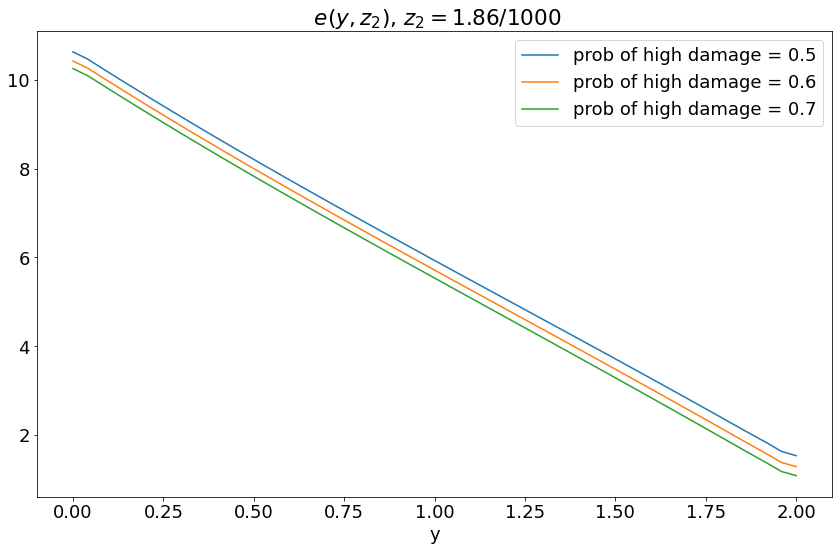

In [235]:
plt.plot(y_grid, e_grid_5[25], label='prob of high damage = 0.5')
plt.plot(y_grid, e_grid_6[25], label='prob of high damage = 0.6')
plt.plot(y_grid, e_grid_7[25], label='prob of high damage = 0.7')

plt.xlabel('y')
plt.legend()
plt.title(r' $e(y, z_2)$, $z_2=1.86/1000$')
# plt.ylim(0, None)
plt.savefig("e_y.png")

In [236]:
Et_6 = simulation(y_grid, z_grid, e_grid_6, yoz_start=290, z_loc=25, T=T)
Et_7 = simulation(y_grid, z_grid, e_grid_7, yoz_start=290, z_loc=25, T=T)

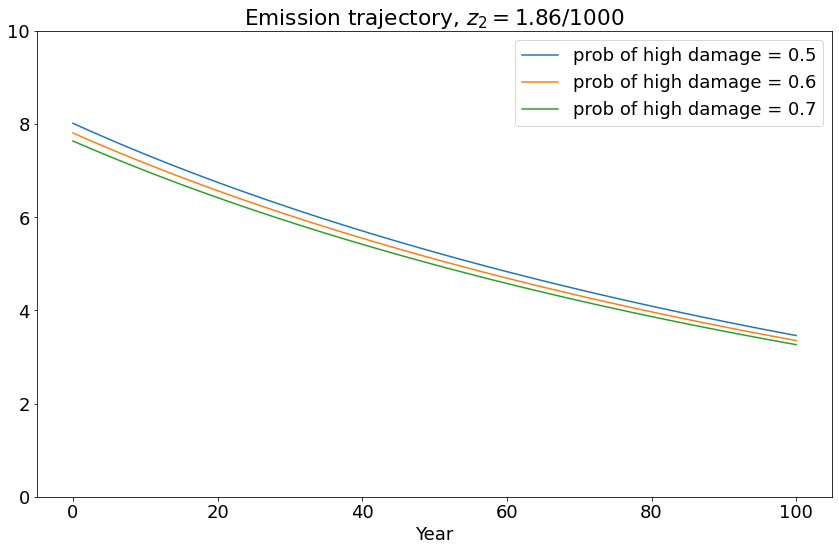

In [237]:
plt.plot(Et_5, label='prob of high damage = 0.5')
plt.plot(Et_6, label='prob of high damage = 0.6')
plt.plot(Et_7, label='prob of high damage = 0.7')

plt.legend()
plt.ylim(0, 10)
plt.xlabel('Year')
plt.title(r'Emission trajectory, $z_2=1.86/1000$')
plt.savefig('e_t.png')